<a id="Data_Analysis_R"></a>
# Data Analysis R

This notebook contains an R based analysis for the creation of a composite model for method selection. It partially draws on previous analysis in Python and R and therefore neglects some of the basic analyses of the explanatory variables.

[Data Analysis R](#Data_Analysis_R)

- [Configurations](#Configurations)
- [Data Acquisition](#Data_Acquisition)
- [Classification Model](#Classification_Model)
    - [Common Functions](#Common_Functions)
    - [Variable selection for linear error models](#Variable_Selection)
    - [Composite Model](#Composite_Model)
    - [Final Model Analysis](#Final_Model_Analysis)
    - [Paper Visualisations](#Paper_Visualisations)

<a id="Configurations"></a>
## Configurations

In [1]:
#Import packages 
library(ggpubr)
library(gridExtra)
library(plyr)
library(dplyr) 
library(tidyverse)
library(caret)
library(fastDummies)
library(Metrics)


Lade nötiges Paket: ggplot2


Attache Paket: 'plyr'


Das folgende Objekt ist maskiert 'package:ggpubr':

    mutate



Attache Paket: 'dplyr'


Die folgenden Objekte sind maskiert von 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


Das folgende Objekt ist maskiert 'package:gridExtra':

    combine


Die folgenden Objekte sind maskiert von 'package:stats':

    filter, lag


Die folgenden Objekte sind maskiert von 'package:base':

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.4
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ dplyr::combine()   masks gridExtra::combine()
✖ purrr::compact()   masks ply

In [2]:
#Set language to get english errors and messages
Sys.setenv(LANG = "en")

In [3]:
#Classes/filter methods for final model
classes <- c(1,2,3,7,8,9,10,11,12,19)

#Parameters for model configuration
dynamic <- FALSE
method <- "lm"
target_prefix <- "stems_in_plot_err_ps"

<a id="Data_Acquisition"></a>
## Data Acquisition

In [4]:
#Read data for plots
csv_out_path <- "./Data/detection_aggregated_lfi.csv"
lfi_trees_grouped <- read.csv(csv_out_path,sep=";",quote = "\"")

In [5]:
#Labels for filter methods
parameterset_lookup_labels<-data.frame(val=c( '1m','1.5m','2m','1m, sigma 1, size 3','1m, sigma 1, size 5','1m, sigma 1, size 7','1m, sigma 2, size 3','1m, sigma 2, size 5','1m, sigma 2, size 7','1m, sigma 3, size 3','1m, sigma 3, size 5','1m, sigma 3, size 7','1.5m, sigma 2, size 3','1.5m, sigma 2, size 5','1.5m, sigma 2, size 7','combined 1m/1.5m/1m, sig2, r3','combined 1m/2m/1m, sig2, r5','combined 1m/1.5m/1m, sig1, r3/1m, sig2, r3','combined 1m/1.5m/1m, sig1, r3/1m, sig2, r3/1m, sig3, r3'), row.names=c( 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19))

In [6]:
nh_lookup_labels<-data.frame(val=c( '1) broadleaved dominated','2) mixed','3) coniferous dominated'), row.names=c( 1,2,3))
dg_lookup_labels<-data.frame(val=c( '1) <= 80%','2) > 80%'), row.names=c( 1,2))
hdom_lookup_labels<-data.frame(val=c( '1) <= 22 m','2) > 22m'), row.names=c( 1,2))

In [7]:
#Read aggregated data output created by the F:\fint-ch\python\git\fint_ch\AP07__Kalibrieren_der_EBD_Regeln\Python\fint_ch_diss_method_combination_processing.py
csv_out_path <- "./Data/method_combinations_lfi_reduced.csv"
method_combinations <-  read.csv(csv_out_path,sep=";",quote = "\"",stringsAsFactors=FALSE)

In [8]:
#Excluding specific cases
print(count(lfi_trees_grouped)$n)
#Cases with very high stems per ha in baseline ; 3
lfi_trees_grouped <- lfi_trees_grouped[ !(lfi_trees_grouped$flaeche_id %in% c(40321,154907,156044)),]
print(count(lfi_trees_grouped)$n)
#Cases without reference value ; 2
lfi_trees_grouped <- lfi_trees_grouped[!(is.na(lfi_trees_grouped$density_actual_all)),] 
print(count(lfi_trees_grouped)$n)

[1] 5913
[1] 5910
[1] 5910


In [9]:
#Excluding cases without reference data
lfi_trees_grouped <- lfi_trees_grouped[!(is.na(lfi_trees_grouped$nbr_trees_os) | is.na(lfi_trees_grouped$nbr_trees) | (lfi_trees_grouped$nbr_trees_os==0) | (lfi_trees_grouped$nbr_trees_os==-1)),] 
print(count(lfi_trees_grouped)$n)

##Cases with reference value 0 ; 329
#lfi_trees_grouped = lfi_trees_grouped[np.invert((lfi_trees_grouped["density_actual"]==0)&(lfi_trees_grouped["density_actual_all"]==0))].reset_index() 
#print(len(lfi_trees_grouped))

[1] 5254


In [10]:
#Replacing placeholders in stem counts per ha (they could mess up some charts and operations)
for (i in 1:19){
    lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")] <- apply(lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")], 1, function(x) ifelse(x>=99999999, 0, x))
    lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")] <- apply(lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")], 1, function(x) ifelse(x>=99999999, NA, x))
}

In [11]:
#Deriving and re-setting several error measures
for (i in 1:19){    
    lfi_trees_grouped[paste("stems_in_plot_ae_ps",i,sep="")] <- abs(lfi_trees_grouped["nbr_trees_os"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    lfi_trees_grouped[paste("stems_in_plot_err_ps",i,sep="")] <- (lfi_trees_grouped["nbr_trees_os"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    
    lfi_trees_grouped[paste("stems_in_plot_ae_all_ps",i,sep="")] <- abs(lfi_trees_grouped["nbr_trees"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    lfi_trees_grouped[paste("stems_in_plot_err_all_ps",i,sep="")] <- (lfi_trees_grouped["nbr_trees"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    
    lfi_trees_grouped[paste("stems_per_ha_rs_ps",i,sep="")] <- (lfi_trees_grouped["density_actual"]-lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")])^2
    lfi_trees_grouped[paste("stems_per_ha_ae_ps",i,sep="")] <- abs(lfi_trees_grouped["density_actual"]-lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")])
    lfi_trees_grouped[paste("stems_per_ha_err_ps",i,sep="")] <- (lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")]-lfi_trees_grouped["density_actual"])

}


In [12]:
#Deriving attributes from existing data 
lfi_trees_grouped["acquisition_diff"] <- lfi_trees_grouped["VHM_Tile_Year"]-lfi_trees_grouped["year"]
lfi_trees_grouped["acquisition_diff_abs"] <- abs(lfi_trees_grouped["acquisition_diff"])

lfi_trees_grouped["veg_code_complete"] <- lfi_trees_grouped["veg_code"]*100+lfi_trees_grouped["veg_subcode"]
lfi_trees_grouped["constant"] <- 1

lfi_trees_grouped["dg_scaled"] <- lfi_trees_grouped["dg"]/100
lfi_trees_grouped["hdom_scaled"] <- lfi_trees_grouped["hdom"]/100
lfi_trees_grouped["nh_scaled"] <- lfi_trees_grouped["nh"]/100

In [13]:
#Determine method with minimal squared difference
determine_min_class_flex <- function (x, input_prefix="stems_per_ha_rs_", input_classes){
    input_columns <- lapply(input_classes,function(x) paste(input_prefix,"ps",x,sep=""))

    min_val = min(x[unlist(input_columns)])

    for (i in input_classes){
        if (x[paste(input_prefix,"ps",i,sep="")] == min_val) {
            return(i)
        }
    }
}


lfi_trees_grouped["parameterset_min"] <- apply(lfi_trees_grouped,1,function(x) determine_min_class_flex(x, input_prefix="stems_per_ha_rs_",input_classes=classes) )   
    

In [14]:
#Deriving 0/1 labels for whether a filter method has the minimal error or not
eps=0.0001
pid <- 0
determine_min_labels <- function (df, input_prefix="stems_per_ha_rs_", output_prefix="ps", input_classes=c(1,2,3,7,8,9,4,5,6,10,11,12,13,14,15,16,17,18,19)){
    input_columns <- lapply(input_classes,function(x) paste(input_prefix,"ps",x,sep=""))
    
    df$tmp_min <- apply(df[unlist(input_columns)],1,min)

    for (i in 1:length(input_classes)) {
        ps=input_classes[[i]]
        df[paste(output_prefix,ps,sep="")] <-  (abs((df[paste(input_prefix,"ps",ps,sep="")] - df$tmp_min))<eps)*1
    }             
    return(subset(df, select = -c(tmp_min) ))
}

lfi_trees_grouped <- determine_min_labels(lfi_trees_grouped, output_prefix="ps", input_classes=classes)
                            
lfi_trees_grouped$parameterset_min <- as.factor(lfi_trees_grouped$parameterset_min)  


In [15]:
#Not clear if this is necessary/wise
lfi_trees_grouped$fst <- as.factor(lfi_trees_grouped$fst)  
lfi_trees_grouped$fst_nh <- as.factor(lfi_trees_grouped$fst_nh)  
lfi_trees_grouped$fst_dg <- as.factor(lfi_trees_grouped$fst_dg)  
lfi_trees_grouped$fst_hdom <- as.factor(lfi_trees_grouped$fst_hdom)  
lfi_trees_grouped$veg_code <- as.factor(lfi_trees_grouped$veg_code)  
lfi_trees_grouped$veg_subcode <- as.factor(lfi_trees_grouped$veg_subcode)  
lfi_trees_grouped$veg_code_complete <- as.factor(lfi_trees_grouped$veg_code_complete)  
lfi_trees_grouped$waldrand <- as.factor(lfi_trees_grouped$bestandesgrenze)  
lfi_trees_grouped$bestandesgrenze <- as.factor(lfi_trees_grouped$bestandesgrenze)

Detection and reference data fields.

|__Name__| __Description__|__Variable Type}__ |
|--------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------|
| Perimeter ID                                                                                     | Identifier of the perimeter                                                                                                                                                                                  | none                   |
| slope_sin<sup>1</sup>                                                                 | Sine of the slope based on 25 m DHM                                                                                                                                                                          | explanatory            |
| aspect_cos                                                                                   | Cosine of the aspect based on 25 m DHM                                                                                                                                                                       | explanatory            |
| aspect_sin                                                                                   | Sine of the aspect based on 25 m DHM                                                                                                                                                                         | explanatory            |
| northness<sup>1</sup>                                                                  | Cosine of the aspect times the sine of the slope based on 25 m DHM                                                                                                                                           | explanatory            |
| eastness                                                                                      | Sine of the aspect times the sine of the slope based on 25 m DHM                                                                                                                                             | explanatory            |
| z<sup>1</sup>                                                                          | Height above sea level in m at plot center                                                                                                                                                                   | explanatory            |
| dg<sup>1</sup>                                                                         | Degree of cover ($(2/3*h_{dom})<h$) in percent (values from 0 to 100) for a 25 by 25 m cell centered on the plot center                                                                                      | explanatory            |
| hdom<sup>1</sup>                                                       | Dominant height in the plot in m for a 25 by 25 m cell centered on the plot center                                                                                                                           | explanatory            |
| nh<sup>1</sup>                                                                        | Dominant Leaf Type for a 25 by 25 m cell centered on the plot center                                                                                                                                         | explanatory            |
| dg_ks<sup>1</sup>                                                                    | Degree of cover no layer ($h<0.4m$) in percent (values from 0 to 100) for a 25 by 25 m cell centered on the plot center                                                                                      | explanatory            |
| dg_us<sup>1</sup>                                                                     | Degree of cover lower layer ($0.4m<=h<=(1/3*h_{dom})$) in percent (values from 0 to 100)  for a 25 by 25 m cell centered on the plot center                                                                  | explanatory            |
| dg_ms<sup>1</sup>                                                                     | Degree of cover middle layer ($(1/3*h_{dom})<h<=(2/3*h_{dom})$) in percent (values from 0 to 100)  for a 25 by 25 m cell centered on the plot center                                                         | explanatory            |
| dg_os<sup>1</sup>                                                                    | Degree of cover upper layer ($(2/3*h_{dom})<h<=h_{dom}$) in percent (values from 0 to 100)  for a 25 by 25 m cell centered on the plot center                                                                | explanatory            |
| dg_ueb<sup>1</sup>                                                                    | Degree of cover protruding ($h_{dom}<h$) in percent (values from 0 to 100) for a 25 by 25 m cell centered on the plot center                                                                                 | explanatory            |
| tri_min<sup>1</sup>, tri_max, tri_mean<sup>1</sup>, tri_median, tri_std<sup>1</sup> | Aggregated statistics for the Terrain Ruggedness Index of the CHM in a 25 by 25 m cell centered on the plot center                                                                                           | explanatory            |
| tpi_min, tpi_max, tpi_mean<sup>1</sup>, tpi_median<sup>1</sup>, tpi_std<sup>1</sup> | Aggregated statistics for the Topographic Position Index of the CHM in a 25 by 25 m cell centered on the plot center                                                                                         | explanatory            |
| local_peaks<sup>1</sup>                                                               | Number of local maxima in the plot on unfiltered 1 m CHM created with skimage.feature.peak_local_max and not with pyFINT                                                                                   | explanatory            |
| nbr_trees_os                                                                                   | Reference value number of trees in the upper layer                                                                                                                                                           | reference/target       |
| density\_actual                                                                                  | Reference value for tree density in trees per ha; this only includes the trees of the upper layer                                                                                                            | reference/target       |
| stems_per_ha_ps1 ... stems_per_ha_ps15                                                     | Number of detected trees per ha for filter combinations 1 to 15 (trees per ha)                                                                                                                               | target/scoring         |
| dr_ps1 ... dr_ps15                                                                             | Detection rate on reference trees in the upper canopy layer (stems_per_ha_psX/density_actual) for the filter combinations 1 to 10                                                                        | target/scoring         |
| stems_in_plot_ps1 ... stems_in_plot_ps15                                                   | Absolute number of stems detected for the filter combinations 1 to 15                                                                                                                                        | target/scoring         |
| stems_per_ha_err_ps1 ... stems_per_ha_err_ps15                                           | Difference between stem count per ha detected and reference trees in the upper canopy layer per ha ( (stems_per_ha_rs_all_psX-density_actual)^2 ) for the filter combinations 1 to 15 | target/scoring         |
| stems_in_plot_err_ps1 ... stems_in_plot_err_ps15                                         | Difference between the number of detected trees and the number of reference trees in the upper layer of the plot (stems_in_plot_psX-nbr_trees) for the filter combinations 1 to 15                       | target/scoring         |
|
<sup>1</sup>: variable used in error model for  final analysis|

In [16]:
#Add dummy 0/1 columns for selected factors
lfi_trees_grouped <- dummy_cols(lfi_trees_grouped, select_columns = "fst")
lfi_trees_grouped <- dummy_cols(lfi_trees_grouped, select_columns = "fst_nh")
lfi_trees_grouped <- dummy_cols(lfi_trees_grouped, select_columns = "fst_dg")
lfi_trees_grouped <- dummy_cols(lfi_trees_grouped, select_columns = "fst_hdom")
        

In [17]:
#Adding log transformed error and errors normalized by the density within the plot
for (i in 1:19){ 
    stems <- lfi_trees_grouped[paste("stems_in_plot_err_ps",i,sep="")]
    stems_min <- min(stems+1,na.rm = TRUE)
    stems_max <- max(stems+1-stems_min,na.rm = TRUE)
    lfi_trees_grouped[paste("stems_in_plot_err_trans_ps",i,sep="")] <- log10(stems_max-(stems - stems_min))
    # lfi_trees_grouped[paste("stems_in_plot_err_trans_ps",i,sep="")] <- sqrt(stems_max-(stems - stems_min))
    lfi_trees_grouped[paste("stems_in_plot_err_norm_ps",i,sep="")] <- (lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")]-lfi_trees_grouped["nbr_trees_os"])/lfi_trees_grouped["nbr_trees_os"]
    # lfi_trees_grouped[paste("stems_in_plot_err_norm_ps",i,sep="")] <- (lfi_trees_grouped["nbr_trees_os"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])/sd(lfi_trees_grouped[,"nbr_trees_os"])
}

In [18]:
print(paste(colnames(lfi_trees_grouped), collapse = "', '"))

[1] "perimeter_id', 'flaeche_id', 'source_id', 'source_label', 'slope', 'slope_class', 'slope_sin', 'aspect', 'aspect_class', 'aspect_cos', 'aspect_sin', 'northness', 'eastness', 'z', 'veg_code', 'veg_de', 'veg_subcode', 'fst', 'fst_dg', 'fst_hdom', 'fst_nh', 'dg', 'hdom', 'nh', 'hdom50', 'dg50', 'nh50', 'fst50', 'dg_ks', 'dg_us', 'dg_ms', 'dg_os', 'dg_ueb', 'dg_ks50', 'dg_us50', 'dg_ms50', 'dg_os50', 'dg_ueb50', 'tri_min', 'tri_max', 'tri_mean', 'tri_median', 'tri_std', 'tpi_min', 'tpi_max', 'tpi_mean', 'tpi_median', 'tpi_std', 'local_peaks', 'x_lv95', 'y_lv95', 'waldrand', 'bestandesgrenze', 'nbr_trees', 'nbr_trees_os', 'bas_ref', 'year', 'density_actual', 'density_actual_all', 'bas_per_ha_ref', 'KANTONSNUM', 'VHM_Year_Min', 'VHM_Year_Max', 'VHM_Tile_Year', 'plot_area', 'stems_per_ha_ps1', 'stems_per_ha_ps2', 'stems_per_ha_ps3', 'stems_per_ha_ps4', 'stems_per_ha_ps5', 'stems_per_ha_ps6', 'stems_per_ha_ps7', 'stems_per_ha_ps8', 'stems_per_ha_ps9', 'stems_per_ha_ps10', 'stems_per_ha_ps

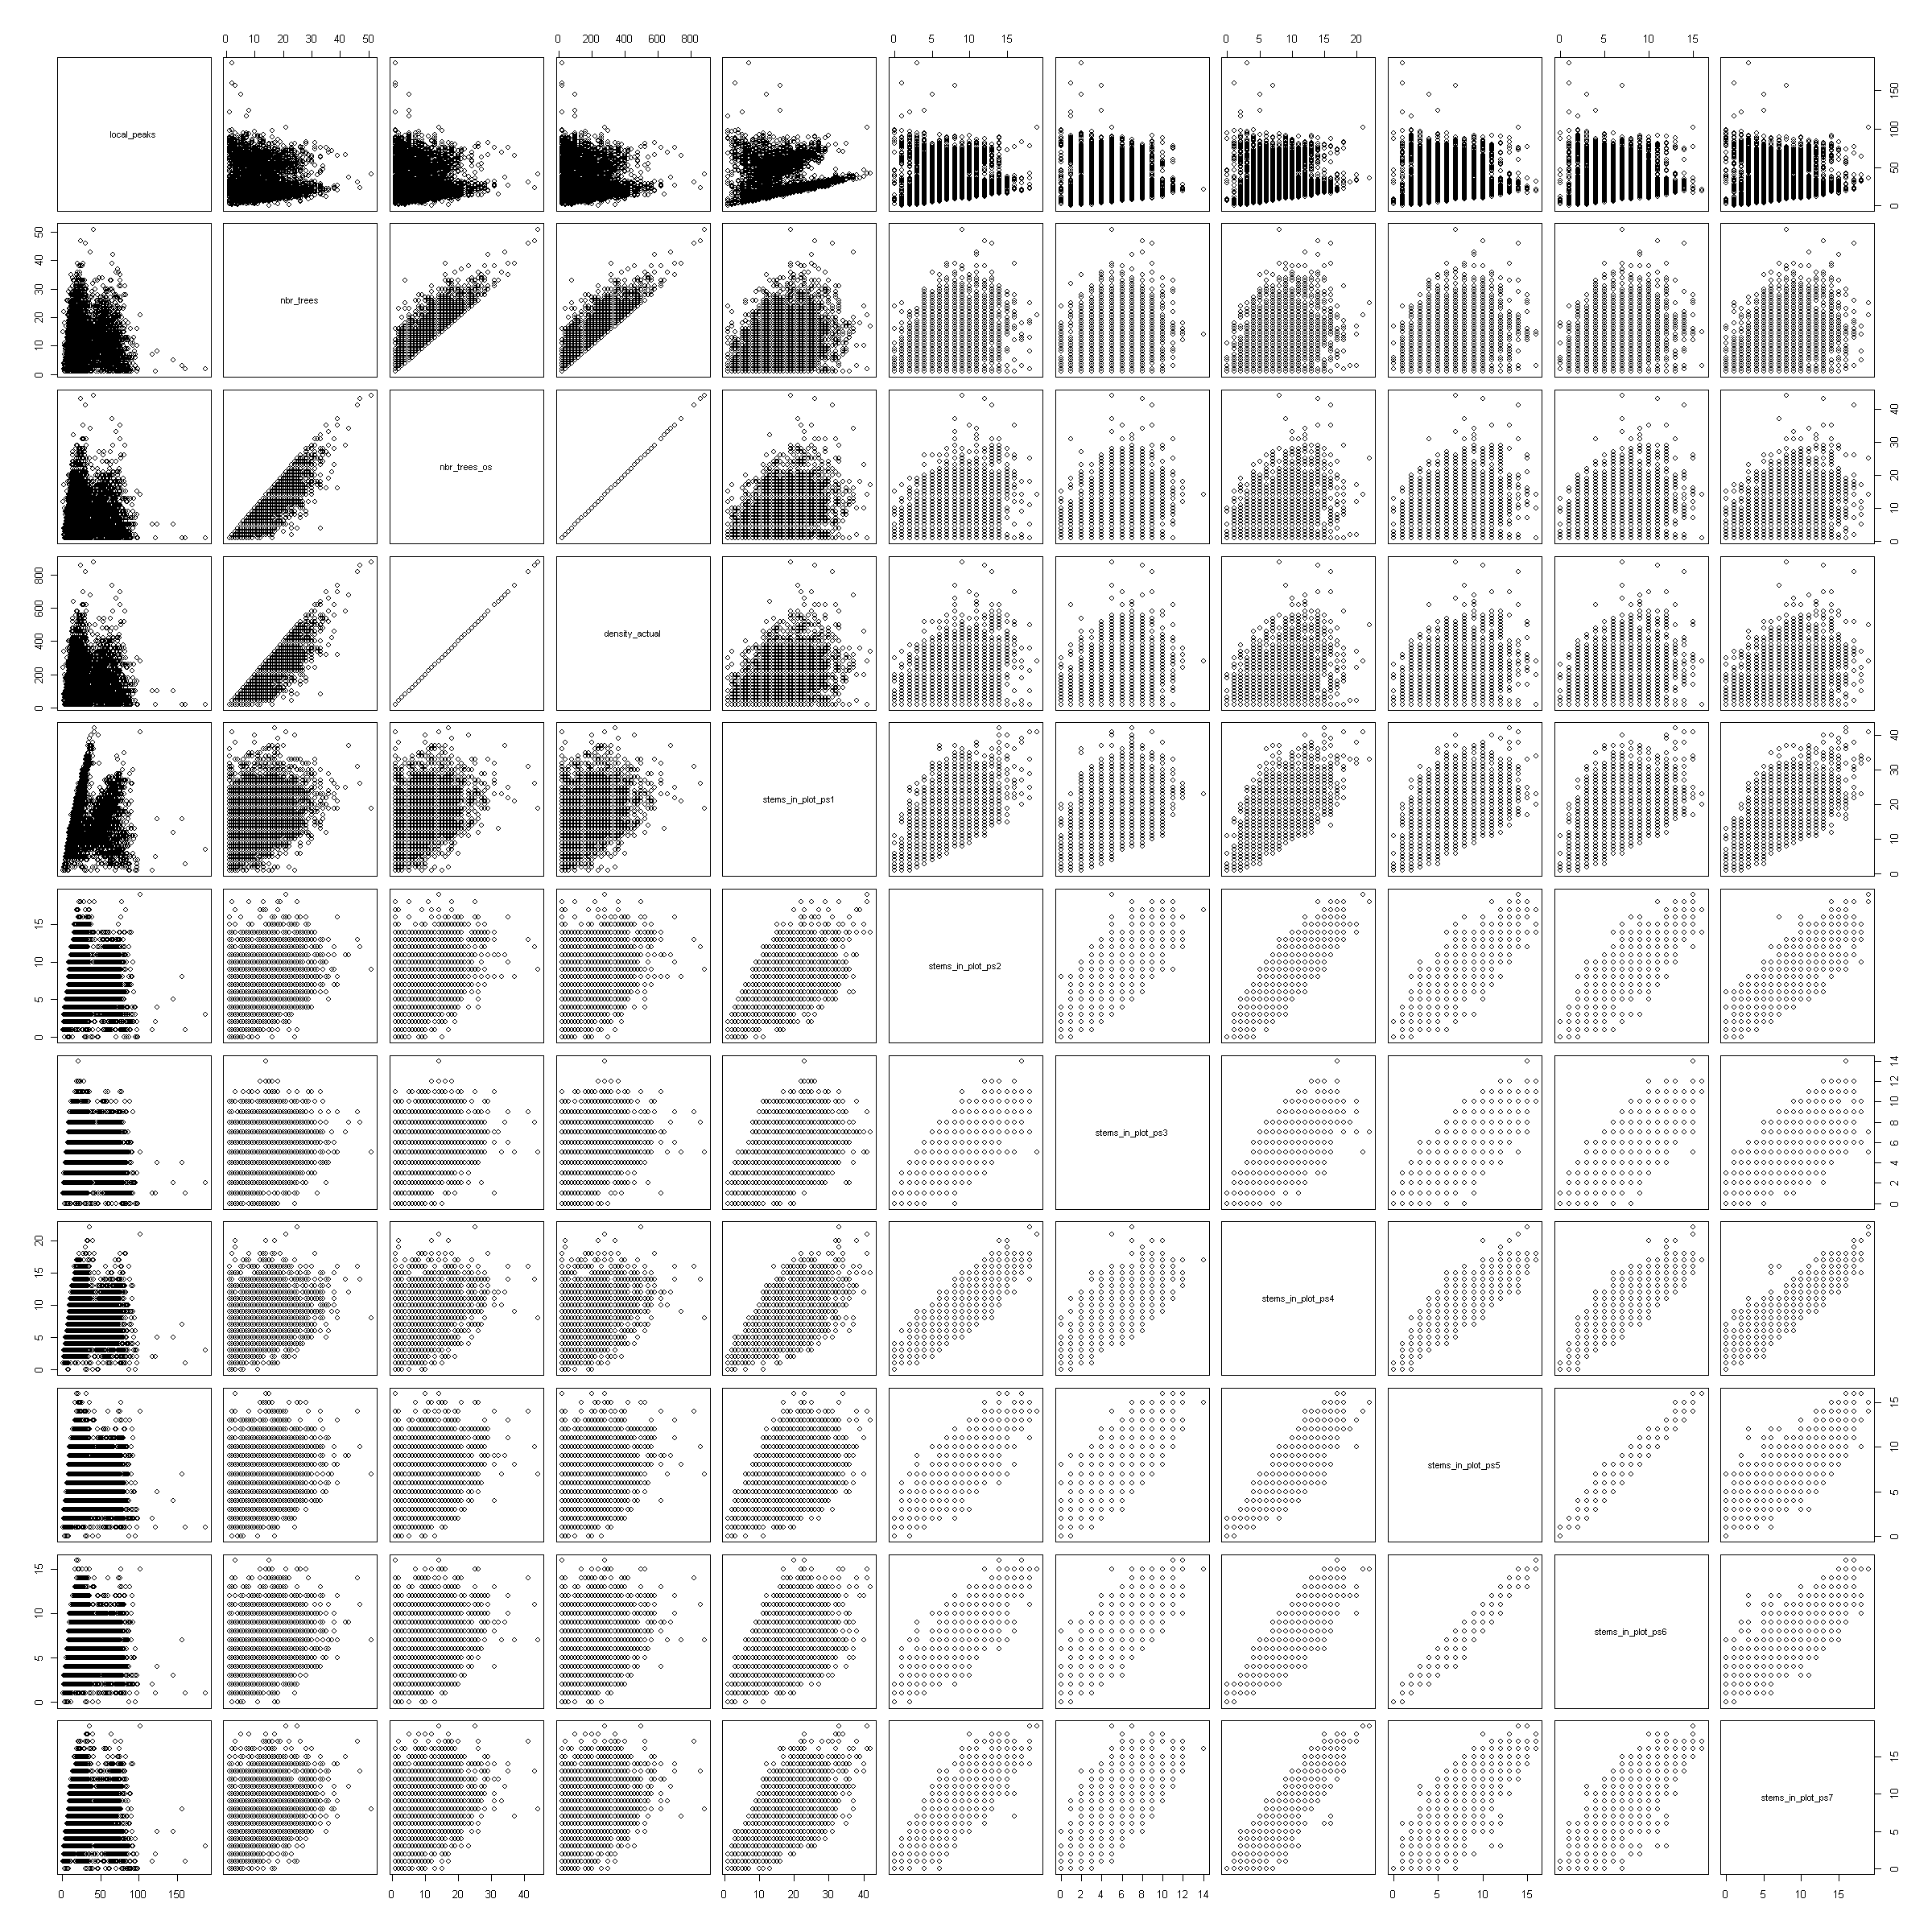

In [19]:
options(repr.plot.width=20, repr.plot.height=20)

pairs(lfi_trees_grouped[,c( 'local_peaks', 'nbr_trees', 'nbr_trees_os', 'density_actual', 
 'stems_in_plot_ps1', 'stems_in_plot_ps2', 'stems_in_plot_ps3', 'stems_in_plot_ps4', 'stems_in_plot_ps5', 'stems_in_plot_ps6', 'stems_in_plot_ps7')])

<a id="Classification_Model"></a>
## Classification Model

<a id="Common_Functions"></a>
### Common Functions

In [20]:
#Setting input data
target_col = 'stems_per_ha_err_ps1'
cols_complete = c(  'slope_sin', 'aspect_sin', 'northness', 'eastness', 'z', 'veg_code', 
  'fst', 'fst_nh', 'fst_dg', 'fst_hdom',
  'dg', 'hdom', 'nh', 
  'dg_ks', 'dg_us', 'dg_ms', 'dg_os', 'dg_ueb', 
  'tri_min', 'tri_max', 'tri_mean', 'tri_median', 'tri_std', 
  'tpi_min', 'tpi_max', 'tpi_mean', 'tpi_median', 'tpi_std', 
  'waldrand', 'bestandesgrenze','local_peaks'
 ) 

In [21]:
#Function for partitioning data into calibration/validation
get_partitions <- function(target_col, data=lfi_trees_grouped, x_columns=cols_complete, calibration_size=0.8, random_state=42){
    set.seed(random_state)
    data_filtered <- data[!is.na(data[,target_col]),]
    in_calibration <- createDataPartition(data_filtered[,target_col], p = calibration_size)
    cols_combined = c(x_columns, target_col)
    return(list(
        in_calibration = in_calibration[[1]],
        calibration = data_filtered[in_calibration[[1]],cols_combined],
        validation = data_filtered[-in_calibration[[1]],cols_combined]
    ))
}


In [22]:
#Function for generrating a string representation of a fitted linear model
#Based on https://stats.stackexchange.com/a/433060
model_equation <- function(model, ...) {
  format_args <- list(...)
  
  model_coeff <- model$coefficients
  format_args$x <- abs(model$coefficients)
  model_coeff_sign <- sign(model_coeff)
  model_coeff_prefix <- case_when(model_coeff_sign == -1 ~ " - ",
                                  model_coeff_sign == 1 ~ " + ",
                                  model_coeff_sign == 0 ~ " + ")
  model_eqn <- paste(strsplit(as.character(model$call$formula), "~")[[2]], # 'y'
                     "=",
                     paste(if_else(model_coeff[1]<0, "- ", ""),
                           do.call(format, format_args)[1],
                           paste(model_coeff_prefix[-1],
                                 do.call(format, format_args)[-1],
                                 " * ",
                                 names(model_coeff[-1]),
                                 sep = "", collapse = ""),
                           sep = ""))
  return(model_eqn)
}

In [23]:
#Function for generating a list with string representations of the fitted models in a composite model
#Intended for examining the underlying linear models
gather_model_equations <- function(model_list, classes, target_prefix, digits = 3) {
    res <- list()
    for (i in 1:length(classes)){
        class <- classes[i]
        target_column <- paste(target_prefix,class,sep="")

        model <- model_list[[class]]
        model_formula <- model_equation(model$finalModel, digits = digits)
        model_formula <- gsub(".outcome", target_column, model_formula)
        res <- rbind(res,model_formula)
    }
    return(res)
}

In [24]:
#For lookup purposes when applying FST expert approach
fst_parameterset_mappings <- structure(c(2,2,7,16,
                                         2,16,7,16,
                                         16,16,16,16), 
                                names=c("111","112","121","122",
                                 "211","212","221","222",
                                 "311","312","321","322") ) 

<a id="Variable_Selection"></a>
### Variable selection for linear error models

In [25]:
#Variables for selection
cols_reduced = c(  
  'slope_sin', 'northness', 'eastness', 'z', 
  'dg', 'hdom', 'nh', 
  'dg_ks', 'dg_us', 'dg_ms', 'dg_os', 'dg_ueb', 
  'tri_min', 'tri_max', 'tri_mean', 'tri_median', 'tri_std', 
  'tpi_min', 'tpi_max', 'tpi_mean', 'tpi_median', 'tpi_std', 
  'local_peaks'
 ) 

In [26]:
#Function for performing a variable importance analysis for a specified pre-processing filter
variable_importance_analysis <- function(method='ps1') {
    #Variable Importance from a linear model with reduced columns and repeated CV
    target <- paste('stems_per_ha_err_',method,sep="")
    data <- lfi_trees_grouped[c(cols_reduced,target)]

    # ensure results are repeatable
    set.seed(42)
    # prepare training scheme
    control <- trainControl(method="repeatedcv", number=10, repeats=3)
    # calibrate/train the model
    model_lm_psx <- train(formula(paste(target,"~.",sep="")), data=data, method="lm", preProcess="scale", trControl=control)
    # estimate variable importance
    importance <- varImp(model_lm_psx, scale=FALSE)
    # summarize importance
    return(importance)    
}

In [27]:
#Perform a variable importance analysis for all pre-processing filters
importance_list <- vector(mode = "list", length = 19)
for (i in 1:19) {
    filter <- paste0("ps",i)
    imp <- variable_importance_analysis(filter)
    imp <- imp$importance
    names(imp) <- filter
    importance_list[[i]] <- imp
}

importance_matrix <- do.call("cbind",importance_list)

In [28]:
#Determine the count of variables with importance variables above the set threshold
importance_threshold <- 2.5
importance_matrix$relevance_count <- 0
importance_matrix$relevance_count  <- apply(importance_matrix, 1, function(x) sum(x>importance_threshold))
importance_matrix

,ps1,ps2,ps3,ps4,ps5,ps6,ps7,ps8,ps9,ps10,ps11,ps12,ps13,ps14,ps15,ps16,ps17,ps18,ps19,relevance_count
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
slope_sin,0.9123576,2.7294463,0.9580958,3.1055372,2.8486865,2.82744584,2.5333038,0.004829167,1.1109513,2.19934824,0.09354951,1.16121290,1.55878895,2.2145549,2.7290694,3.5831121,1.4213704,3.7929061,3.71894461,9
northness,7.1620561,6.9114387,7.0925662,7.0022142,7.1262527,7.13011136,6.8922377,7.549760006,7.1508657,6.72504190,7.72704193,7.02135896,7.44511218,7.2181588,7.5274533,6.4990137,6.6309722,6.6020937,6.61768415,19
eastness,1.7982758,0.2432306,0.2364595,0.2406828,0.4716143,0.39831648,0.8327272,0.578945968,0.2375165,0.89112596,0.26346511,0.09747089,0.07665402,0.1908321,0.1326453,0.8559422,0.8227556,0.9341473,0.84571611,0
z,9.9785892,4.6502197,3.6070308,5.6338350,3.8031238,3.68440364,5.3949349,3.861529465,3.2859847,5.74748392,4.21609959,4.16653528,4.37745369,4.2414485,4.4011861,5.7908844,4.0234706,6.0142588,6.15458641,19
dg,3.6360305,7.0790655,6.7427429,7.2320263,7.7729946,7.70772164,4.9127310,6.614263546,6.1938263,2.00142879,6.13632532,5.70657556,4.41477779,5.1691711,5.3434236,6.3424478,6.7948886,6.9599330,6.80515716,18
hdom,3.6972814,9.1050200,6.9402071,9.5583778,8.3359278,8.20305577,9.0097019,6.487612539,5.4523460,8.17792637,6.90978985,5.90565405,3.91520883,3.8309437,3.7160685,9.0443979,6.6101601,9.4200411,9.45169732,19
nh,17.5216545,8.9942701,10.3041633,8.6463470,9.2516769,9.37347846,9.3805904,11.865519280,12.6025180,10.02260716,12.07679484,13.06062860,12.69107277,13.9824720,14.6338705,8.9613214,10.4609528,9.1871728,9.24932688,19
dg_ks,10.7191863,1.5060012,1.6007756,1.9391561,0.1295270,0.00212786,1.8466478,1.876068937,3.4081803,1.30502542,1.07982227,2.90816888,3.43182636,4.8011843,5.2940768,3.0017121,0.7881096,3.6538920,3.76760248,9
dg_us,2.0571332,2.0151056,3.4990158,1.8814668,2.5379467,2.58759839,1.5402498,3.500669507,4.1988962,0.83183703,2.94617782,3.83209697,4.39065777,5.3393788,5.6362568,1.4124285,2.8951522,0.9905536,0.90750856,11


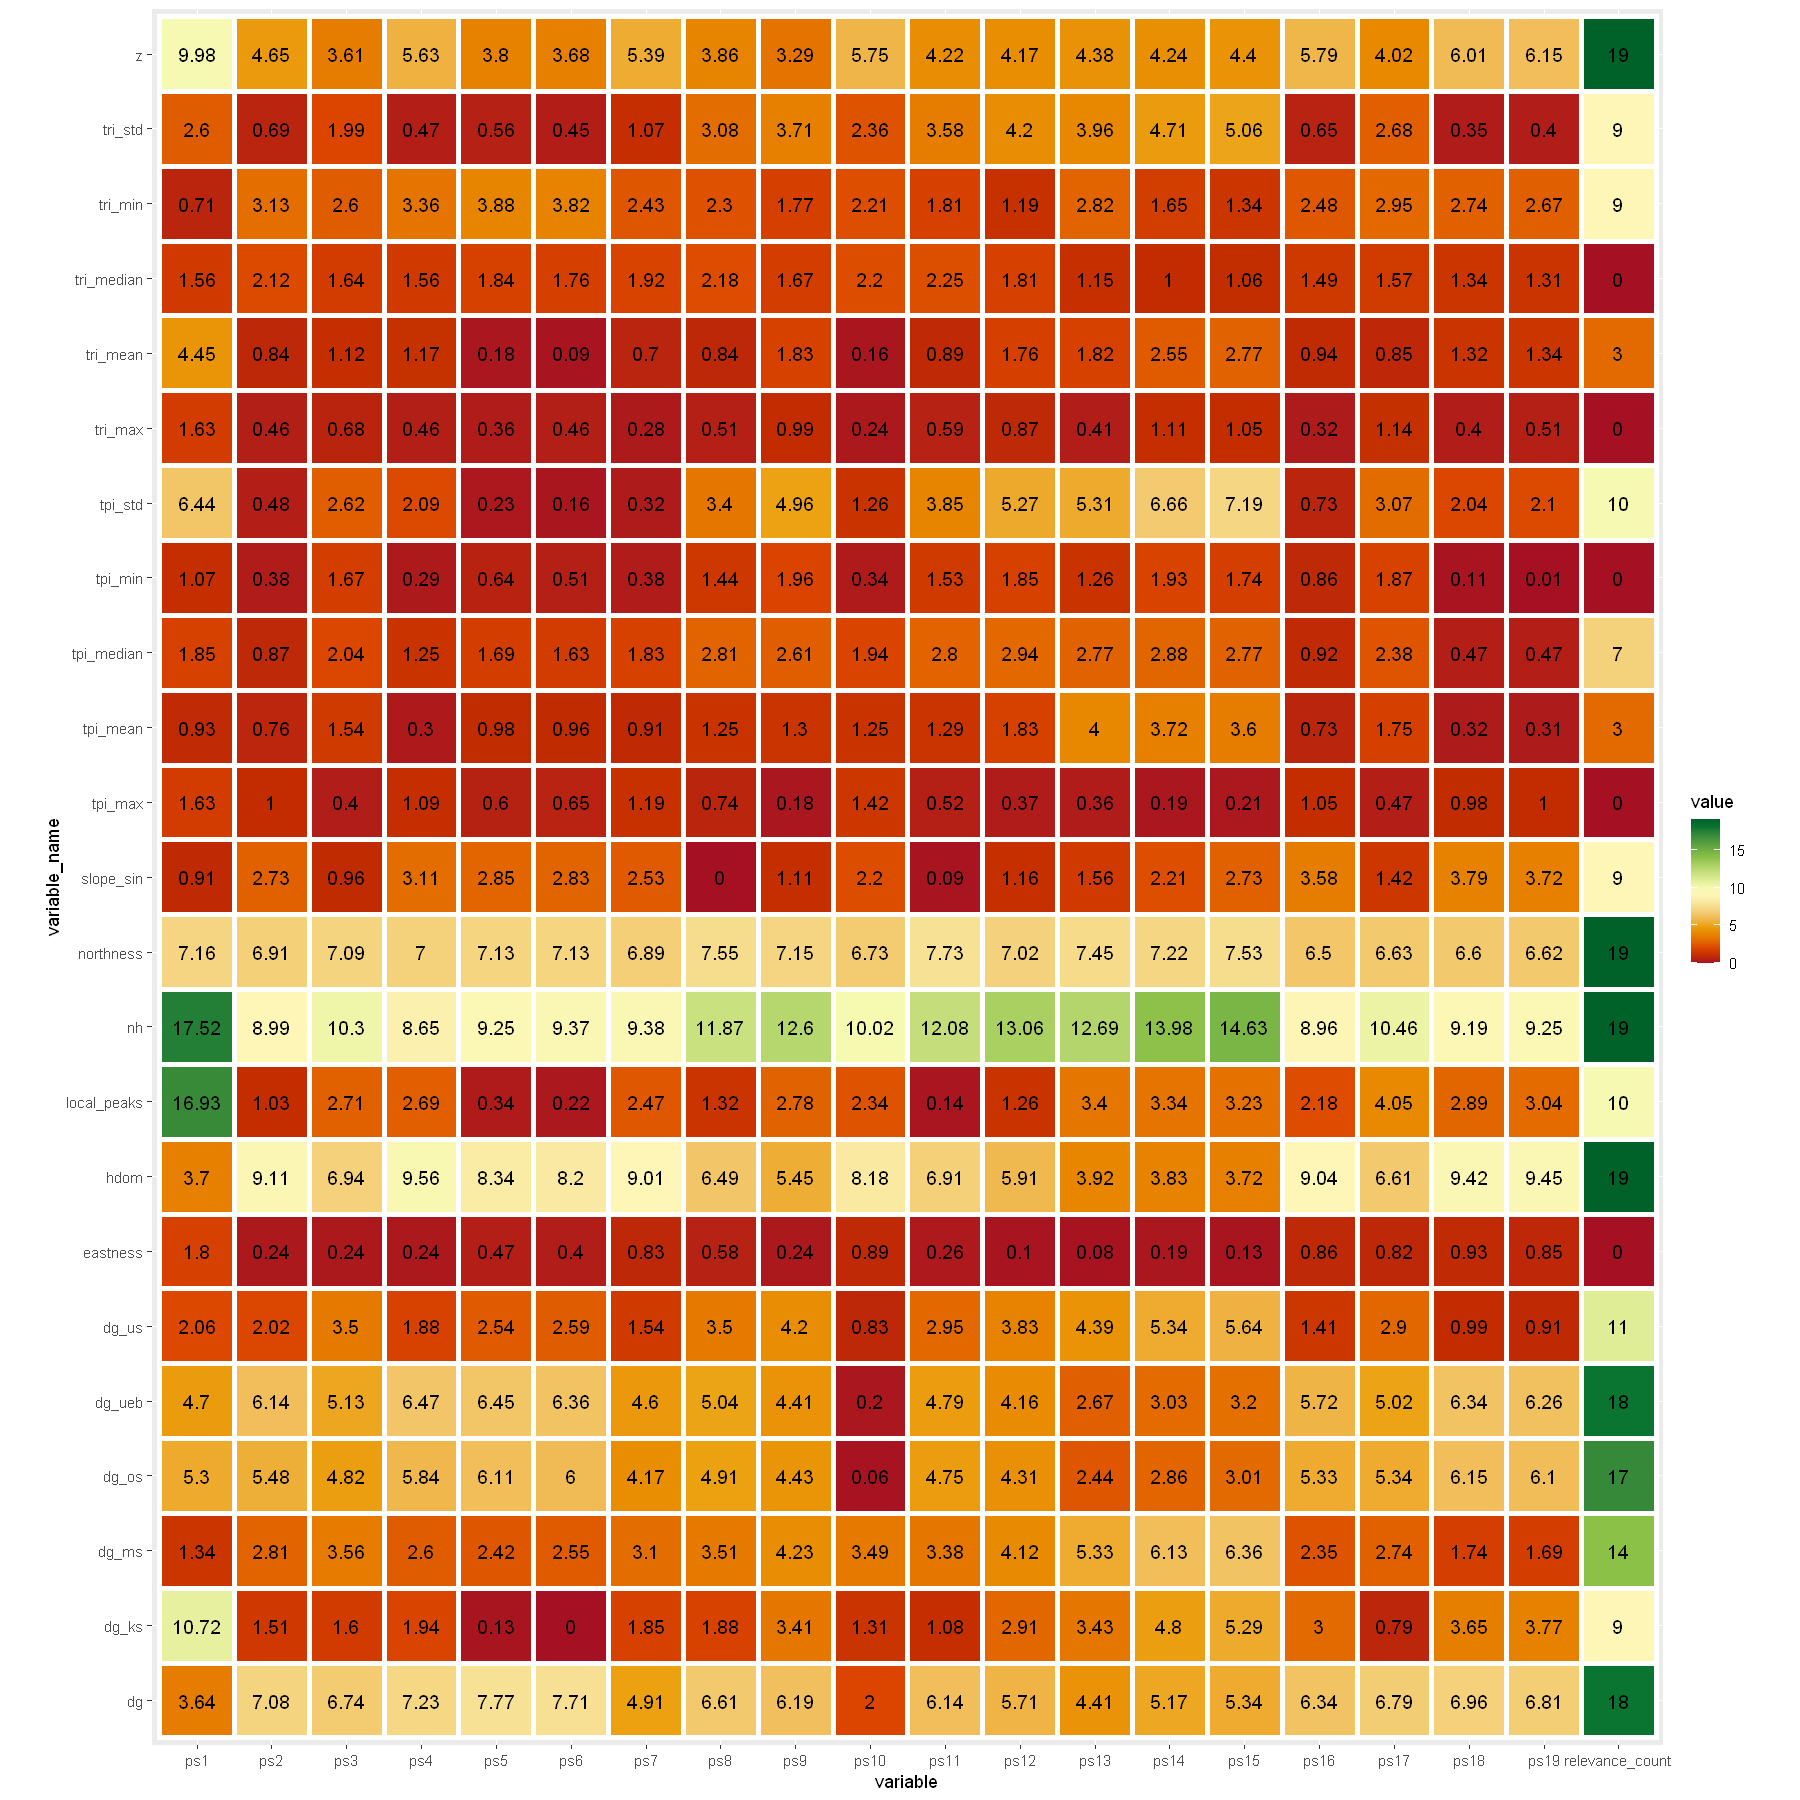

In [29]:
#Visualize the importance of the variables
options(repr.plot.width=15, repr.plot.height=15)
importance_matrix$variable_name <- rownames(importance_matrix)
importance_matrix_melt <- reshape2::melt(importance_matrix, id.vars="variable_name")
importance_matrix_melt$value <- round(importance_matrix_melt$value,2) 
ggplot(importance_matrix_melt, aes(x = variable, y = variable_name, fill = value)) +
  geom_tile(color = "white",
            lwd = 1.5,
            linetype = 1) +
  geom_text(aes(label = value), color = "black", size = 4) +
  scale_fill_gradientn(colors = hcl.colors(20, "RdYlGn")) +
  coord_fixed()

In [30]:
#Output the variables that are relevant for at least one filter 
count_threshold <- 0
rownames(importance_matrix[importance_matrix$relevance_count > count_threshold,])

[1] "slope_sin"   "northness"   "z"           "dg"          "hdom"       
 [6] "nh"          "dg_ks"       "dg_us"       "dg_ms"       "dg_os"      
[11] "dg_ueb"      "tri_min"     "tri_mean"    "tri_std"     "tpi_mean"   
[16] "tpi_median"  "tpi_std"     "local_peaks"

## Generate Subsets and Calibration/Validation Partitions

In [31]:
# All plots
lfi_trees_grouped_full <- lfi_trees_grouped
partitions_all <- get_partitions("perimeter_id", data=lfi_trees_grouped_full)
lfi_trees_grouped_calibration <- lfi_trees_grouped_full[partitions_all$in_calibration,]
lfi_trees_grouped_validation <- lfi_trees_grouped_full[-partitions_all$in_calibration,]
print(c("nrow lfi_trees_grouped_full ",nrow(lfi_trees_grouped_full)))
print(c("nrow lfi_trees_grouped ",nrow(lfi_trees_grouped_calibration)))
print(c("nrow lfi_trees_grouped_validation ",nrow(lfi_trees_grouped_validation)))


# Without plots whose ALS date was acquired before 2010
lfi_trees_grouped_ss1_full <- lfi_trees_grouped_full[(lfi_trees_grouped_full$VHM_Tile_Year>=2010),]
partitions_ss1 <- get_partitions("perimeter_id", data=lfi_trees_grouped_ss1_full)
lfi_trees_grouped_ss1_calibration <- lfi_trees_grouped_ss1_full[partitions_ss1$in_calibration,]
lfi_trees_grouped_ss1_validation <- lfi_trees_grouped_ss1_full[-partitions_ss1$in_calibration,]
print(c("nrow lfi_trees_grouped_ss1_full ",nrow(lfi_trees_grouped_ss1_full)))
print(c("nrow lfi_trees_grouped_ss1 ",nrow(lfi_trees_grouped_ss1_calibration)))
print(c("nrow lfi_trees_grouped_ss1_validation ",nrow(lfi_trees_grouped_ss1_validation)))

      
# Only plots after 2010 and with a difference of less than 7 years between the ALS acquisition and the field acquisition
lfi_trees_grouped_ss2_full <- lfi_trees_grouped_full[(lfi_trees_grouped_full$VHM_Tile_Year>=2010) & (lfi_trees_grouped_full$acquisition_diff_abs<7),]
partitions_ss2 <- get_partitions("perimeter_id", data=lfi_trees_grouped_ss2_full)
lfi_trees_grouped_ss2_calibration <- lfi_trees_grouped_ss2_full[partitions_ss2$in_calibration,]
lfi_trees_grouped_ss2_validation <- lfi_trees_grouped_ss2_full[-partitions_ss2$in_calibration,]
print(c("nrow lfi_trees_grouped_ss2_full ",nrow(lfi_trees_grouped_ss2_full)))
print(c("nrow lfi_trees_grouped_ss2 ",nrow(lfi_trees_grouped_ss2_calibration)))
print(c("nrow lfi_trees_grouped_ss2_validation ",nrow(lfi_trees_grouped_ss2_validation)))


[1] "nrow lfi_trees_grouped_full " "5254"                        
[1] "nrow lfi_trees_grouped " "4206"                   
[1] "nrow lfi_trees_grouped_validation " "1048"                              
[1] "nrow lfi_trees_grouped_ss1_full " "3797"                            
[1] "nrow lfi_trees_grouped_ss1 " "3040"                       
[1] "nrow lfi_trees_grouped_ss1_validation "
[2] "757"                                   
[1] "nrow lfi_trees_grouped_ss2_full " "2676"                            
[1] "nrow lfi_trees_grouped_ss2 " "2144"                       
[1] "nrow lfi_trees_grouped_ss2_validation "
[2] "532"                                   


In [32]:
summary(lfi_trees_grouped_calibration$VHM_Tile_Year)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2001    2005    2018    2014    2019    2020 

In [33]:
summary(lfi_trees_grouped_validation$VHM_Tile_Year)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2001    2005    2017    2013    2019    2020 

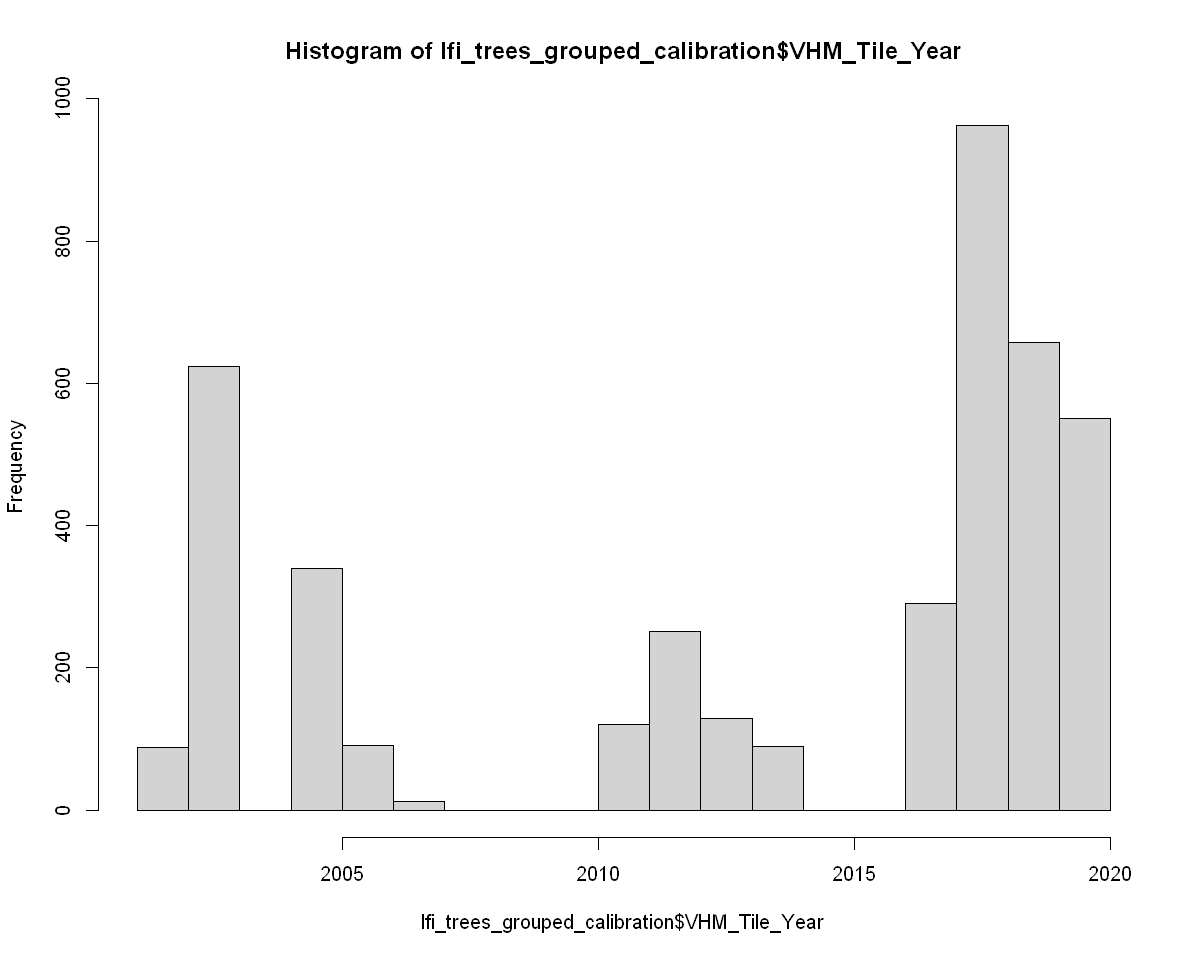

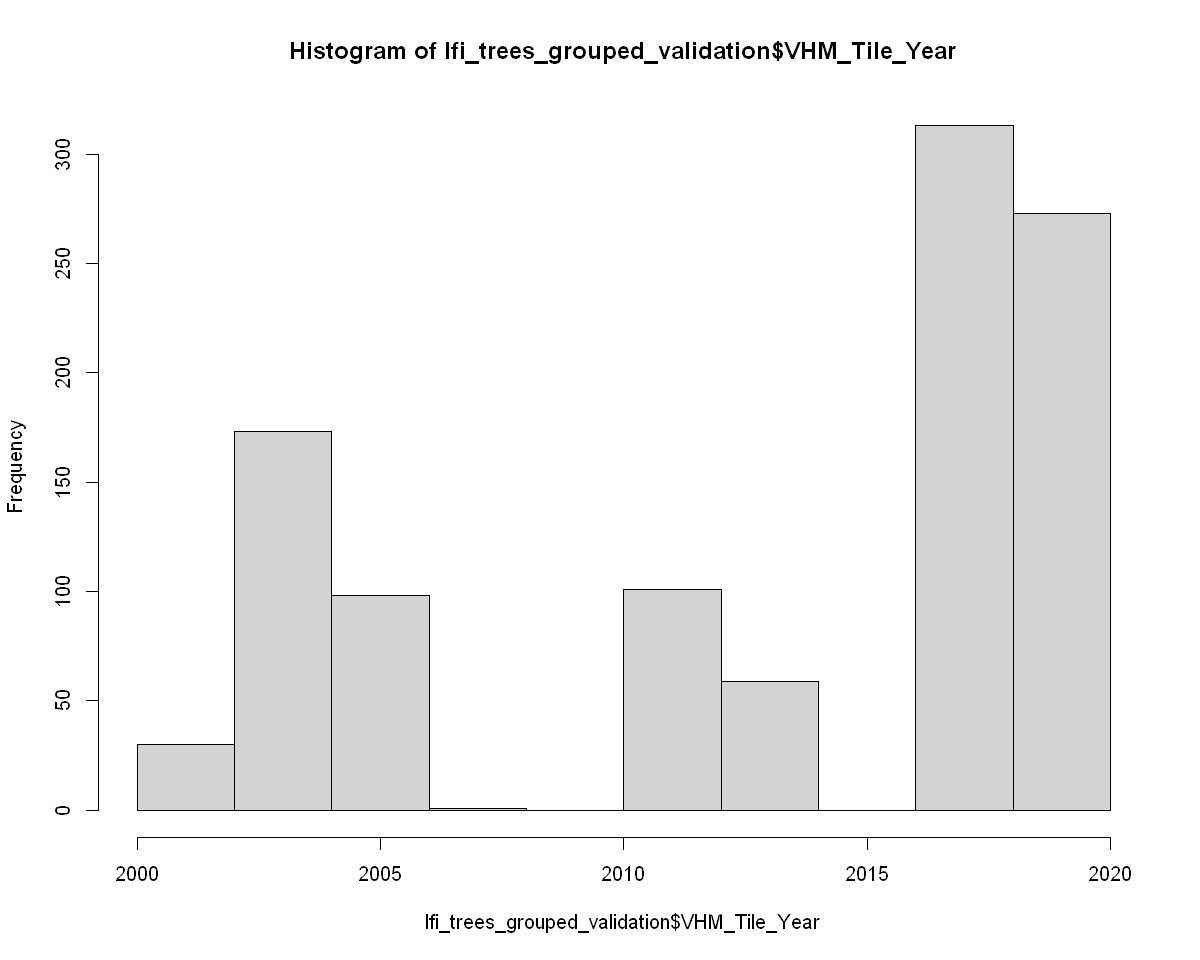

In [34]:
options(repr.plot.width=10, repr.plot.height=8)

hist(lfi_trees_grouped_calibration$VHM_Tile_Year)
hist(lfi_trees_grouped_validation$VHM_Tile_Year)

<a id="Composite_Model"></a>
## Composite Model

An attempt to integrate the composite model with caret failed. This is mostly due to the fact that handling multiply y values as input doesn't seem to be possible. Furthermore, the mox between regression and classification lite it is used here, seem also to be outside of caret's scope. Therefore two seperate methods fitting and predicting the model were created. The fitting method fintch.composite.fit() uses caret under the hood to fit a regression model for the specified classes and returns an object containing the trained models and necessary parameters for prediction. The fintch.composite.predict() method uses that fitted model object along with new input data to make the actual predictions.  

In [35]:
# Method for fitting a composite mode for the specified Date and filter methods
# x: data containing the explanatory data
# y: Data containing the error values to be used as target for the models. Must contain a column per filter method.
# targets: Vector with the numbers of the filter methods to be used in the model
# target_prefix: string prefix for the error measure to be used (e.g. "stems_in_plot_err_ps")
# cv: number of folds for training the individual error models
# method: method used to fit the error models (lm, leap, lasso, ridge, rf)
# direction: direction for leap method (forwart, backward, both)
# dynamic: whether to use stepAIC or a fixed formula for the method lm
# nvmax: max number of variables chosen by leap method
# mtry: mtry value for rf method
fintch.composite.fit <- function(x, y, targets, target_prefix, cv, method="lm", direction="forward",  dynamic=TRUE, nvmax=5, mtry=10) { 
    #Fit model per method/column in y
    models <- list()

    for(i in 1:length(targets)) {                        
        #Get taret name/method 
        target_name <-  targets[i]

        #Get corresponding column
        target_col <- paste(target_prefix, target_name, sep="")
        y_target <- y[target_col]
        
        x_calibration <- cbind(x,y_target)
        x_calibration <- x_calibration[!is.na(x_calibration[target_col]),]

        
        #Perform sequential feature selection on base learner
        control <- trainControl(method="repeatedcv", number=cv, repeats=3, allowParallel=TRUE)
        if (dynamic) {
            model_string <- paste(target_col,"~.",sep="")                                                
        } else {
#             model_string <- paste(target_col,"~ slope_sin+northness+z+dg+hdom+nh+dg_ks+dg_us+dg_ms+dg_os+dg_ueb+tri_mean+tri_std+tpi_mean+tpi_std+local_peaks",sep="")                                                
#             model_string <- paste(target_col,"~ slope_sin+northness+z+dg+hdom+nh+dg_ks+dg_us+dg_ms+dg_os+dg_ueb+tri_mean+tri_median+tri_std+tpi_mean+tpi_median+tpi_std+local_peaks",sep="")   
#             model_string <- paste(target_col,"~ slope_sin+northness+z+dg+hdom+nh+dg_ks+dg_us+dg_ms+dg_os+dg_ueb+tri_min+tri_std+tpi_median+tpi_std+local_peaks",sep="")   
            model_string <- paste(target_col,"~ slope_sin+northness+z+dg+hdom+nh+dg_ks+dg_us+dg_ms+dg_os+dg_ueb+tri_min+tri_mean+tri_std+tpi_mean+tpi_median+tpi_std+local_peaks",sep="")   
        }
        if (method=="lm") {
            if (dynamic) {
                modelFit <- train(formula(model_string), data = x_calibration, method = "lmStepAIC", trControl=control, direction = direction, trace = FALSE)
            } else {
                modelFit <- train(formula(model_string), data = x_calibration, method = "lm", trControl=control)
            }
        } else if (method=="leap") {
            if (direction=="forward"){
                mthd <-"leapForward"
            } else if (direction=="backward") {
                mthd<-"leapBackward"
            } else {
                mthd <- "leapSeq"
            }
            modelFit <- train(formula(model_string), data = x_calibration, method = mthd, trControl=control, tuneGrid = data.frame(nvmax = nvmax))
            # modelFit <- train(formula(model_string), data = x_calibration, method = method, trControl=control, tuneGrid = data.frame(nvmax = nvmax))
        } else if (method=="lasso") {
            modelFit<-train(formula(model_string), data = x_calibration, method = 'glmnet', tuneGrid = expand.grid(alpha = 1, lambda = 1), trControl=control) 
        } else if (method=="ridge") {
            modelFit<-train(formula(model_string), data = x_calibration, method = 'glmnet', tuneGrid = expand.grid(alpha = 0, lambda = 1), trControl=control)
        } else if (method=="rf") {
            control <- trainControl(method="none", number=1, allowParallel=TRUE)
            modelFit<-train(formula(model_string), data = x_calibration, method = 'rf', tuneGrid = expand.grid(.mtry = mtry), trControl=control)
        }     
            
        models[target_name] = list(modelFit)                        
    }

    ret <- list(models=models, target_names=targets)
    class(ret) <- "FINT_CH_CompositeModel"
    return(ret)                  
}

# Method for predicting the filter method based on a FINT_CH_CompositeModel model object
# generated by the fintch.composite.fit function.
# modelFit: FINT_CH_CompositeModel object
# newdata: data to be used for prediction
# return_raw: if TRUE, the method returns the predicted errors for all methods instead of the classes
fintch.composite.predict <- function(modelFit, newdata, return_raw=FALSE) {       
    models <- modelFit$models
    target_names <- modelFit$target_names

    predictions <- list()

    #Predict for all methods
    for(i in 1:length(target_names)) { 
        key <- target_names[i]
        clf <- models[key]
        pred <- predict(clf,newdata)
        predictions[key] <- pred
    }

    #Pick "optimal" method based on predictions

    pred_df <- as.data.frame(do.call("cbind",predictions))
    colnames(pred_df)<-target_names

    if(return_raw) {
        return(pred_df)
    }
        
    res <- apply(abs(pred_df), 1, which.min)

    ret <- colnames(pred_df)[res]
    return(ret)
}


Since caret can't be used for cross validation of the composite model, a custom function for that burpose has been created. The CV function is inspired both by caret and by sklearn. It uses a custom scoring function returning several scores for both the model itself as well as for the baseline 1m detection. Note, however, that the Earth Mover's Distance seems to be calculated slightly different so that the R values should not be directly compared with the Python values.

In [36]:
#Create empty dataframe matching the scorer output
make_scorer_df <- function (n_folds) 
{
    return(data.frame(rmse_baseline = rep(NA, n_folds), rmse_norm_baseline = rep(NA, n_folds), rmse = rep(NA, n_folds), rmse_norm = rep(NA, n_folds), 
                      
                      dr_baseline = rep(NA, n_folds),  dr = rep(NA, n_folds), 
                      mae_baseline = rep(NA, n_folds),  mae = rep(NA, n_folds), 
                      acc = rep(NA, n_folds), acc_adj = rep(NA, n_folds), acc_baseline_adj = rep(NA, n_folds), 
        y_pred_unique_count = rep(NA, n_folds)

                     ))
}

#Method for calculating a number of scores for the models in the CV functions
detection_scorer <- function(test_data, y, predicted_classes, input_classes=c(1,2,3,7,8,9,4,5,6,10,11,12,13,14,15,16,17,18,19))
{    
    
    #The 1m detection is regarded as baseline
    rmse_baseline <- sqrt(mean(unlist(test_data["stems_per_ha_rs_ps1"])))

    #The 1m detection is regarded as baseline
    mae_baseline <- mean(unlist(test_data["stems_per_ha_ae_ps1"]))

    
    ##Getting densities according to predicted method
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_rs_ps",as.character(x),sep="")) 
    se<-sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )
    rmse <- sqrt(mean(se))
    
                                   
    #The 1m detection is regarded as baseline
    dr_baseline <- sqrt(mean(unlist(test_data["dr_ps1"])))

    ##Getting densities according to predicted method
    y_pred_ind <- lapply(predicted_classes, function(x) paste("dr_ps",as.character(x),sep="")) 
                         
    dr_raw <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )
    dr <- mean(dr_raw)

                             
    # Model accuracy
    acc <- mean(predicted_classes == y)
                                        
    label_df <- determine_min_labels(test_data, output_prefix="psx", input_classes=input_classes)
    y_pred_ind <- lapply(predicted_classes, function(x) paste("psx",as.character(x),sep="")) 
    se<-sapply(seq_along(y_pred_ind), function(x) label_df[x, y_pred_ind[[x]]] )
    acc_adj <- sum(se)/length(se)    
               
    se_baseline <- label_df[,"psx1"]
    acc_baseline_adj <- sum(se_baseline)/length(se_baseline) 
                        
    #Normalized RMSE
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_in_plot_err_norm_ps",as.character(x),sep="")) 
    stems_per_ha <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    rmse_norm <- sqrt(mean(stems_per_ha^2,na.rm=TRUE))
    
    norm_error_baseline <- test_data[,"stems_in_plot_err_norm_ps1"]
    rmse_norm_baseline <- sqrt(mean(norm_error_baseline^2,na.rm=TRUE))          

                        
          
    #MAE
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_in_plot_ae_ps",as.character(x),sep="")) 
    stems_per_ha_ae <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    mae <- mean(stems_per_ha_ae,na.rm=TRUE)
                           
                           
    #R2
    r2_score <- R2(as.numeric(predicted_classes), as.numeric(y))
                      
    #predicted class count
    y_pred_unique_count <- length(unique(predicted_classes))
                             
    return(list(rmse_baseline=rmse_baseline,
        rmse_norm_baseline = rmse_norm_baseline,
        rmse=rmse,
        rmse_norm = rmse_norm,
      
        dr_baseline=dr_baseline,
        dr=dr,
                
        mae_baseline = mae_baseline,
        mae = mae,
        acc=acc,
        acc_adj=acc_adj,
        acc_baseline_adj=acc_baseline_adj,
        y_pred_unique_count=y_pred_unique_count
      )
    )
}

#Method for collecting raw data for more detailed scoring calculations the models in the CV functions
scoring_data_collector <- function(test_data, y, predicted_classes, input_classes=c(1,2,3,7,8,9,4,5,6,10,11,12,13,14,15,16,17,18,19))
{   
    #General values
    data_raw <- test_data[,c("flaeche_id","dg","nh","hdom","fst_dg","fst_nh","fst_hdom","density_actual","density_actual_all","nbr_trees", "nbr_trees_os")]
    
    #Values for baseline detection
    data_raw$stems_per_ha_baseline <- test_data$stems_per_ha_ps1
    data_raw$dr_baseline <- test_data$dr_ps1
    data_raw$stems_per_ha_rs_baseline <- test_data$stems_per_ha_rs_ps1
    data_raw$predicted <- predicted_classes
    
    label_df <- determine_min_labels(test_data, output_prefix="psx", input_classes=input_classes)
    data_raw$prediction_accurate_baseline <- label_df[,"psx1"]
    data_raw$stems_in_plot_err_norm_baseline <-  test_data$stems_in_plot_err_norm_ps1
    data_raw$stems_in_plot_abs_err_baseline <-  test_data$stems_in_plot_ae_ps1
    data_raw$stems_in_plot_err_baseline <- test_data$stems_in_plot_err_ps1
    data_raw$stems_per_ha_err_baseline <- test_data$stems_per_ha_err_ps1
    data_raw$stems_per_ha_abs_err_baseline <- test_data$stems_per_ha_ae_ps1
    data_raw$stems_per_ha_abs_err_norm_baseline <- test_data$stems_per_ha_ae_ps1/test_data$density_actual
    
    data_raw$stems_in_plot_baseline = test_data$stems_in_plot_ps1
    
    #Values model
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_rs_ps",as.character(x),sep="")) 
    se_raw<-sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )
    data_raw$stems_per_ha_rs_model <- se_raw
                                   
    y_pred_ind <- lapply(predicted_classes, function(x) paste("dr_ps",as.character(x),sep=""))                  
    dr_raw <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )
    data_raw$dr_model <- dr_raw    
               
    y_pred_ind <- lapply(predicted_classes, function(x) paste("psx",as.character(x),sep="")) 
    se<-sapply(seq_along(y_pred_ind), function(x) label_df[x, y_pred_ind[[x]]] )   
    data_raw$prediction_accurate_model <- se
               
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_in_plot_err_norm_ps",as.character(x),sep="")) 
    stems_per_ha_err_norm <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_in_plot_err_norm_model <- stems_per_ha_err_norm
                           
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_ps",as.character(x),sep="")) 
    stems_per_ha <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_per_ha_model <- stems_per_ha
           
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_in_plot_ae_ps",as.character(x),sep="")) 
    stems_per_ae <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_in_plot_abs_err_model <- stems_per_ae

    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_ae_ps",as.character(x),sep="")) 
    stems_per_ha_ae <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_per_ha_abs_err_model <- stems_per_ha_ae                               

    data_raw$stems_per_ha_abs_err_norm_model <- stems_per_ha_ae/test_data$density_actual                            

    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_err_ps",as.character(x),sep="")) 
    stems_per_ha_err <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_per_ha_err_model <- stems_per_ha_err                               
    
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_in_plot_err_ps",as.character(x),sep="")) 
    stems_in_plot_err <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_in_plot_err_model <- stems_in_plot_err                               
    
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_in_plot_ps",as.character(x),sep="")) 
    stems_in_plot_model <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_in_plot_model <- stems_in_plot_model                               


                                  
    return(
        list(data_raw)
    )
}

In [37]:
# Function to returning scores based on the detection_scorer for a data set and a single trained composite model. 
fintch_composite_score <- function(model, scoring_in, y_column="parameterset_min") {
         
    #Predict and score model
    prediction <- fintch.composite.predict(modelFit=model,newdata=scoring_in)
    y <- scoring_in[,y_column]

    scores <- detection_scorer(scoring_in, y, prediction,input_classes=classes)        
    scoring_data <- scoring_data_collector(scoring_in, y, prediction,input_classes=model$target_names)


    return(list(scores=scores, scoring_data=scoring_data))
}



# Function to returning scores based on the detection_scorer for a data set and multiple trained composite model. 
fintch_composite_score_multi <- function(models, scoring_in, y_column="parameterset_min") {
    
    n_fold <- nrow(models)
    
    #Create empty df with structure for scoring function
    scores <- make_scorer_df(n_fold)
    scoring_data <- rep(NA, n_fold)
                     
    #Fit and score model for wach fold
    for (i in 1:n_fold) {
        model_comp_dyn <- models[i,]
                        
        #Predict and score model
        tmp_scores <- fintch_composite_score(model_comp_dyn, scoring_in, y_column=y_column)  
        
        scores[i,] <- tmp_scores$scores     
        scoring_data[i] <- tmp_scores$scoring_data

    }
    return(list(scores=scores, scoring_data=scoring_data))
}

In [38]:
#Helper functions for handling scoring results during analysis
concat_scoring_data <- function(df,col) { return(do.call(rbind,lapply(df, function(l) l[col]))) }
concat_scoring_data_group <- function(df,col,group,group_value) { return(do.call(rbind,lapply(df, function(l) l[l[,group]==group_value,][col]))) } 
concat_scoring_data_group_all <- function(df,group,group_value) { return(do.call(rbind,lapply(df, function(l) l[l[,group]==group_value,]))) } 
concat_scoring_data_by_fold <- function(df_calibration,df_validation,col,SEL) {
    n_fold <- length(df_calibration)
    res <- rep(NA,n_fold)
    for(i in 1:n_fold) {
        res[i] <- list(rbind(df_calibration[[i]][SEL(df_calibration[[i]]),][col],df_validation[[i]][SEL(df_validation[[i]]),][col]))
    }
    
    return(res)
}
                                                                                              
concat_scoring_data_simple <- function(df) {return(do.call(rbind,lapply(df, function(l) l)))}
                                                                                              
select_by_group <- function(df,group,group_value) {return(df[,group]==group_value)} 

                                                                               

In [39]:
# Function for scoring a dataframe that encompasses the indicators needed for the publication
detection_scorer_raw <- function(df,group_label)
{   
    rmse_baseline <- sqrt(mean(df$stems_per_ha_rs_baseline))
    rmse <- sqrt(mean(df$stems_per_ha_rs_model))
    
    sd_err_baseline <- sd(df$stems_per_ha_err_baseline)
    sd_err <- sd(df$stems_per_ha_err_model)
    
    rmse_norm_baseline <- sqrt(mean(df$stems_in_plot_err_norm_baseline^2,na.rm=TRUE))
    rmse_norm <- sqrt(mean(df$stems_in_plot_err_norm_model^2,na.rm=TRUE))
            
    sd_err_norm_baseline <- sd(df$stems_in_plot_err_norm_baseline)
    sd_err_norm <- sd(df$stems_in_plot_err_norm_model)
    
    mae_plot_baseline <- mean(df$stems_in_plot_abs_err_baseline,na.rm=TRUE)
    mae_plot_model <- mean(df$stems_in_plot_abs_err_model,na.rm=TRUE)
        
    mae_density_baseline <- mean(df$stems_per_ha_abs_err_baseline,na.rm=TRUE)
    mae_density_model <- mean(df$stems_per_ha_abs_err_model,na.rm=TRUE)
    
    mae_norm_density_baseline <- mean(df$stems_per_ha_abs_err_norm_baseline,na.rm=TRUE)
    mae_norm_density_model <- mean(df$stems_per_ha_abs_err_norm_model,na.rm=TRUE)

    median_ae_norm_density_baseline <- median(df$stems_per_ha_abs_err_norm_baseline,na.rm=TRUE)
    median_ae_norm_density_model <- median(df$stems_per_ha_abs_err_norm_model,na.rm=TRUE)

    mean_err_baseline <- mean(df$stems_per_ha_err_baseline,na.rm=TRUE)
    mean_err_model <- mean(df$stems_per_ha_err_model,na.rm=TRUE)

    median_err_baseline <- median(df$stems_per_ha_err_baseline,na.rm=TRUE)
    median_err_model <- median(df$stems_per_ha_err_model,na.rm=TRUE)
 
    dr_mean_baseline <- mean(df$dr_baseline)
    dr_median_baseline <- median(df$dr_baseline)
    
    dr_mean_model <- mean(df$dr_model)
    dr_median_model <- median(df$dr_model)

    acc_adjusted_baseline <- sum(df$prediction_accurate_baseline)/length(df$prediction_accurate_baseline)
    acc_adjusted_model <- sum(df$prediction_accurate_model)/length(df$prediction_accurate_model)
    
    cnt <- nrow(df)
  
    return ( data.frame(group=group_label, rmse=rmse, rmse_norm=rmse_norm, mae_plot_model=mae_plot_model, mae_density_model=mae_density_model, 
                        mae_norm_density_model=mae_norm_density_model, median_ae_norm_density_model=median_ae_norm_density_model, 
                        mean_err_model=mean_err_model, median_err_model=median_err_model,sd_err=sd_err, sd_err_norm=sd_err_norm,  dr_mean_model=dr_mean_model, dr_median_model=dr_median_model, acc_adjusted_model=acc_adjusted_model,
                        rmse_baseline=rmse_baseline, rmse_norm_baseline=rmse_norm_baseline, mae_plot_baseline=mae_plot_baseline, mae_density_baseline=mae_density_baseline, 
                        mae_norm_density_baseline=mae_norm_density_baseline, median_ae_norm_density_baseline=median_ae_norm_density_baseline, 
                        mean_err_baseline=mean_err_baseline, median_err_baseline=median_err_baseline, sd_err_baseline=sd_err_baseline, sd_err_norm_baseline=sd_err_norm_baseline, dr_mean_baseline=dr_mean_baseline, dr_median_baseline=dr_median_baseline, acc_adjusted_baseline=acc_adjusted_baseline,
                        
                        count = cnt))  
}

# Function for scoring a dataframe based on several different groupings an criteria
score_individual_df <- function(cv_result, scoring_df, group_label, partition_label = "all") {
    res <- NA
    
    all_model_label <- "All Models"
    mae_best_model_label <- "MAE Best Model"
    
    # All results
    all_plots_group_label <- "a) All plots"
    df_validation <- concat_scoring_data_simple(scoring_df)
    res <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
    res$model <- all_model_label
    res$subgroup <- all_plots_group_label
        
    # MAE best
    best_mae <- which.min(cv_result$scores$mae)
    df_validation <- scoring_df[[best_mae]]
    scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
    scr_tmp$model <- mae_best_model_label
    scr_tmp$subgroup <- all_plots_group_label
    res <- rbind(res,scr_tmp)
                
    #By NH
    nh_group_labels <- c("b) Broadleaved", "c) Mixed", "d) Coniferous")
    for (i in 1:3) {
        group <- "fst_nh"
        # All results
        df_validation <- concat_scoring_data_group_all(scoring_df,group,i)        
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
        scr_tmp$model <- all_model_label
        scr_tmp$subgroup <- nh_group_labels[i]        
        res <- rbind(res,scr_tmp)

        # MAE best
        best_mae <- which.min(cv_result$scores$mae)
        df_validation <- concat_scoring_data_group_all(scoring_df[best_mae],group,i) 
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
        scr_tmp$model <- mae_best_model_label
        scr_tmp$subgroup <- nh_group_labels[i]
        res <- rbind(res,scr_tmp)
    }
    
    #By DG
    dg_group_labels <- c("e) DC ≤ 80%", "f) DC > 80%")
    for (i in 1:2) {
        group <- "fst_dg"
        # All results
        df_validation <- concat_scoring_data_group_all(scoring_df,group,i)
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
        scr_tmp$model <- all_model_label
        scr_tmp$subgroup <- dg_group_labels[i]
        res <- rbind(res,scr_tmp)
        
        # MAE best
        best_mae <- which.min(cv_result$scores$mae)
        df_validation <- concat_scoring_data_group_all(scoring_df[best_mae],group,i) 
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
        scr_tmp$model <- mae_best_model_label
        scr_tmp$subgroup <- dg_group_labels[i]
        res <- rbind(res,scr_tmp)
    }
    
    #By HDOM
    hdom_group_labels <- c("g) hdom ≤ 22 m", "h) hdom > 22 m")
    for (i in 1:2) {
        group <- "fst_hdom"
        # All results
        df_validation <- concat_scoring_data_group_all(scoring_df,group,i)
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
        scr_tmp$model <- all_model_label
        scr_tmp$subgroup <- hdom_group_labels[i]
        res <- rbind(res,scr_tmp)
        
        # MAE best
        best_mae <- which.min(cv_result$scores$mae)
        df_validation <- concat_scoring_data_group_all(scoring_df[best_mae],group,i) 
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
        scr_tmp$model <- mae_best_model_label
        scr_tmp$subgroup <- hdom_group_labels[i]
        res <- rbind(res,scr_tmp)
        
    }
    
    
    res$group <- group_label
    res$partition <- partition_label
    return(res)
}

#Function for formatting specific indicators in a way suitable for the publication
score_df_pub <- function(cv_result, df, label, subgroup_label = "all", filter=FALSE, cols= NULL) {
    res <- score_individual_df(cv_result, df, label, subgroup_label)
    
    if(filter) {
        res <- res[grepl( "MAE ", res$group, fixed = TRUE) & grepl( paste(subgroup_label,";", sep=" "), res$group, fixed = TRUE) ,]
    }
    
    res$rmse <- round(res$rmse)
    res$rmse_norm <- round(res$rmse_norm,1)
    res$mae_density_model <- round(res$mae_density_model)
    res$mae_norm_density_model <- round(res$mae_norm_density_model,2)
    res$median_ae_norm_density_model <- round(res$median_ae_norm_density_model,2)    
    res$mae_plot_model <- round(res$mae_plot_model)
    res$mean_err_model <- round(res$mean_err_model,2)
    res$median_err_model <- round(res$median_err_model,2)
    res$dr_mean_model <- round(res$dr_mean_model,2)
    res$dr_median_model <- round(res$dr_median_model,2)
    res$acc_adjusted_model <- round(100*res$acc_adjusted_model)

    res$rmse_baseline <- round(res$rmse_baseline)
    res$rmse_norm_baseline <- round(res$rmse_norm_baseline,1)
    res$mae_density_baseline <- round(res$mae_density_baseline)
    res$mae_plot_baseline <- round(res$mae_plot_baseline)
    res$mae_norm_density_baseline <- round(res$mae_norm_density_baseline,2)
    res$median_ae_norm_density_baseline <- round(res$median_ae_norm_density_baseline,2)
    res$mean_err_baseline <- round(res$mean_err_baseline,2)
    res$median_err_baseline <- round(res$median_err_baseline,2)
    res$dr_mean_baseline <- round(res$dr_mean_baseline,2)
    res$dr_median_baseline <- round(res$dr_median_baseline,2)
    res$acc_adjusted_baseline <- round(100*res$acc_adjusted_baseline)
    
    if (!is.null(cols)){
        res <- res[,cols]
    }
        
    return(res)
}

#Function for structuring the scoring results in a way that is easily transferred to the publication 
structure_pub_table <- function(score_df, filter_model = NULL, filter_group = NULL, filter_subgroup = NULL, filter_partition = NULL) {
    score_cols_model <- c("group", "subgroup", "partition", "count", "model", "mae_density_model", "median_ae_norm_density_model", "dr_mean_model", "dr_median_model")
    score_cols_baseline <- c("group", "subgroup", "partition", "count", "model", "mae_density_baseline",  "median_ae_norm_density_baseline",  "dr_mean_baseline", "dr_median_baseline")

    score_cols_modified <- c("Grouping", "Group", "Partition", "n_plots", "Model", "MAE_N", "MedAE_norm",  "dr_mean", "dr_median")
    score_cols_output <- c("Grouping", "Partition", "Group", "n_plots", "Source", "MAE_N", "MedAE_norm",  "dr_mean", "dr_median")

    #Correct the count for lines with results from all 10 CV models 
    score_df[score_df$model=="All Models",]$count <- score_df[score_df$model=="All Models",]$count/10

    #Model results
    score_df_model <- score_df[,score_cols_model]
    names(score_df_model) <- score_cols_modified
    score_df_model$Source <- "Model"
    #Baseline results
    score_df_baseline <- score_df[,score_cols_baseline]
    names(score_df_baseline) <- score_cols_modified
    score_df_baseline$Source <- "Baseline"

    #Concatenate model and baseline resulta
    res <- rbind(score_df_model,score_df_baseline)
    if (!is.null(filter_group)){
        res <- res[res$Grouping==filter_group,]
    }
    if (!is.null(filter_subgroup)){
        res <- res[res$Group==filter_subgroup,]
    }
    if (!is.null(filter_model)){
        res <- res[res$Model==filter_model,]
    }
    if (!is.null(filter_partition)){
        res <- res[res$Partition==filter_partition,]
    }
    
    return(res[order(res$Grouping,res$Group),score_cols_output])
}



In [40]:
# Function to perform cross validation with the composite model returning scores based on the detection_scorer. 
# Most of the parameters are passed through for the fitting method

# x_columns: vector of strings specifying the explanatory variables of the model
# classes: vector with the numbers of the filter methods to be used as targets/y-columns in the model
# data: dataset to be used
# n_fold: number of folds for the cv
# y_column: name of the column with the minimal class used for the accuracy measure when scoring (less relevant here as the adjusted accuracy is of actual interest)
# fold_column: name of the column used as input to generate the folds
# random_state: seed value set before generating the folds
# target_prefix: string prefix for the error measure to be used (e.g. "stems_in_plot_err_ps")
# cv: number of folds for training the individual error models
# selection: how the best class is selected during prediction (min, max, abs_min, abs_max)
# method: method used to fit the error models (lm, leap, lasso, ridge)
# direction: direction for leap method (forwart, backward, both)
# weights: weights used when choosing best method during prediction
# dynamic: whether to use stepAIC or a fixed formula for the method lm
# nvmax: max number of variables chosen by leap method
# transform: Whether to log10 transform the target variable (not recommended)

fintch_composite_cv <- function(x_columns, classes=c(1,2,7,8,10,16,19), data=lfi_trees_grouped_calibration, target_prefix="stems_per_ha_err_ps", dynamic=TRUE, method="lm", direction="forward", nvmax=5, mtry=5, n_fold=10, y_column="parameterset_min", fold_column="perimeter_id",  random_state=42) {
    #Create empty df with structure for scoring function
    train_scores <- make_scorer_df(n_fold)
    test_scores <- make_scorer_df(n_fold)
    train_scoring_data <- rep(NA, n_fold)
    test_scoring_data <- rep(NA, n_fold)
    train_samples <- rep(NA, n_fold)
    test_samples <- rep(NA, n_fold)

    #Create folds
    set.seed(random_state) 
    folds <- createFolds(data[,fold_column], k = n_fold, list = FALSE)

    #Determine inputs
    targets <- sapply(classes,function(x)  paste(target_prefix,as.character(x),sep=""))
    labels <- sapply(classes,function(x)  paste("ps",as.character(x),sep=""))

    train_cv <- 10
                     
    models <- list()
                     
    #Fit and score model for each fold
    for (i in 1:n_fold) {
        #get indexes for fold i
        training_samples <- !(folds == i)
        
        train_samples[i] <- list(training_samples)
        test_samples[i] <- list(!training_samples)

        #split training and test date based on indexes
        train_data <- data[training_samples,]
        test_data <- data[!training_samples,]

        x_calibration<-train_data[x_columns]
        y_calibration<-train_data[targets]
        
        #Train model
        model_comp_dyn <- fintch.composite.fit(x_calibration, y_calibration, classes, target_prefix, train_cv, method=method, dynamic=dynamic, direction=direction, nvmax=nvmax,  mtry=mtry)
        models <- rbind(models, c(model_comp_dyn))
              
#         #Predict and score model
#         prediction_calibration <- fintch.composite.predict(modelFit=model_comp_dyn,newdata=train_data)
#         y_calibration <- train_data[,y_column]

#         train_scores[i,] <- detection_scorer(train_data, y_calibration, prediction_calibration,input_classes=classes)  
#         train_scoring_data[i] <- scoring_data_collector(train_data, y_calibration, prediction_calibration,input_classes=classes)
        
#         #Predict and score model
#         prediction_validation <- fintch.composite.predict(modelFit=model_comp_dyn,newdata=test_data)
#         y_validation <- test_data[,y_column]
        
#         test_scores[i,] <- detection_scorer(test_data, y_validation, prediction_validation,input_classes=classes)        
#         test_scoring_data[i] <- scoring_data_collector(test_data, y_validation, prediction_validation,input_classes=classes)
    }
                     
    test_scores <- fintch_composite_score_multi(model=models, scoring_in = test_data) 
    train_scores <- fintch_composite_score_multi(model=models, scoring_in = train_data) 


    return(list(scores=test_scores$scores,scores_calibration=train_scores$scores, models=models, scoring_data=test_scores$scoring_data, scoring_data_calibration=train_scores$scoring_data, train_samples=train_samples, test_samples=test_samples ))
}

<a id="Final_Model_Analysis"></a>
## Final Model Analysis

In [41]:
# Colums shown in output
score_cols <- c("group", "partition", "subgroup", "model", "count", "mae_density_model", "mae_norm_density_model", "median_ae_norm_density_model", "dr_mean_model", "dr_median_model", "mae_density_baseline",  "mae_norm_density_baseline", "median_ae_norm_density_baseline",  "dr_mean_baseline", "dr_median_baseline")

In [42]:
#Counts per NH class
# All plots
data <- lfi_trees_grouped_validation
tapply(data$fst_nh, data$fst_nh, summary)

$`1`
  1   2   3 
371   0   0 

$`2`
  1   2   3 
  0 199   0 

$`3`
  1   2   3 
  0   0 478

In [43]:
#Counts per NH class
# Without plots whose ALS date was acquired before 2010
data <- lfi_trees_grouped_ss1_validation
tapply(data$fst_nh, data$fst_nh, summary)

$`1`
  1   2   3 
315   0   0 

$`2`
  1   2   3 
  0 152   0 

$`3`
  1   2   3 
  0   0 290

In [44]:
#Counts per NH class
# Only plots after 2010 and with a difference of less than 7 years between the ALS acquisition and the field acquisition
data <- lfi_trees_grouped_ss2_validation
tapply(data$fst_nh, data$fst_nh, summary)

$`1`
  1   2   3 
220   0   0 

$`2`
  1   2   3 
  0 108   0 

$`3`
  1   2   3 
  0   0 204

In [45]:
#Calibrating the models per sub-set

# All plots
data <- lfi_trees_grouped_calibration
print(nrow(data))
scores_all <- fintch_composite_cv(cols_complete, classes=classes, data=data, target_prefix=target_prefix, dynamic=dynamic, method=method, n_fold=10, y_column="parameterset_min", fold_column="perimeter_id") 

# Without plots whose ALS date was acquired before 2010
data <- lfi_trees_grouped_ss1_calibration 
print(nrow(data))
scores_ss1 <- fintch_composite_cv(cols_complete, classes=classes, data=data, target_prefix=target_prefix, dynamic=dynamic, method=method, n_fold=10, y_column="parameterset_min", fold_column="perimeter_id") 

# Only plots after 2010 and with a difference of less than 7 years between the ALS acquisition and the field acquisition
data <- lfi_trees_grouped_ss2_calibration
print(nrow(data))
scores_ss2 <- fintch_composite_cv(cols_complete, classes=classes, data=data, target_prefix=target_prefix, dynamic=dynamic, method=method, n_fold=10, y_column="parameterset_min", fold_column="perimeter_id") 


[1] 4206
[1] 3040
[1] 2144


In [46]:
# Determine the best model from the 10-fold cross-validation for the second subset based on the MAE
min_mae_index <- which.min(scores_ss2$scores$mae)
min_model <- scores_ss2$models[min_mae_index,]
save(min_model, file = "fint_ch_min_model.rda")


In [47]:
gather_model_equations(min_model$models,classes,target_prefix, digits=3)

model_formula,stems_in_plot_err_ps1 = - 23.01117 - 0.82402 * slope_sin - 1.79339 * northness + 0.00289 * z - 0.09882 * dg + 0.11385 * hdom + 0.04430 * nh + 0.29870 * dg_ks + 0.09446 * dg_us - 0.01133 * dg_ms + 0.23048 * dg_os + 0.19639 * dg_ueb + 2.06474 * tri_min + 1.92919 * tri_mean + 0.60222 * tri_std + 0.47985 * tpi_mean + 0.60931 * tpi_median - 2.36078 * tpi_std - 0.21417 * local_peaks
model_formula,stems_in_plot_err_ps2 = 11.11088 + 0.73180 * slope_sin - 0.99433 * northness + 0.00105 * z - 0.15083 * dg + 0.13605 * hdom + 0.01476 * nh - 0.08468 * dg_ks - 0.15221 * dg_us - 0.18716 * dg_ms + 0.05340 * dg_os + 0.05657 * dg_ueb - 0.44225 * tri_min - 0.66483 * tri_mean - 0.96804 * tri_std - 0.02949 * tpi_mean - 0.79812 * tpi_median + 0.56428 * tpi_std - 0.03695 * local_peaks
model_formula,stems_in_plot_err_ps3 = 1.57e+01 + 2.66e-01 * slope_sin - 1.06e+00 * northness + 8.26e-04 * z - 1.33e-01 * dg + 1.06e-01 * hdom + 2.04e-02 * nh - 1.34e-01 * dg_ks - 1.77e-01 * dg_us - 2.02e-01 * dg_ms + 2.42e-02 * dg_os + 3.43e-02 * dg_ueb - 1.68e-01 * tri_min - 1.45e+00 * tri_mean - 1.51e+00 * tri_std + 3.61e-01 * tpi_mean - 1.37e+00 * tpi_median + 1.50e+00 * tpi_std - 3.01e-03 * local_peaks
model_formula,stems_in_plot_err_ps7 = 6.97018 + 0.82446 * slope_sin - 1.09849 * northness + 0.00109 * z - 0.11895 * dg + 0.13250 * hdom + 0.01696 * nh - 0.04526 * dg_ks - 0.10315 * dg_us - 0.15018 * dg_ms + 0.05818 * dg_os + 0.07426 * dg_ueb - 0.26857 * tri_min - 0.48075 * tri_mean - 0.71099 * tri_std - 0.12183 * tpi_mean - 1.19090 * tpi_median + 0.18923 * tpi_std - 0.04599 * local_peaks
model_formula,stems_in_plot_err_ps8 = 1.54e+01 - 3.04e-02 * slope_sin - 1.13e+00 * northness + 7.88e-04 * z - 1.36e-01 * dg + 1.01e-01 * hdom + 2.54e-02 * nh - 1.30e-01 * dg_ks - 1.65e-01 * dg_us - 1.87e-01 * dg_ms + 4.17e-02 * dg_os + 4.73e-02 * dg_ueb + 1.51e-01 * tri_min - 1.70e+00 * tri_mean - 1.82e+00 * tri_std - 3.16e-02 * tpi_mean - 1.76e+00 * tpi_median + 1.86e+00 * tpi_std - 6.83e-03 * local_peaks
model_formula,stems_in_plot_err_ps9 = 10.57061 - 0.47948 * slope_sin - 1.14349 * northness + 0.00074 * z - 0.12862 * dg + 0.08256 * hdom + 0.02844 * nh - 0.08362 * dg_ks - 0.10655 * dg_us - 0.13274 * dg_ms + 0.10019 * dg_os + 0.11127 * dg_ueb + 0.41077 * tri_min - 2.01392 * tri_mean - 2.15024 * tri_std - 0.12669 * tpi_mean - 1.45398 * tpi_median + 2.35098 * tpi_std + 0.00590 * local_peaks
model_formula,stems_in_plot_err_ps10 = 8.01606 + 0.76835 * slope_sin - 0.86986 * northness + 0.00126 * z - 0.03009 * dg + 0.12479 * hdom + 0.01978 * nh - 0.05889 * dg_ks - 0.08998 * dg_us - 0.15341 * dg_ms - 0.04101 * dg_os - 0.01948 * dg_ueb - 0.29807 * tri_min - 0.89281 * tri_mean - 0.98952 * tri_std - 0.07565 * tpi_mean - 1.21106 * tpi_median + 0.66871 * tpi_std - 0.04032 * local_peaks
model_formula,stems_in_plot_err_ps11 = 1.43e+01 - 9.58e-02 * slope_sin - 1.17e+00 * northness + 8.53e-04 * z - 1.35e-01 * dg + 1.00e-01 * hdom + 2.72e-02 * nh - 1.16e-01 * dg_ks - 1.48e-01 * dg_us - 1.78e-01 * dg_ms + 5.16e-02 * dg_os + 5.86e-02 * dg_ueb + 2.07e-01 * tri_min - 1.62e+00 * tri_mean - 1.73e+00 * tri_std - 1.81e-01 * tpi_mean - 1.80e+00 * tpi_median + 1.70e+00 * tpi_std - 1.42e-02 * local_peaks
model_formula,stems_in_plot_err_ps12 = 9.281543 - 0.467356 * slope_sin - 1.202691 * northness + 0.000838 * z - 0.118020 * dg + 0.090033 * hdom + 0.029401 * nh - 0.070911 * dg_ks - 0.091112 * dg_us - 0.119056 * dg_ms + 0.103389 * dg_os + 0.111087 * dg_ueb + 0.427641 * tri_min - 1.826146 * tri_mean - 2.067026 * tri_std + 0.374182 * tpi_mean - 1.584832 * tpi_median + 2.122959 * tpi_std - 0.001631 * local_peaks
model_formula,stems_in_plot_err_ps19 = - 2.19976 + 0.94268 * slope_sin - 1.14917 * northness + 0.00143 * z - 0.13770 * dg + 0.16209 * hdom + 0.01568 * nh + 0.04505 * dg_ks - 0.04670 * dg_us - 0.08199 * dg_ms + 0.14360 * dg_os + 0.14193 * dg_ueb - 0.24644 * tri_min + 0.03145 * tri_mean - 0.76470 * tri_std + 0.23875 * tpi_mean - 1.17432 * tpi_median + 0.05478 * tpi_std - 0.06913 * local_peaks


In [48]:
#Generate basic scores for data subsets
scores_all_calibration <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_calibration) 
scores_all_validation <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_validation) 
scores_all_all <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_full) 

scores_ss1_calibration <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_calibration) 
scores_ss1_validation <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_validation) 
scores_ss1_all <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_full) 

scores_ss2_calibration <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_calibration) 
scores_ss2_validation <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_validation) 
scores_ss2_all <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_full) 


In [49]:
#Listing the scores per grouping
isa_cvcalibration <- score_individual_df(scores_all, scores_all$scoring_data_calibration, group_label="All Plots", partition_label = "CV_calibration")
isa_cvvalidation <- score_individual_df(scores_all, scores_all$scoring_data, group_label="All Plots", partition_label = "CV_calidation")
isa_calibration <- score_individual_df(scores_all, scores_all_calibration$scoring_data, group_label="All Plots", partition_label = "Calibration")
isa_validation <- score_individual_df(scores_all, scores_all_validation$scoring_data, group_label="All Plots", partition_label = "Validation")
isa_all <- score_individual_df(scores_all, scores_all_all$scoring_data, group_label="All Plots", partition_label = "All")

iss1_cvcalibration <- score_individual_df(scores_ss1, scores_all$scoring_data_calibration, group_label="Plots=>2010", partition_label = "CV_calibration")
iss1_cvvalidation <- score_individual_df(scores_ss1, scores_all$scoring_data, group_label="Plots=>2010", partition_label = "CV_validation")
iss1_calibration <- score_individual_df(scores_ss1, scores_ss1_calibration$scoring_data, group_label="Plots=>2010", partition_label = "Calibration")
iss1_validation <- score_individual_df(scores_ss1, scores_ss1_validation$scoring_data, group_label="Plots=>2010", partition_label = "Validation")
iss1_all <- score_individual_df(scores_ss1, scores_ss1_all$scoring_data, group_label="Plots=>2010", partition_label = "All")

iss2_cvcalibration <- score_individual_df(scores_ss2, scores_all$scoring_data_calibration, group_label="Plots=>2010/delta7", partition_label = "CV_calibration")
iss2_cvvalidation <- score_individual_df(scores_ss2, scores_all$scoring_data, group_label="Plots=>2010/delta7", partition_label = "CV_validation")
iss2_calibration <- score_individual_df(scores_ss2, scores_ss2_calibration$scoring_data, group_label="Plots=>2010/delta7", partition_label = "Calibration")
iss2_validation <- score_individual_df(scores_ss2, scores_ss2_validation$scoring_data, group_label="Plots=>2010/delta7", partition_label = "Validation")
iss2_all <- score_individual_df(scores_ss2, scores_ss2_all$scoring_data, group_label="Plots=>2010/delta7", partition_label = "All")


#Uncomment to make output
# options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)
# isa_cvcalibration 
# isa_cvvalidation 
# isa_calibration 
# isa_validation 
# isa_all 

# iss1_cvcalibration
# iss1_cvvalidation 
# iss1_calibration 
# iss1_validation 
# iss1_all 

# iss2_cvcalibration 
# iss2_cvvalidation 
# iss2_calibration
# iss2_validation 
# iss2_all 

In [50]:
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)


In [51]:
# Listing the basic scoring for calibration partition with values formatted as used in the paper
pub_scores_calibration_all <- score_df_pub(scores_all,scores_all_calibration$scoring_data,"1) All Plots", "Calibration", cols=score_cols)
pub_scores_calibration_ss1 <- score_df_pub(scores_ss1,scores_ss1_calibration$scoring_data,"2) Subset A", "Calibration", cols=score_cols)
pub_scores_calibration_ss2 <- score_df_pub(scores_ss2,scores_ss2_calibration$scoring_data,"3) Subset B", "Calibration", cols=score_cols)
pub_scores_calibration_all
pub_scores_calibration_ss1
pub_scores_calibration_ss2

group,partition,subgroup,model,count,mae_density_model,mae_norm_density_model,median_ae_norm_density_model,dr_mean_model,dr_median_model,mae_density_baseline,mae_norm_density_baseline,median_ae_norm_density_baseline,dr_mean_baseline,dr_median_baseline
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1) All Plots,Calibration,a) All plots,All Models,42060,67,0.64,0.33,1.29,1.00,166,2.05,1.00,2.99,2.00
1) All Plots,Calibration,a) All plots,MAE Best Model,4206,67,0.63,0.33,1.28,1.00,166,2.05,1.00,2.99,2.00
1) All Plots,Calibration,b) Broadleaved,All Models,14820,70,0.70,0.37,1.32,1.00,219,2.65,1.44,3.62,2.44
1) All Plots,Calibration,b) Broadleaved,MAE Best Model,1482,70,0.69,0.37,1.31,1.00,219,2.65,1.44,3.62,2.44
1) All Plots,Calibration,c) Mixed,All Models,7790,66,0.66,0.36,1.28,1.00,177,2.47,1.14,3.42,2.14
1) All Plots,Calibration,c) Mixed,MAE Best Model,779,66,0.65,0.36,1.27,1.00,177,2.47,1.14,3.42,2.14
1) All Plots,Calibration,d) Coniferous,All Models,19450,66,0.58,0.33,1.26,1.00,122,1.42,0.60,2.35,1.60
1) All Plots,Calibration,d) Coniferous,MAE Best Model,1945,66,0.57,0.33,1.26,1.00,122,1.42,0.60,2.35,1.60
1) All Plots,Calibration,e) DC ≤ 80%,All Models,26860,60,0.68,0.40,1.33,1.00,154,2.23,1.00,3.17,2.00


group,partition,subgroup,model,count,mae_density_model,mae_norm_density_model,median_ae_norm_density_model,dr_mean_model,dr_median_model,mae_density_baseline,mae_norm_density_baseline,median_ae_norm_density_baseline,dr_mean_baseline,dr_median_baseline
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2) Subset A,Calibration,a) All plots,All Models,30400,65,0.60,0.33,1.26,1.00,172,2.11,1.00,3.06,2.00
2) Subset A,Calibration,a) All plots,MAE Best Model,3040,65,0.60,0.33,1.26,1.00,172,2.11,1.00,3.06,2.00
2) Subset A,Calibration,b) Broadleaved,All Models,12520,67,0.67,0.36,1.31,1.00,228,2.79,1.50,3.77,2.50
2) Subset A,Calibration,b) Broadleaved,MAE Best Model,1252,67,0.67,0.36,1.31,1.00,228,2.79,1.50,3.77,2.50
2) Subset A,Calibration,c) Mixed,All Models,6420,65,0.64,0.33,1.24,0.90,173,2.39,1.00,3.33,2.00
2) Subset A,Calibration,c) Mixed,MAE Best Model,642,65,0.64,0.33,1.25,0.90,173,2.39,1.00,3.33,2.00
2) Subset A,Calibration,d) Coniferous,All Models,11460,61,0.50,0.30,1.21,1.00,111,1.21,0.50,2.14,1.50
2) Subset A,Calibration,d) Coniferous,MAE Best Model,1146,61,0.50,0.29,1.22,1.00,111,1.21,0.50,2.14,1.50
2) Subset A,Calibration,e) DC ≤ 80%,All Models,17880,55,0.63,0.37,1.29,1.00,158,2.31,1.15,3.25,2.15


group,partition,subgroup,model,count,mae_density_model,mae_norm_density_model,median_ae_norm_density_model,dr_mean_model,dr_median_model,mae_density_baseline,mae_norm_density_baseline,median_ae_norm_density_baseline,dr_mean_baseline,dr_median_baseline
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3) Subset B,Calibration,a) All plots,All Models,21440,62,0.57,0.33,1.24,1.00,171,2.12,1.00,3.08,2.00
3) Subset B,Calibration,a) All plots,MAE Best Model,2144,62,0.57,0.33,1.24,1.00,171,2.12,1.00,3.08,2.00
3) Subset B,Calibration,b) Broadleaved,All Models,8240,65,0.62,0.33,1.26,1.00,227,2.74,1.50,3.72,2.50
3) Subset B,Calibration,b) Broadleaved,MAE Best Model,824,65,0.61,0.33,1.25,0.97,227,2.74,1.50,3.72,2.50
3) Subset B,Calibration,c) Mixed,All Models,4550,60,0.59,0.33,1.24,1.00,180,2.51,1.15,3.47,2.15
3) Subset B,Calibration,c) Mixed,MAE Best Model,455,60,0.58,0.33,1.24,1.00,180,2.51,1.15,3.47,2.15
3) Subset B,Calibration,d) Coniferous,All Models,8650,59,0.51,0.29,1.22,1.00,113,1.33,0.55,2.27,1.54
3) Subset B,Calibration,d) Coniferous,MAE Best Model,865,59,0.52,0.29,1.23,1.00,113,1.33,0.55,2.27,1.54
3) Subset B,Calibration,e) DC ≤ 80%,All Models,12860,53,0.61,0.33,1.29,1.00,159,2.34,1.17,3.29,2.17


In [52]:
# Listing the basic scoring for validation partition with values formatted as used in the paper
pub_scores_validation_all <- score_df_pub(scores_all,scores_all_validation$scoring_data,"1) All Plots", "Validation", cols=score_cols)
pub_scores_validation_ss1 <- score_df_pub(scores_ss1,scores_ss1_validation$scoring_data,"2) Subset A", "Validation", cols=score_cols)
pub_scores_validation_ss2 <- score_df_pub(scores_ss2,scores_ss2_validation$scoring_data,"3) Subset B", "Validation", cols=score_cols)
pub_scores_validation_all
pub_scores_validation_ss1
pub_scores_validation_ss2

group,partition,subgroup,model,count,mae_density_model,mae_norm_density_model,median_ae_norm_density_model,dr_mean_model,dr_median_model,mae_density_baseline,mae_norm_density_baseline,median_ae_norm_density_baseline,dr_mean_baseline,dr_median_baseline
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1) All Plots,Validation,a) All plots,All Models,10480,63,0.64,0.33,1.31,1.00,167,2.09,1.00,3.05,2.00
1) All Plots,Validation,a) All plots,MAE Best Model,1048,63,0.63,0.33,1.31,1.00,167,2.09,1.00,3.05,2.00
1) All Plots,Validation,b) Broadleaved,All Models,3710,64,0.67,0.37,1.33,1.00,222,2.90,1.60,3.88,2.60
1) All Plots,Validation,b) Broadleaved,MAE Best Model,371,64,0.67,0.36,1.32,1.00,222,2.90,1.60,3.88,2.60
1) All Plots,Validation,c) Mixed,All Models,1990,65,0.84,0.33,1.49,1.00,173,2.58,1.17,3.55,2.17
1) All Plots,Validation,c) Mixed,MAE Best Model,199,65,0.83,0.33,1.48,1.00,173,2.58,1.17,3.55,2.17
1) All Plots,Validation,d) Coniferous,All Models,4780,62,0.52,0.29,1.22,1.00,122,1.26,0.67,2.19,1.65
1) All Plots,Validation,d) Coniferous,MAE Best Model,478,62,0.53,0.29,1.22,1.00,122,1.26,0.67,2.19,1.65
1) All Plots,Validation,e) DC ≤ 80%,All Models,6760,58,0.70,0.37,1.38,1.00,154,2.23,1.20,3.18,2.20


group,partition,subgroup,model,count,mae_density_model,mae_norm_density_model,median_ae_norm_density_model,dr_mean_model,dr_median_model,mae_density_baseline,mae_norm_density_baseline,median_ae_norm_density_baseline,dr_mean_baseline,dr_median_baseline
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2) Subset A,Validation,a) All plots,All Models,7570,66,0.61,0.33,1.27,1.00,172,2.16,0.92,3.10,1.92
2) Subset A,Validation,a) All plots,MAE Best Model,757,66,0.61,0.33,1.27,1.00,172,2.16,0.92,3.10,1.92
2) Subset A,Validation,b) Broadleaved,All Models,3150,68,0.59,0.33,1.21,0.92,222,2.48,1.33,3.45,2.33
2) Subset A,Validation,b) Broadleaved,MAE Best Model,315,68,0.58,0.33,1.20,0.92,222,2.48,1.33,3.45,2.33
2) Subset A,Validation,c) Mixed,All Models,1520,64,0.61,0.33,1.28,1.00,184,2.66,1.00,3.62,2.00
2) Subset A,Validation,c) Mixed,MAE Best Model,152,63,0.60,0.33,1.26,1.00,184,2.66,1.00,3.62,2.00
2) Subset A,Validation,d) Coniferous,All Models,2900,64,0.63,0.33,1.34,1.00,110,1.54,0.50,2.46,1.45
2) Subset A,Validation,d) Coniferous,MAE Best Model,290,64,0.63,0.33,1.34,1.00,110,1.54,0.50,2.46,1.45
2) Subset A,Validation,e) DC ≤ 80%,All Models,4230,63,0.72,0.43,1.37,1.00,157,2.47,1.00,3.40,2.00


group,partition,subgroup,model,count,mae_density_model,mae_norm_density_model,median_ae_norm_density_model,dr_mean_model,dr_median_model,mae_density_baseline,mae_norm_density_baseline,median_ae_norm_density_baseline,dr_mean_baseline,dr_median_baseline
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3) Subset B,Validation,a) All plots,All Models,5320,61,0.59,0.33,1.26,1.00,174,2.24,1.00,3.21,2.00
3) Subset B,Validation,a) All plots,MAE Best Model,532,61,0.58,0.33,1.26,1.00,174,2.24,1.00,3.21,2.00
3) Subset B,Validation,b) Broadleaved,All Models,2200,63,0.66,0.33,1.32,1.00,233,2.99,1.50,3.98,2.50
3) Subset B,Validation,b) Broadleaved,MAE Best Model,220,63,0.65,0.33,1.31,1.00,233,2.99,1.50,3.98,2.50
3) Subset B,Validation,c) Mixed,All Models,1080,64,0.60,0.33,1.22,0.92,175,2.45,0.92,3.43,1.92
3) Subset B,Validation,c) Mixed,MAE Best Model,108,65,0.59,0.33,1.22,0.96,175,2.45,0.92,3.43,1.92
3) Subset B,Validation,d) Coniferous,All Models,2040,57,0.52,0.33,1.23,1.00,109,1.31,0.58,2.26,1.57
3) Subset B,Validation,d) Coniferous,MAE Best Model,204,57,0.51,0.33,1.22,1.00,109,1.31,0.58,2.26,1.57
3) Subset B,Validation,e) DC ≤ 80%,All Models,3090,50,0.68,0.37,1.38,1.00,155,2.55,1.30,3.52,2.30


The following Tables contain the results structured for the publication. Main difference is, that the tables include the results for both the calibration and validation data.

In [53]:
#Table structured for publiation for all models from the 10-fold CV
pub_scores <- do.call("rbind", list(pub_scores_calibration_all,pub_scores_calibration_ss1,pub_scores_calibration_ss2,pub_scores_validation_all,pub_scores_validation_ss1,pub_scores_validation_ss2))
# pub_scores <- do.call("rbind", list(pub_scores_validation_all,pub_scores_validation_ss1,pub_scores_validation_ss2))
structure_pub_table(pub_scores,filter_model="All Models",filter_subgroup="a) All plots")

,Grouping,Partition,Group,n_plots,Source,MAE_N,MedAE_norm,dr_mean,dr_median
,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,1) All Plots,Calibration,a) All plots,4206,Model,67,0.33,1.29,1.00
49,1) All Plots,Validation,a) All plots,1048,Model,63,0.33,1.31,1.00
97,1) All Plots,Calibration,a) All plots,4206,Baseline,166,1.00,2.99,2.00
145,1) All Plots,Validation,a) All plots,1048,Baseline,167,1.00,3.05,2.00
17,2) Subset A,Calibration,a) All plots,3040,Model,65,0.33,1.26,1.00
65,2) Subset A,Validation,a) All plots,757,Model,66,0.33,1.27,1.00
113,2) Subset A,Calibration,a) All plots,3040,Baseline,172,1.00,3.06,2.00
161,2) Subset A,Validation,a) All plots,757,Baseline,172,0.92,3.10,1.92
33,3) Subset B,Calibration,a) All plots,2144,Model,62,0.33,1.24,1.00


In [54]:
#Table structured for publiation for only the model with the best MAE
pub_scores <- do.call("rbind", list(pub_scores_calibration_all,pub_scores_calibration_ss1,pub_scores_calibration_ss2,pub_scores_validation_all,pub_scores_validation_ss1,pub_scores_validation_ss2))
# pub_scores <- do.call("rbind", list(pub_scores_validation_all,pub_scores_validation_ss1,pub_scores_validation_ss2))
structure_pub_table(pub_scores,filter_model="MAE Best Model",filter_group="3) Subset B")

,Grouping,Partition,Group,n_plots,Source,MAE_N,MedAE_norm,dr_mean,dr_median
,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
34,3) Subset B,Calibration,a) All plots,2144,Model,62,0.33,1.24,1.00
82,3) Subset B,Validation,a) All plots,532,Model,61,0.33,1.26,1.00
130,3) Subset B,Calibration,a) All plots,2144,Baseline,171,1.00,3.08,2.00
178,3) Subset B,Validation,a) All plots,532,Baseline,174,1.00,3.21,2.00
36,3) Subset B,Calibration,b) Broadleaved,824,Model,65,0.33,1.25,0.97
84,3) Subset B,Validation,b) Broadleaved,220,Model,63,0.33,1.31,1.00
132,3) Subset B,Calibration,b) Broadleaved,824,Baseline,227,1.50,3.72,2.50
180,3) Subset B,Validation,b) Broadleaved,220,Baseline,233,1.50,3.98,2.50
38,3) Subset B,Calibration,c) Mixed,455,Model,60,0.33,1.24,1.00


<a id="Paper_Visualisations"></a>
### Paper Visualisations

In [55]:
# Calibrate and score model 
scores_lm <- fintch_composite_cv(cols_complete, classes=classes, data=lfi_trees_grouped_calibration, target_prefix=target_prefix, method=method, dynamic=dynamic, n_fold=10, y_column="parameterset_min", fold_column="perimeter_id") 
summary(scores_lm$scores)

scores_all_calibration <- fintch_composite_score_multi(model=scores_lm$models, scoring_in = lfi_trees_grouped_calibration) 
scores_all_validation <- fintch_composite_score_multi(model=scores_lm$models, scoring_in = lfi_trees_grouped_validation) 

scd_calibration <- concat_scoring_data_simple(scores_all_calibration$scoring_data)
scd_calibration$group <- "Calibration"
scd_validation <- concat_scoring_data_simple(scores_all_validation$scoring_data)
scd_validation$group <- "Validation"


 rmse_baseline   rmse_norm_baseline      rmse         rmse_norm    
 Min.   :195.8   Min.   :3.608      Min.   :87.22   Min.   :1.318  
 1st Qu.:195.8   1st Qu.:3.608      1st Qu.:87.96   1st Qu.:1.321  
 Median :195.8   Median :3.608      Median :88.17   Median :1.331  
 Mean   :195.8   Mean   :3.608      Mean   :88.17   Mean   :1.331  
 3rd Qu.:195.8   3rd Qu.:3.608      3rd Qu.:88.48   3rd Qu.:1.340  
 Max.   :195.8   Max.   :3.608      Max.   :88.78   Max.   :1.344  
  dr_baseline          dr         mae_baseline        mae       
 Min.   :1.697   Min.   :1.283   Min.   :159.1   Min.   :3.310  
 1st Qu.:1.697   1st Qu.:1.287   1st Qu.:159.1   1st Qu.:3.328  
 Median :1.697   Median :1.288   Median :159.1   Median :3.337  
 Mean   :1.697   Mean   :1.290   Mean   :159.1   Mean   :3.340  
 3rd Qu.:1.697   3rd Qu.:1.294   3rd Qu.:159.1   3rd Qu.:3.348  
 Max.   :1.697   Max.   :1.298   Max.   :159.1   Max.   :3.374  
      acc             acc_adj       acc_baseline_adj y_pred_unique_co

In [56]:
min_mae_index <- which.min(scores_lm$scores$mae)
min_model_lm <- scores_lm$models[min_mae_index,]
scores_lm_validation <- fintch_composite_score(model=min_model_lm, scoring_in = lfi_trees_grouped_validation)
scores_lm_validation$scores

$rmse_baseline
[1] 205.6859

$rmse_norm_baseline
[1] 4.158212

$rmse
[1] 84.80573

$rmse_norm
[1] 1.397273

$dr_baseline
[1] 1.746083

$dr
[1] 1.307554

$mae_baseline
[1] 166.8318

$mae
[1] 3.170802

$acc
[1] 0.1049618

$acc_adj
[1] 0.3520992

$acc_baseline_adj
[1] 0.2118321

$y_pred_unique_count
[1] 10

In [57]:
scores_lm_multiple_validation <- fintch_composite_score_multi(model=scores_lm$models, scoring_in = lfi_trees_grouped_validation) 
summary(scores_lm_multiple_validation$scores)


 rmse_baseline   rmse_norm_baseline      rmse         rmse_norm    
 Min.   :205.7   Min.   :4.158      Min.   :84.10   Min.   :1.390  
 1st Qu.:205.7   1st Qu.:4.158      1st Qu.:84.59   1st Qu.:1.402  
 Median :205.7   Median :4.158      Median :84.70   Median :1.417  
 Mean   :205.7   Mean   :4.158      Mean   :84.69   Mean   :1.412  
 3rd Qu.:205.7   3rd Qu.:4.158      3rd Qu.:84.90   3rd Qu.:1.423  
 Max.   :205.7   Max.   :4.158      Max.   :85.24   Max.   :1.426  
  dr_baseline          dr         mae_baseline        mae       
 Min.   :1.746   Min.   :1.299   Min.   :166.8   Min.   :3.145  
 1st Qu.:1.746   1st Qu.:1.306   1st Qu.:166.8   1st Qu.:3.164  
 Median :1.746   Median :1.308   Median :166.8   Median :3.170  
 Mean   :1.746   Mean   :1.309   Mean   :166.8   Mean   :3.171  
 3rd Qu.:1.746   3rd Qu.:1.314   3rd Qu.:166.8   3rd Qu.:3.181  
 Max.   :1.746   Max.   :1.319   Max.   :166.8   Max.   :3.185  
      acc             acc_adj       acc_baseline_adj y_pred_unique_co

In [58]:
#Derive data frames for plots
df_validation <- do.call("rbind", 
list(
data.frame(Variable = "Actual", Value = scd_validation$density_actual),
data.frame(Variable = "Detected\nModel", Value = scd_validation$stems_per_ha_model),
data.frame(Variable = "Detected\n1m baseline", Value = scd_validation$stems_per_ha_baseline),
data.frame(Variable = "Detection error\nModel", Value = scd_validation$stems_per_ha_err_model),
data.frame(Variable = "Detection error\n1m baseline", Value = scd_validation$stems_per_ha_err_baseline)
))

graph_levels <- c("Actual", "Detected\nModel", "Detected\n1m baseline", "Detection error\nModel", "Detection error\n1m baseline")
df_validation$Variable <- factor(df_validation$Variable, levels = graph_levels)

df_calibration <- do.call("rbind", 
list(
data.frame(Variable = "Actual", Value = scd_calibration$density_actual),
data.frame(Variable = "Detected\nModel", Value = scd_calibration$stems_per_ha_model),
data.frame(Variable = "Detected\n1m baseline", Value = scd_calibration$stems_per_ha_baseline),
data.frame(Variable = "Detection error\nModel", Value = scd_calibration$stems_per_ha_err_model),
data.frame(Variable = "Detection error\n1m baseline", Value = scd_calibration$stems_per_ha_err_baseline)
))

df_calibration$Variable <- factor(df_calibration$Variable, levels = graph_levels)

print("Actual")
summary(scd_validation$density_actual)
print("Detected\nModel")
summary(scd_validation$stems_per_ha_model)
print("Detected\n1m baseline")
summary(scd_validation$stems_per_ha_baseline)
print("Detection error\nModel")
summary(scd_validation$stems_per_ha_err_model)
print("Detection error\n1m baseline")
summary(scd_validation$stems_per_ha_err_baseline)

print("Overall summary of plot values")
summary(df_validation)
min(df_validation$Value)
max(df_validation$Value)

[1] "Actual"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  19.99   79.94  159.89  165.71  219.85  619.57 

[1] "Detected\nModel"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   99.93  139.90  155.75  199.86  499.66 

[1] "Detected\n1m baseline"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  39.97  219.85  299.79  320.79  399.73  839.42 

[1] "Detection error\nModel"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-399.725  -59.959    0.000   -9.957   39.972  419.711 

[1] "Detection error\n1m baseline"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-199.86   59.96  139.90  155.08  239.84  799.45 

[1] "Overall summary of plot values"


                         Variable         Value        
 Actual                      :10480   Min.   :-399.73  
 Detected\nModel             :10480   1st Qu.:  59.96  
 Detected\n1m baseline       :10480   Median : 139.90  
 Detection error\nModel      :10480   Mean   : 157.47  
 Detection error\n1m baseline:10480   3rd Qu.: 239.84  
                                      Max.   : 839.42  

[1] -399.7251

[1] 839.4227

Warning message:
"Removed 99 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 99 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 99 rows containing non-finite values (stat_summary)."
Warning message:
"Removed 86 rows containing missing values (geom_violin)."
Warning message:
"Removed 5 rows containing missing values (geom_segment)."
Warning message:
"Removed 99 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 99 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 99 rows containing non-finite values (stat_summary)."
Warning message:
"Removed 86 rows containing missing values (geom_violin)."
Warning message:
"Removed 5 rows containing missing values (geom_segment)."
Warning message:
"Removed 5 rows containing missing values (geom_segment)."


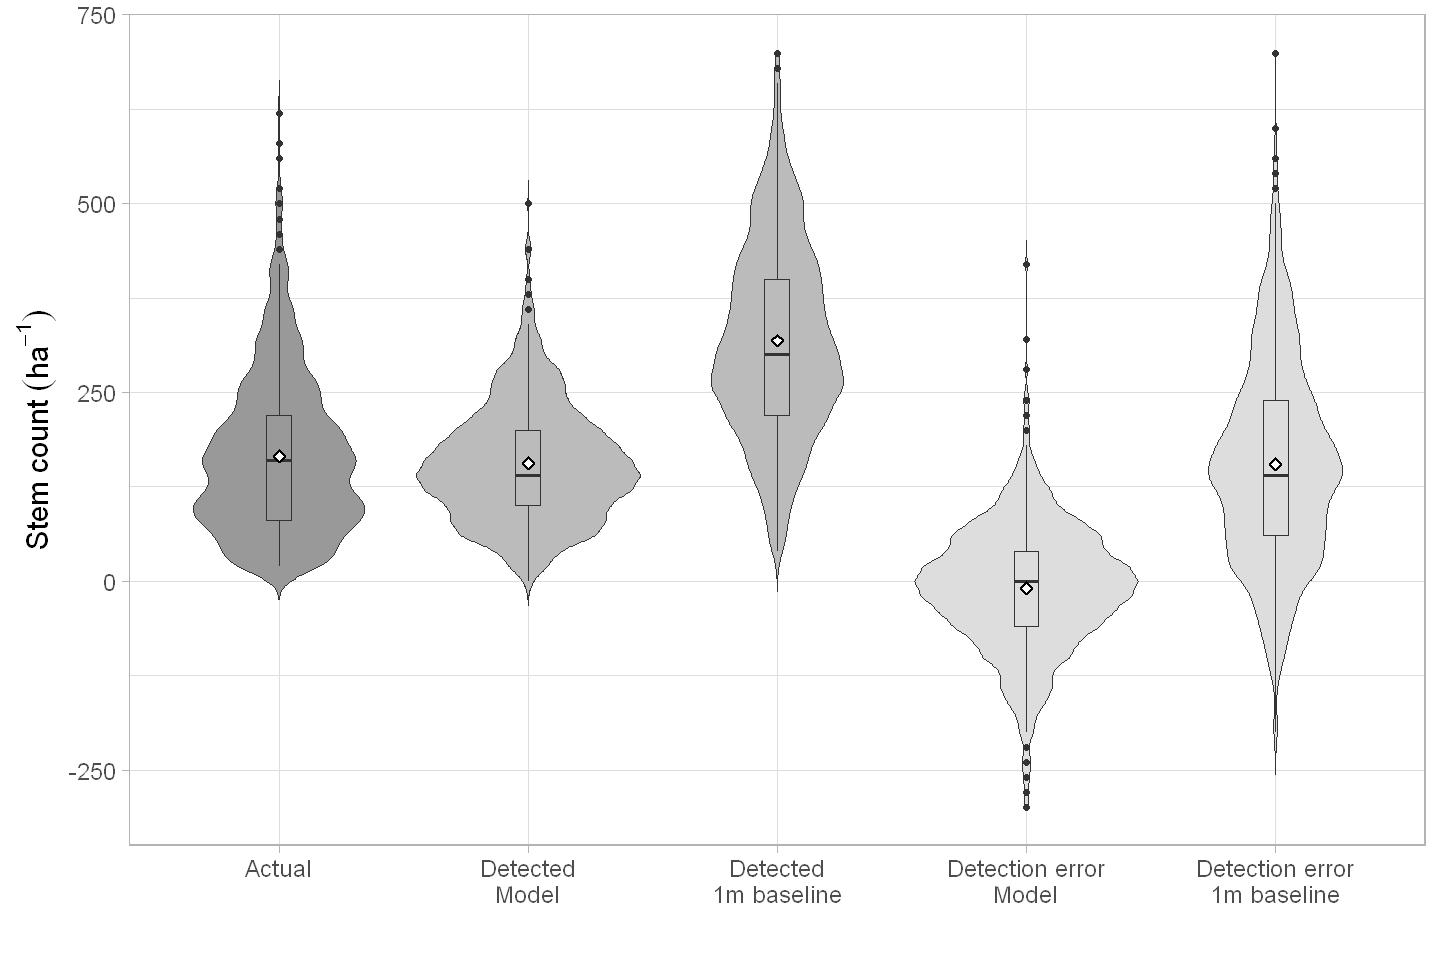

Warning message:
"Removed 5 rows containing missing values (geom_segment)."
Warning message:
"Removed 282 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 282 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 282 rows containing non-finite values (stat_summary)."
Warning message:
"Removed 73 rows containing missing values (geom_violin)."
Warning message:
"Removed 5 rows containing missing values (geom_segment)."


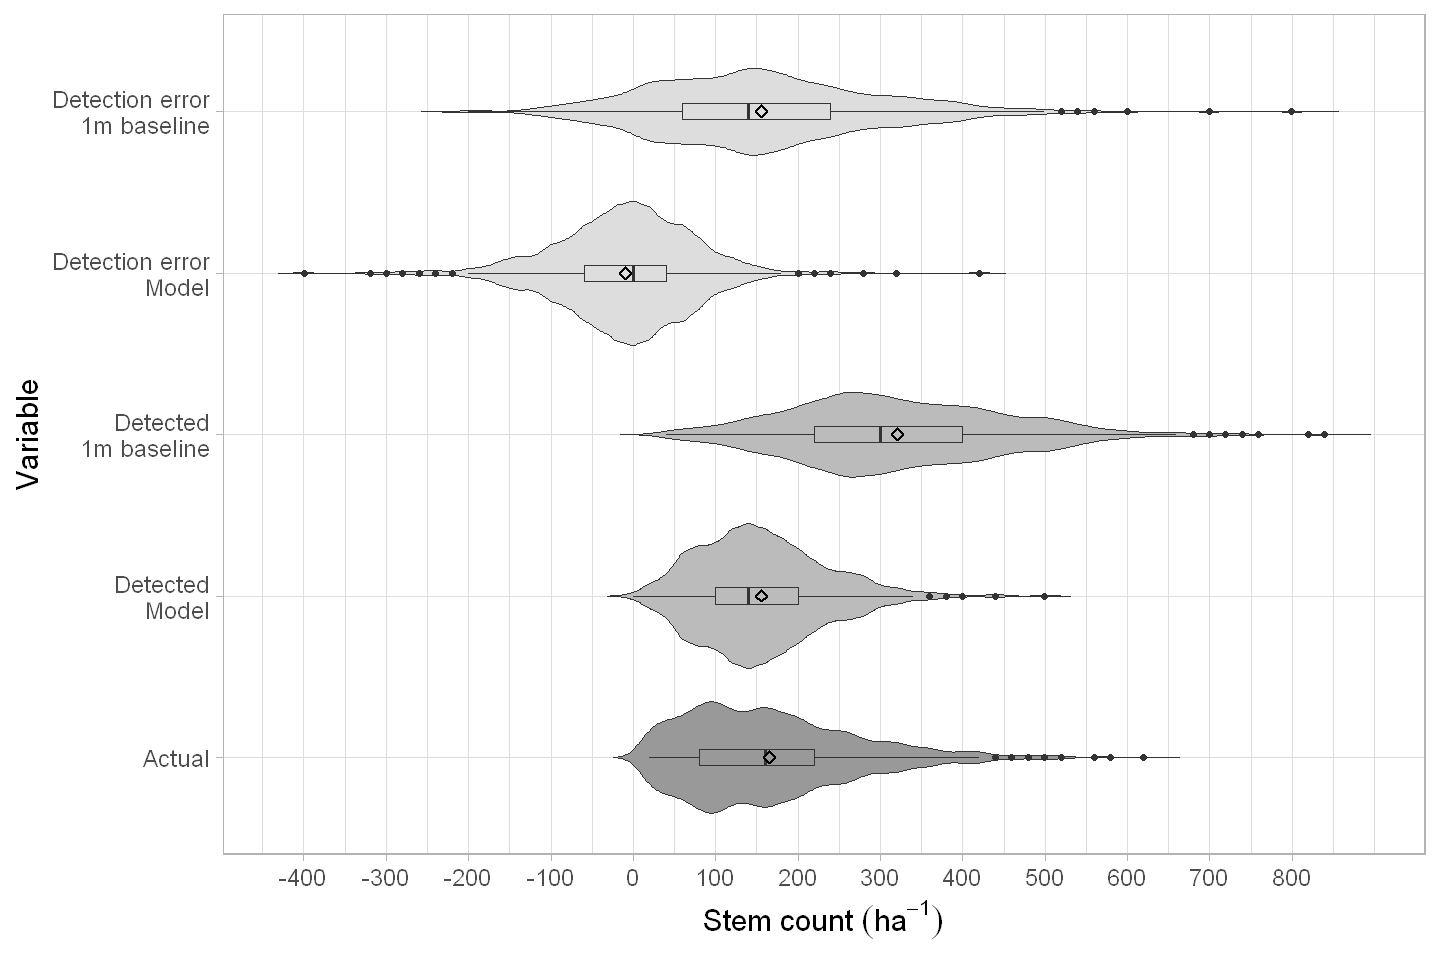

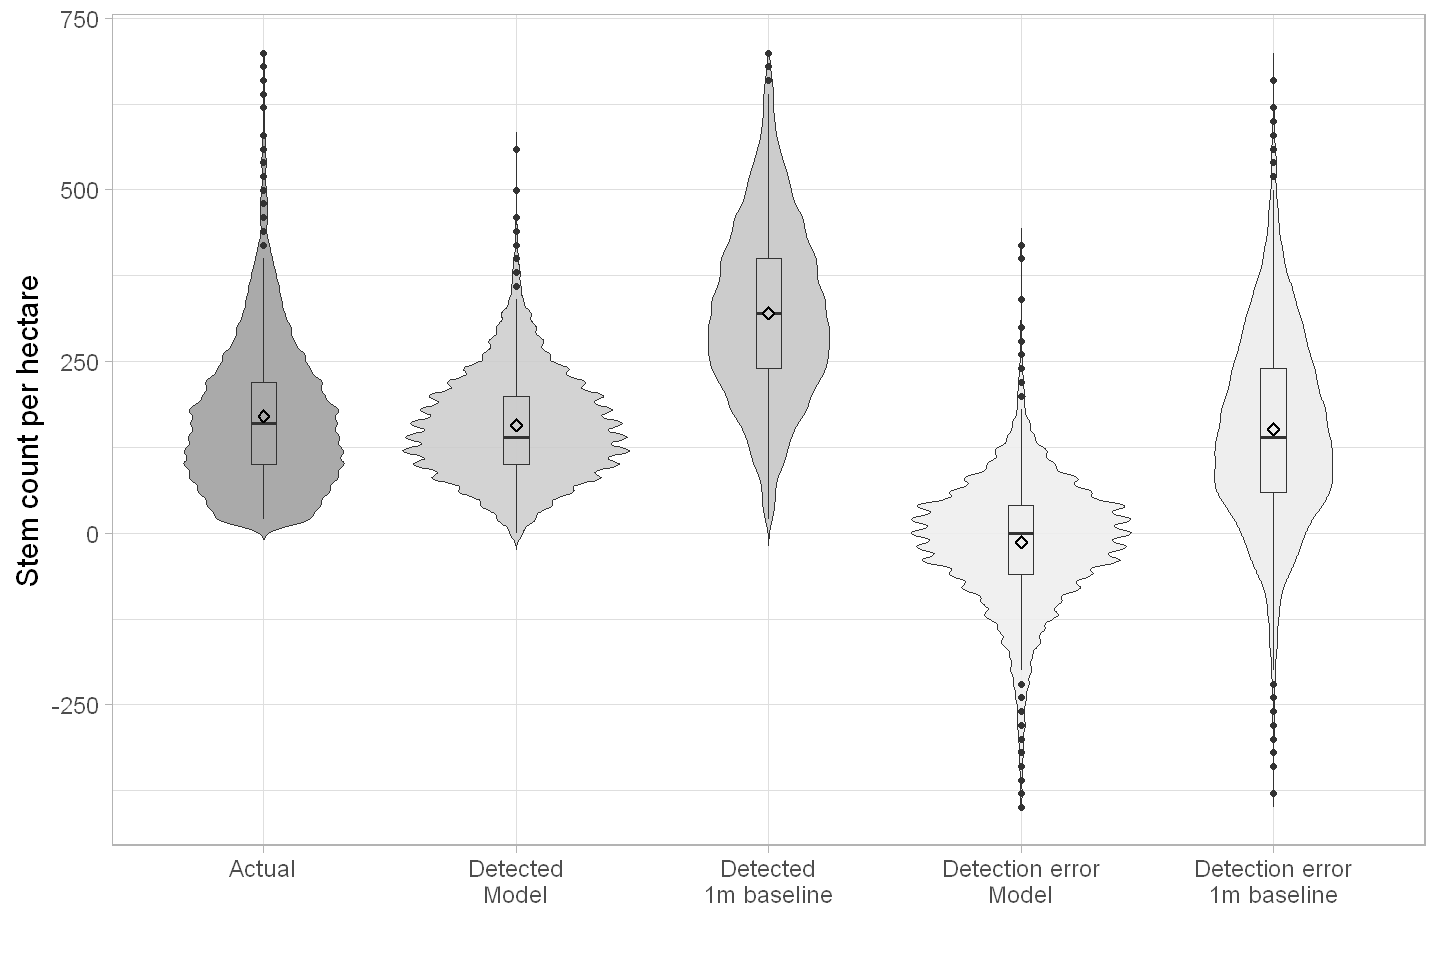

In [59]:
#Violin plots
options(repr.plot.width=12, repr.plot.height=8)

font_base_size <- 18

vp1<-ggplot(df_validation, aes(x=Variable, y=Value, fill=Variable)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  ylim(-300,700) +
  theme_light(base_size = font_base_size) +
  ylab(bquote(Stem~count~(ha^-1))) +
  xlab("") +
  theme(legend.position="none")+
  labs(fill="Detection Method",col="Detection Method") + 
  stat_summary(fun=mean, geom="pointrange", shape=23, size=0.5, fill="white") +
  scale_fill_manual(values=c("#999999", "#BBBBBB", "#BBBBBB", "#DDDDDD", "#DDDDDD"))  

vp1 

ggsave(filename = "3_violin_validation_vertical.jpg", width = 12, height = 8, device='jpeg', dpi=300)

vp2<-ggplot(df_validation, aes(x=Variable, y=Value, fill=Variable)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  # ylim(-200,600) +
  theme_light(base_size = font_base_size) +
  ylab(bquote(Stem~count~(ha^-1))) +
  theme(legend.position="none")+
  labs(fill="Detection Method",col="Detection Method") + 
  stat_summary(fun=mean, geom="pointrange", shape=23, size=0.5) +
  scale_fill_manual(values=c("#999999", "#BBBBBB", "#BBBBBB", "#DDDDDD", "#DDDDDD"))+
  coord_flip()+
  scale_y_continuous(breaks = seq(-400, 800, by = 100))

vp2

ggsave(filename = "3_violin_validation_horizontal.jpg", width = 12, height = 8, device='jpeg', dpi=300)


vptr1<-ggplot(df_calibration, aes(x=Variable, y=Value, fill=Variable)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  ylim(-400,700) +
  theme_light(base_size = font_base_size) +
  ylab("Stem count per hectare") +
  xlab("") +
  theme(legend.position="none")+
  labs(fill="Detection Method",col="Detection Method") + 
  stat_summary(fun=mean, geom="pointrange", shape=23, size=0.5) +
  scale_fill_manual(values=c("#AAAAAA", "#CCCCCCDD", "#CCCCCC", "#EEEEEEDD", "#EEEEEE"))  

vptr1


Warning message:
"Removed 130 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 130 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 130 rows containing missing values (geom_point)."
Warning message:
"Removed 19 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 19 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 19 rows containing missing values (geom_point)."


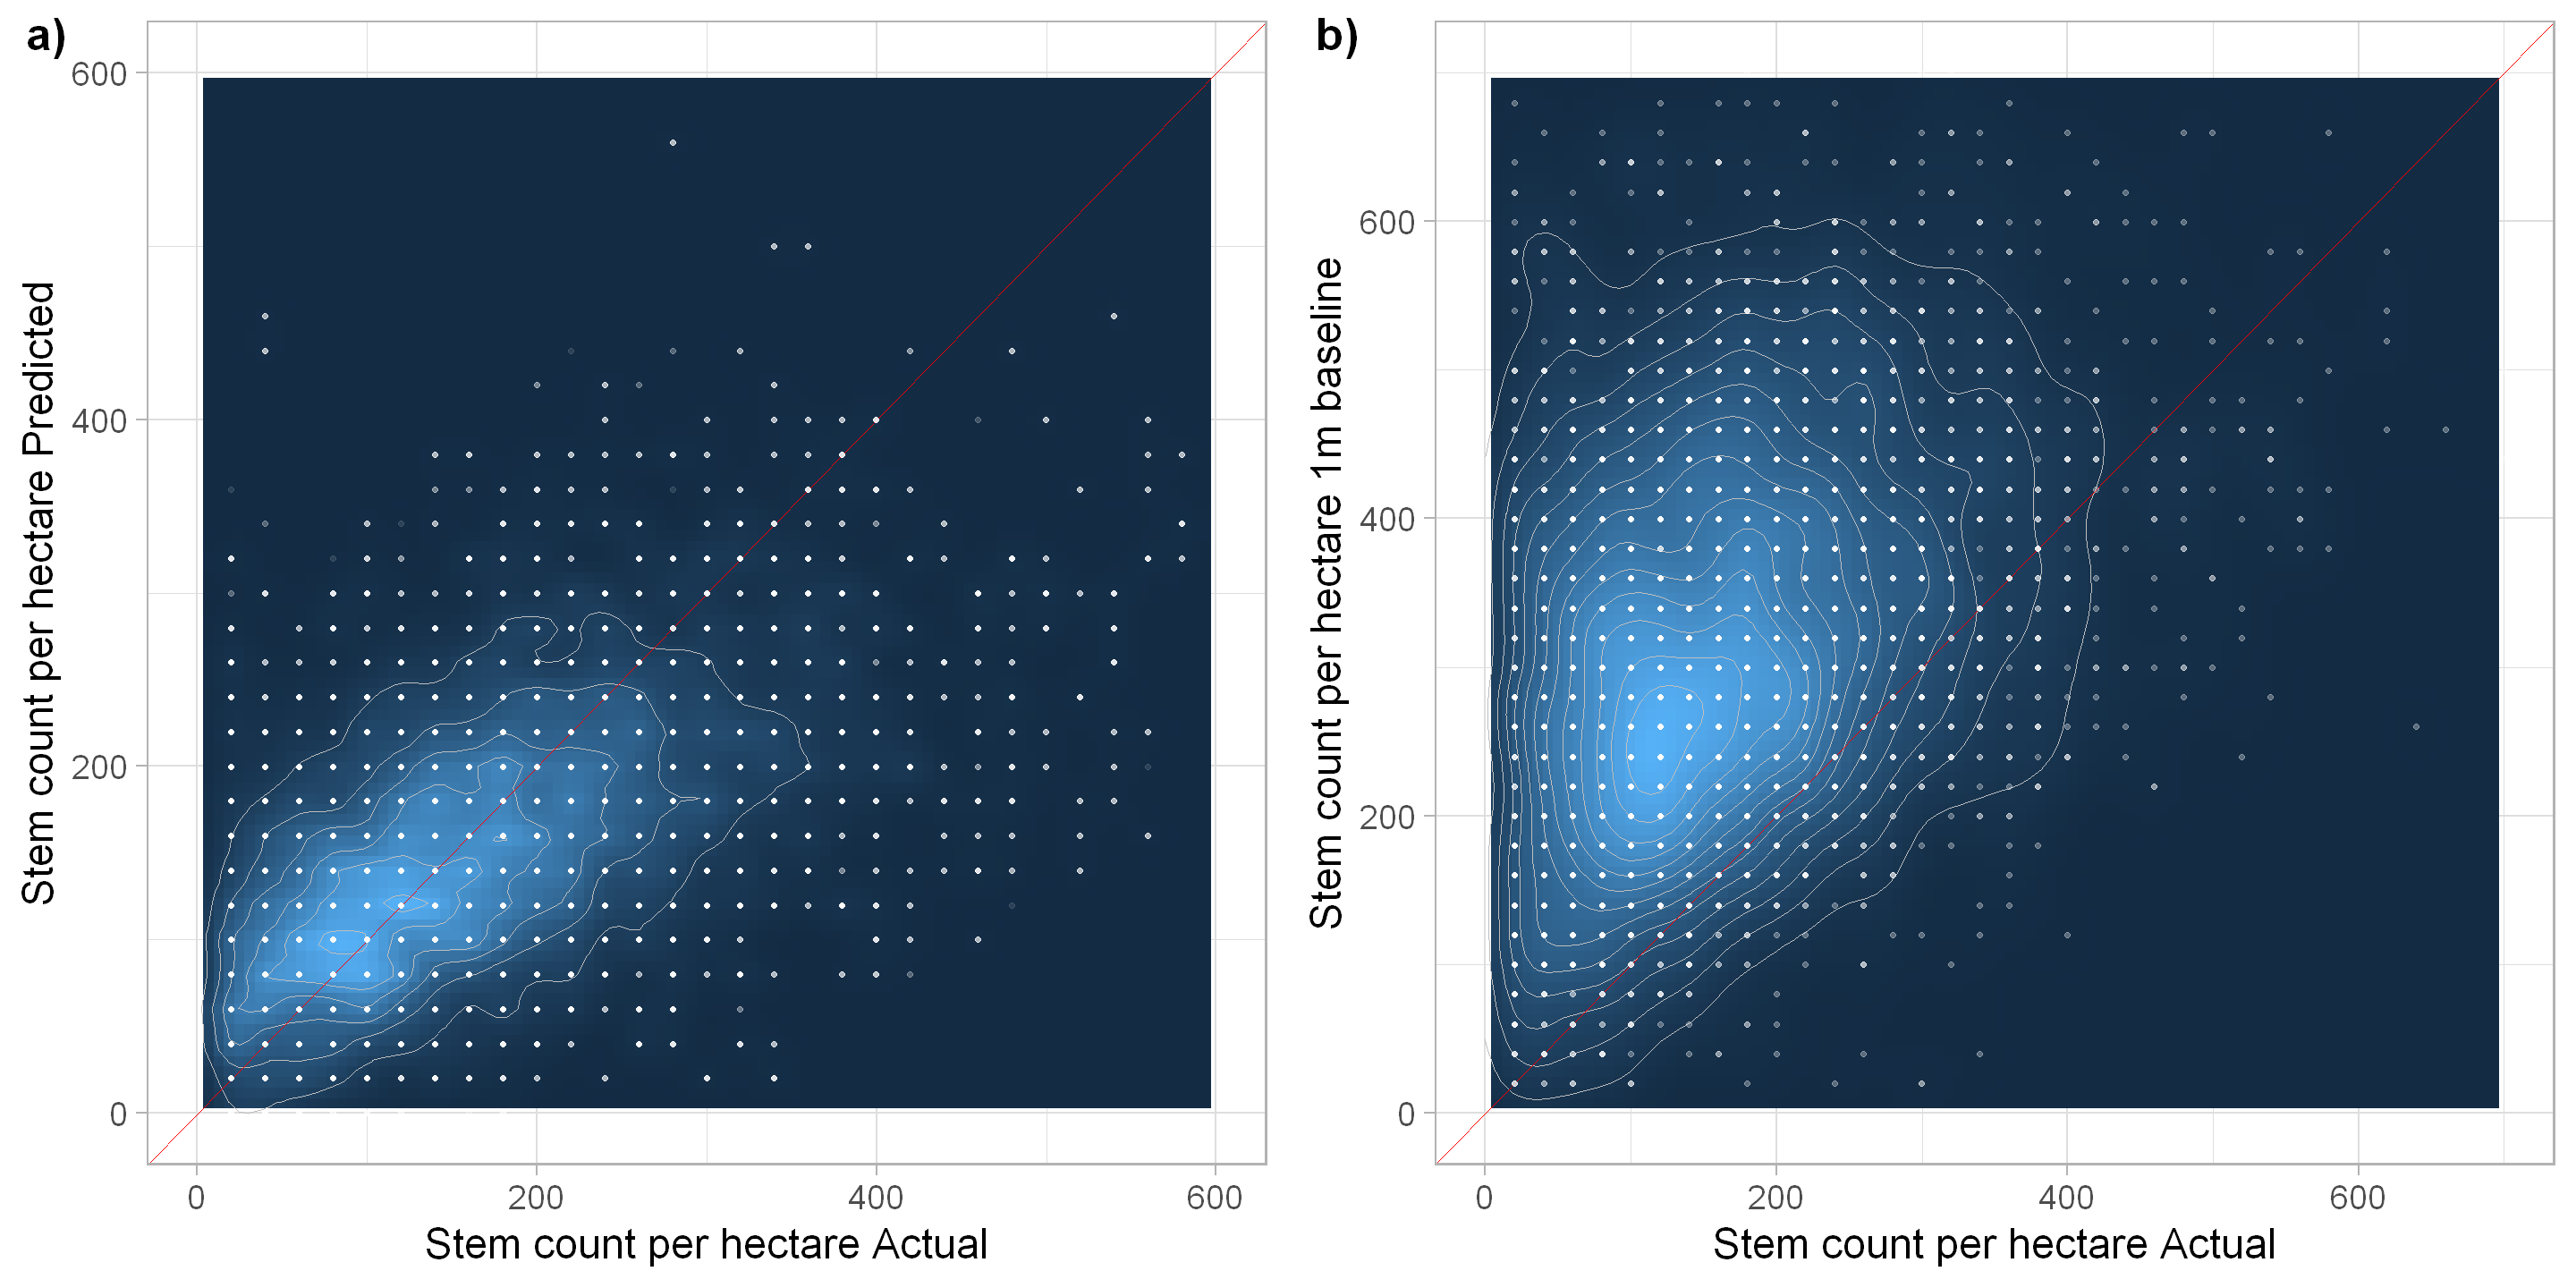

In [60]:
#Scatter plots calibration
df <- data.frame(Actual=scd_calibration$density_actual, Prediction=scd_calibration$stems_per_ha_model, Error=scd_calibration$stems_per_ha_err_model)

options(repr.plot.width=12, repr.plot.height=12)

font_base_size <- 28

sc1_tr <- ggplot(df, aes(x=Actual, y=Prediction)) +
  # geom_bin2d(binwidth=20)+
  # geom_hex() +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_abline(intercept = 0, slope = 1, color="red") +
  geom_point(alpha=0.1, color="white") +
  xlim(0,600) +
  ylim(0,600) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  theme(legend.position="none")+
  xlab("Stem count per hectare Actual") +
  ylab("Stem count per hectare Predicted") 


df <- data.frame(Actual=lfi_trees_grouped_calibration$density_actual, Baseline=lfi_trees_grouped_calibration$stems_per_ha_ps1, Error=lfi_trees_grouped_calibration$stems_per_ha_err_ps1)

sc2_tr <- ggplot(df, aes(x=Actual, y=Baseline)) +
  # geom_bin2d(binwidth=20)+
  # geom_hex() +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_abline(intercept = 0, slope = 1, color="red") +
  geom_point(alpha=0.3, color="white") +
  xlim(0,700) +
  ylim(0,700) +
  theme_light(base_size = font_base_size) +
  theme(legend.position="none")+
  xlab("Stem count per hectare Actual") +
  ylab("Stem count per hectare 1m baseline") 

options(repr.plot.width=24, repr.plot.height=12)

ggarrange(sc1_tr, sc2_tr, 
          labels = c("a) ", "b) "),
          ncol = 2, nrow = 1, font.label = list(size = 30))
ggsave(filename = "4_scatter_actual_predicted_baseline_calibration.jpg", width = 24, height = 12, device='jpeg', dpi=300)


Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 10 rows containing missing values (geom_point)."
Warning message:
"Removed 6 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 6 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 6 rows containing missing values (geom_point)."


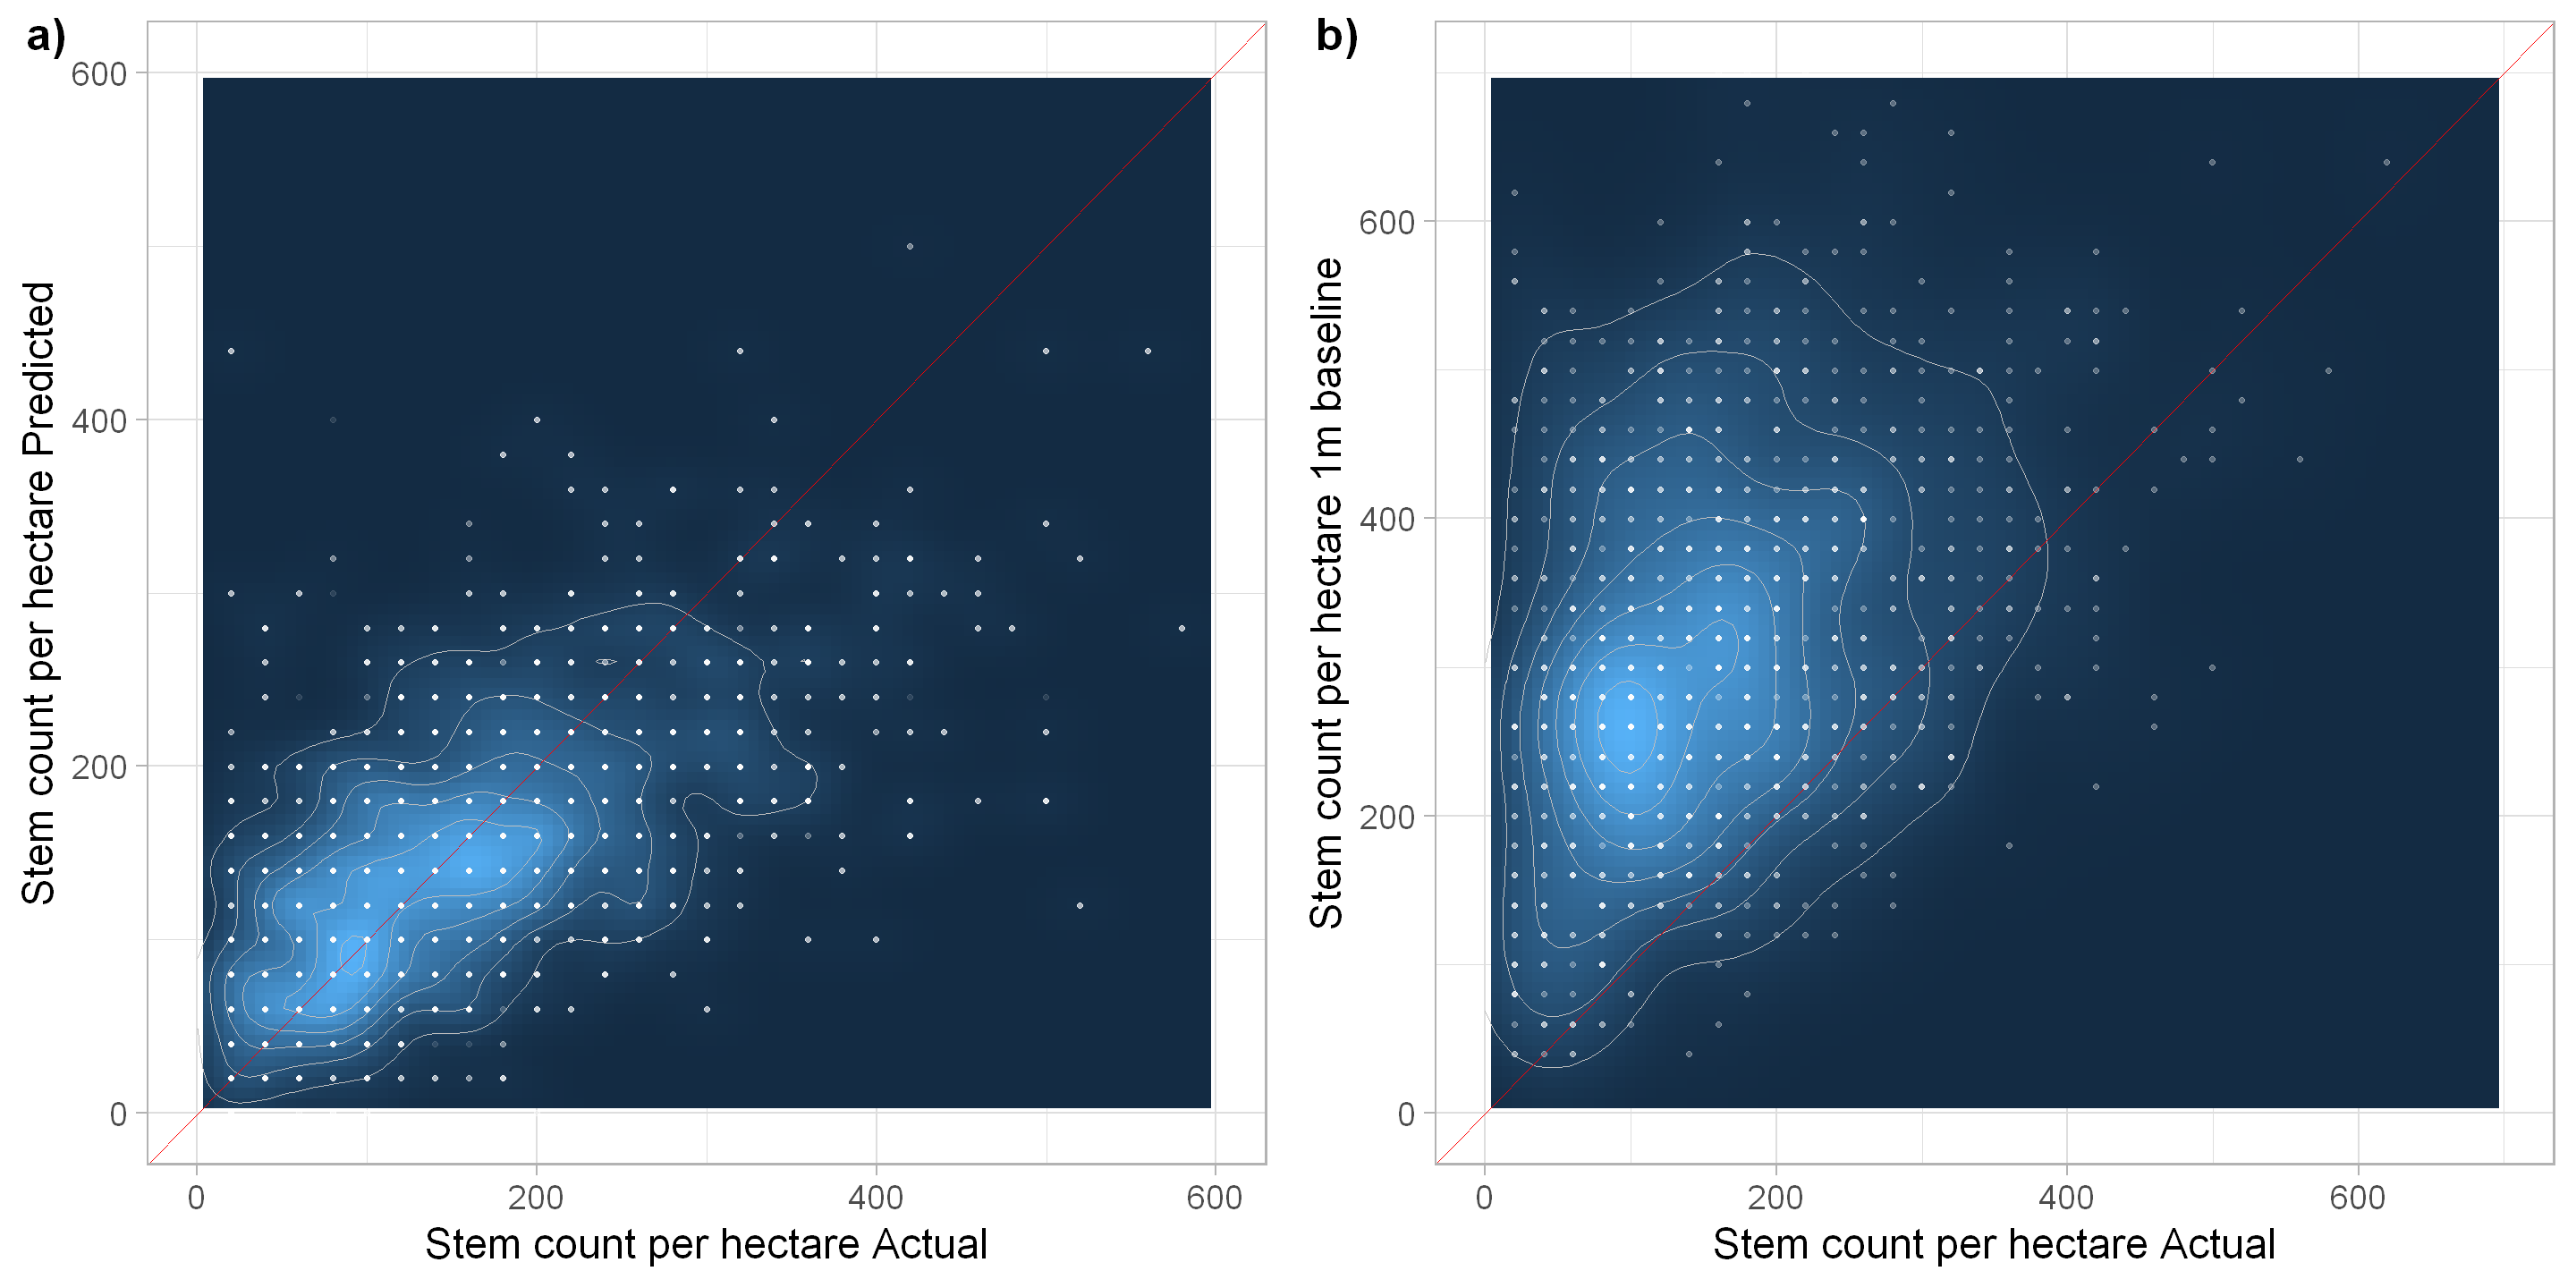

In [61]:
#Scatter plots validation
df <- data.frame(Actual=scd_validation$density_actual, Prediction=scd_validation$stems_per_ha_model, Error=scd_validation$stems_per_ha_err_model)

options(repr.plot.width=12, repr.plot.height=12)

font_base_size <- 28

sc1_ts <- ggplot(df, aes(x=Actual, y=Prediction)) +
  # geom_bin2d(binwidth=20)+
  # geom_hex() +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_abline(intercept = 0, slope = 1, color="red") +
  geom_point(alpha=0.1, color="white") +
  xlim(0,600) +
  ylim(0,600) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  theme(legend.position="none")+
  xlab("Stem count per hectare Actual") +
  ylab("Stem count per hectare Predicted") 


df <- data.frame(Actual=lfi_trees_grouped_validation$density_actual, Baseline=lfi_trees_grouped_validation$stems_per_ha_ps1, Error=lfi_trees_grouped_validation$stems_per_ha_err_ps1)

sc2_ts <- ggplot(df, aes(x=Actual, y=Baseline)) +
  # geom_bin2d(binwidth=20)+
  # geom_hex() +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_abline(intercept = 0, slope = 1, color="red") +
  geom_point(alpha=0.3, color="white") +
  xlim(0,700) +
  ylim(0,700) +
  theme_light(base_size = font_base_size) +
  theme(legend.position="none")+
  xlab("Stem count per hectare Actual") +
  ylab("Stem count per hectare 1m baseline") 

options(repr.plot.width=24, repr.plot.height=12)

ggarrange(sc1_ts, sc2_ts, 
          labels = c("a) ", "b) "),
          ncol = 2, nrow = 1, font.label = list(size = 30))
ggsave(filename = "4_scatter_actual_predicted_baseline_validation.jpg", width = 24, height = 12, device='jpeg', dpi=300)


Warning message:
"Removed 130 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 130 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 130 rows containing missing values (geom_point)."
Warning message:
"Removed 19 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 19 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 19 rows containing missing values (geom_point)."
Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 10 rows containing missing values (geom_point)."
Warning message:
"Removed 6 rows containing non-f

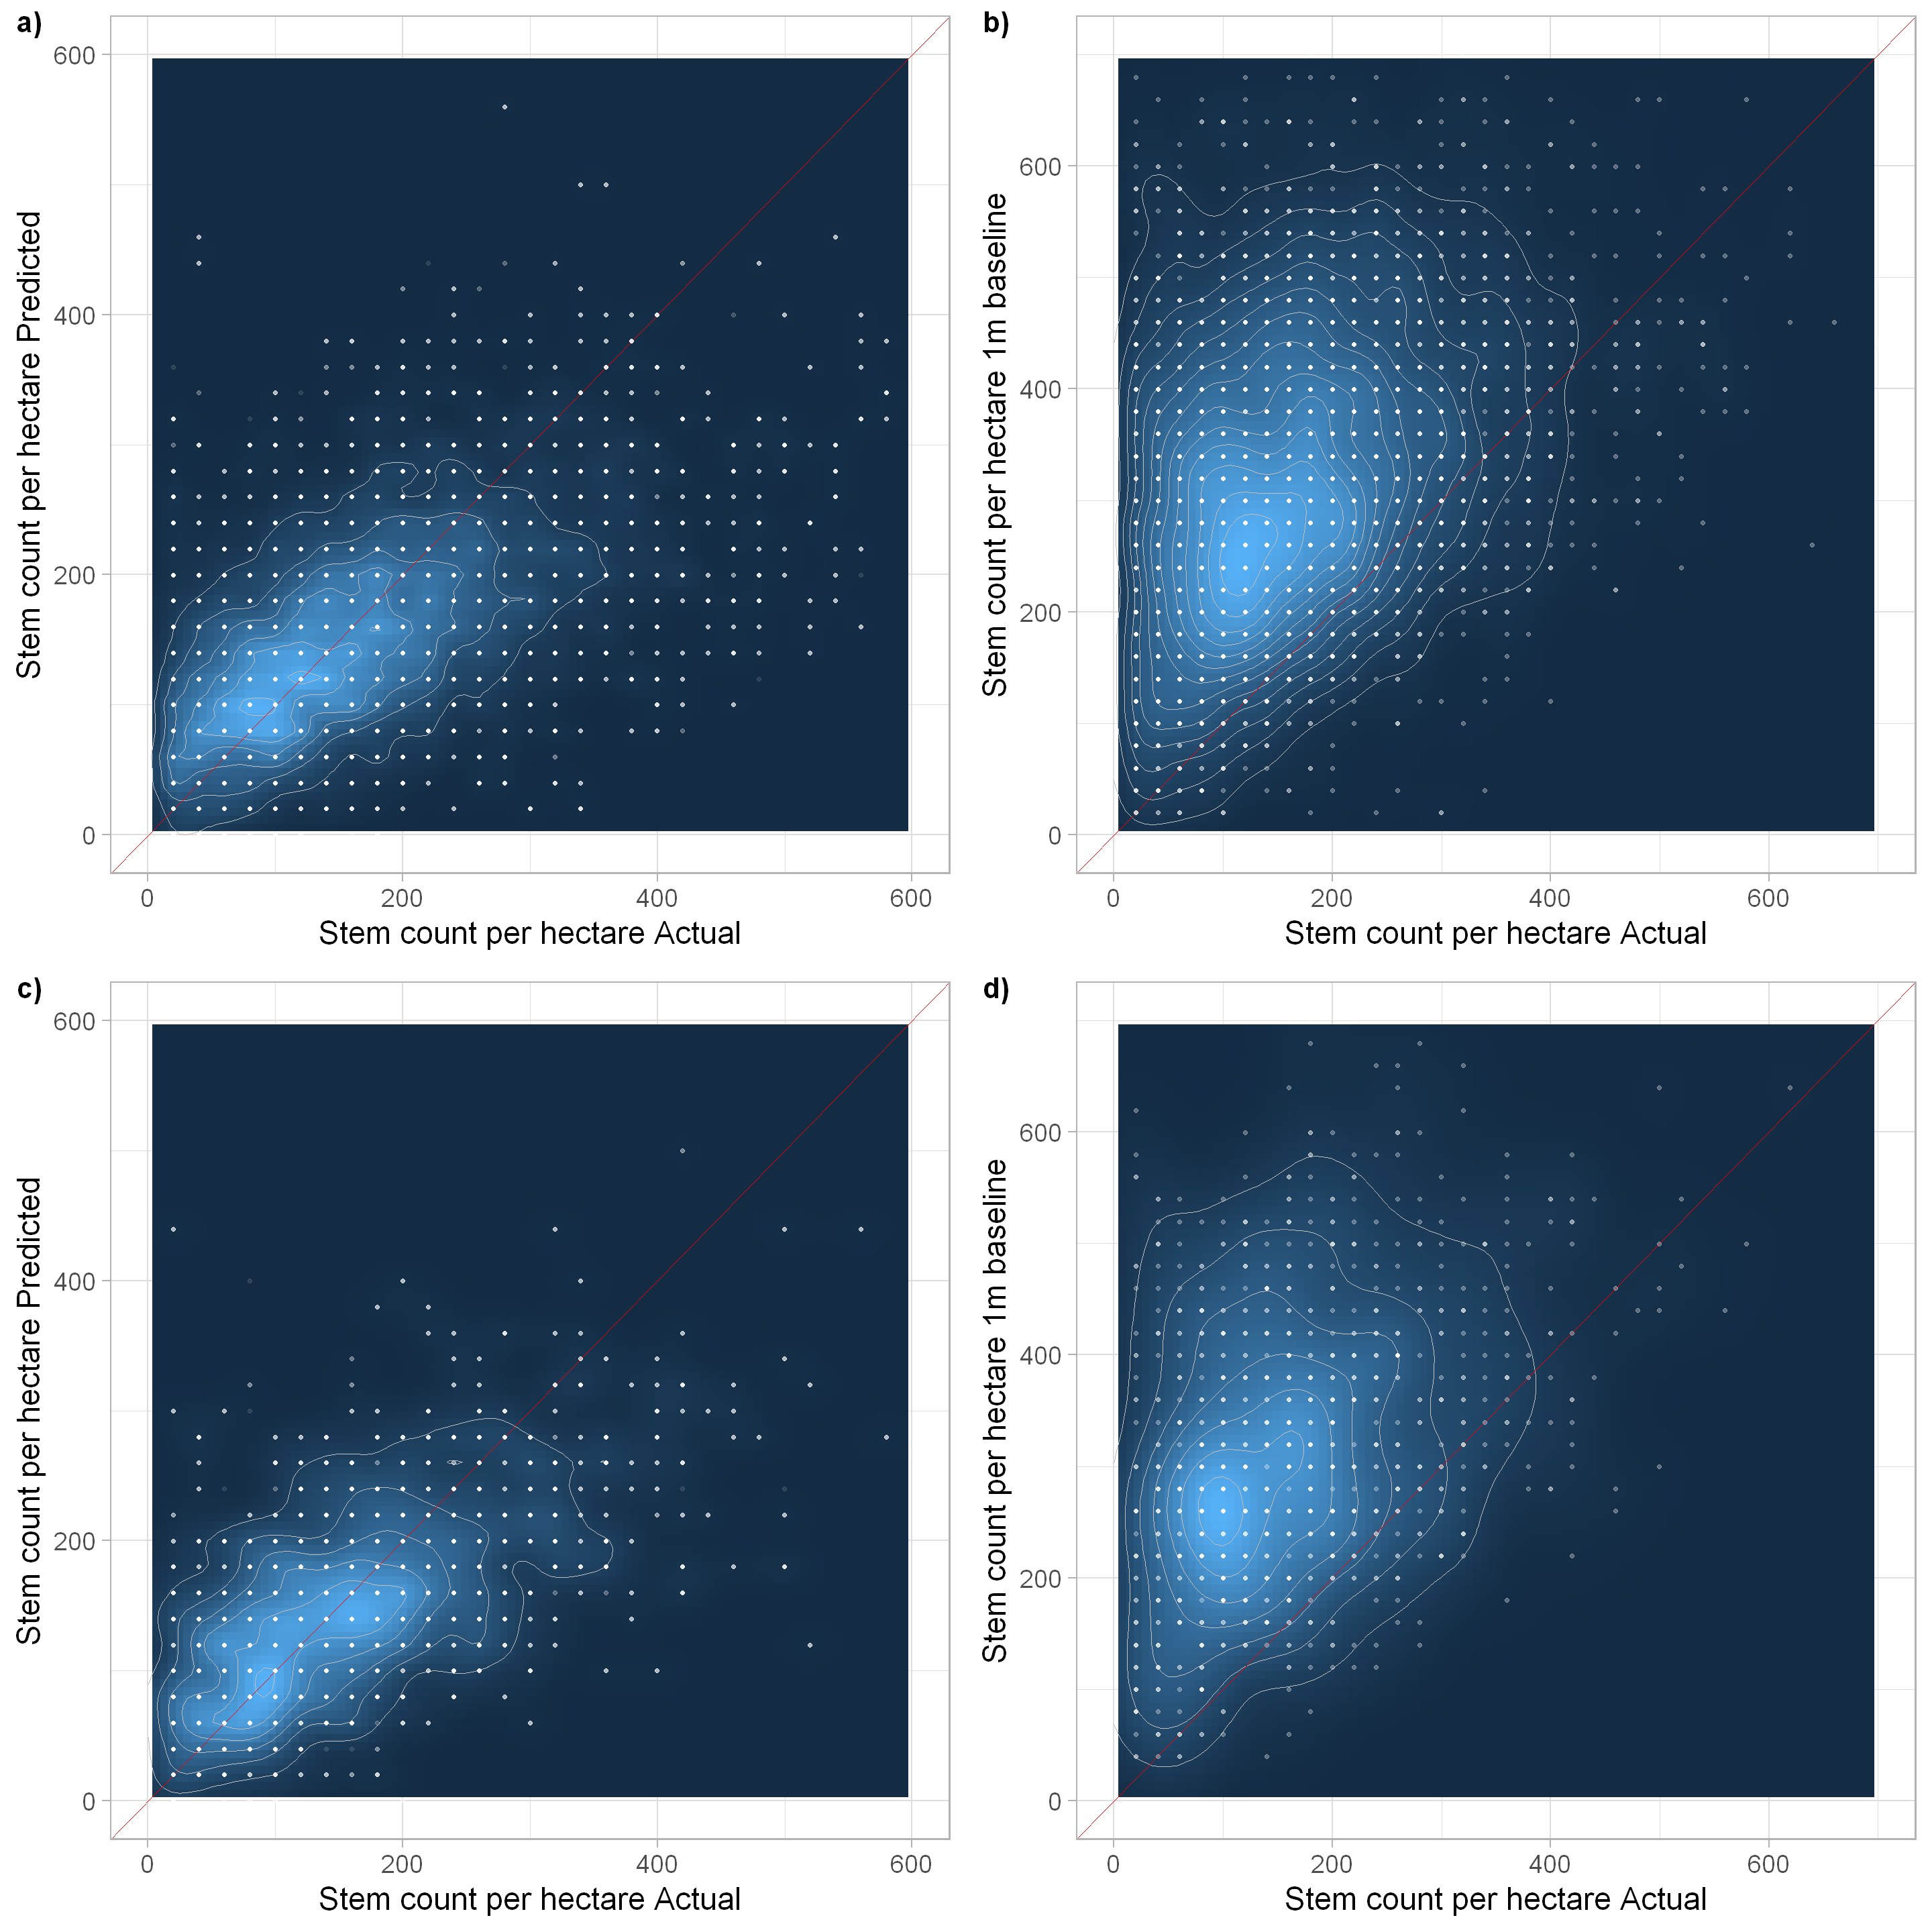

In [62]:
#Scatter plots validation and calibration
options(repr.plot.width=24, repr.plot.height=24)

ggarrange(sc1_tr,sc2_tr,sc1_ts, sc2_ts, 
          labels = c("a) ", "b) ", "c) ", "d) "),
          ncol = 2, nrow = 2, font.label = list(size = 26))


### Exploring high errors

In [63]:
# Get scoring data for all plots for the best model 
min_mae_index <- which.min(scores_all_all$scores$mae)
data <- scores_all_all$scoring_data[[min_mae_index]]

In [64]:
summary(data$stems_per_ha_abs_err_norm_model)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.1667  0.3333  0.6297  0.6000 21.0000 

In [65]:
# Set 0/1 Flags for normed absolute errors >1, >2, >3 and >4
data$ae_norm_class_1 <-  as.factor(unlist(lapply(data$stems_per_ha_abs_err_norm_model, function(x) { if(x>1){return(1)}else{return(0)}})))
data$ae_norm_class_2 <-  as.factor(unlist(lapply(data$stems_per_ha_abs_err_norm_model, function(x) { if(x>2){return(1)}else{return(0)}})))
data$ae_norm_class_3 <-  as.factor(unlist(lapply(data$stems_per_ha_abs_err_norm_model, function(x) { if(x>3){return(1)}else{return(0)}})))
data$ae_norm_class_4 <-  as.factor(unlist(lapply(data$stems_per_ha_abs_err_norm_model, function(x) { if(x>4){return(1)}else{return(0)}})))

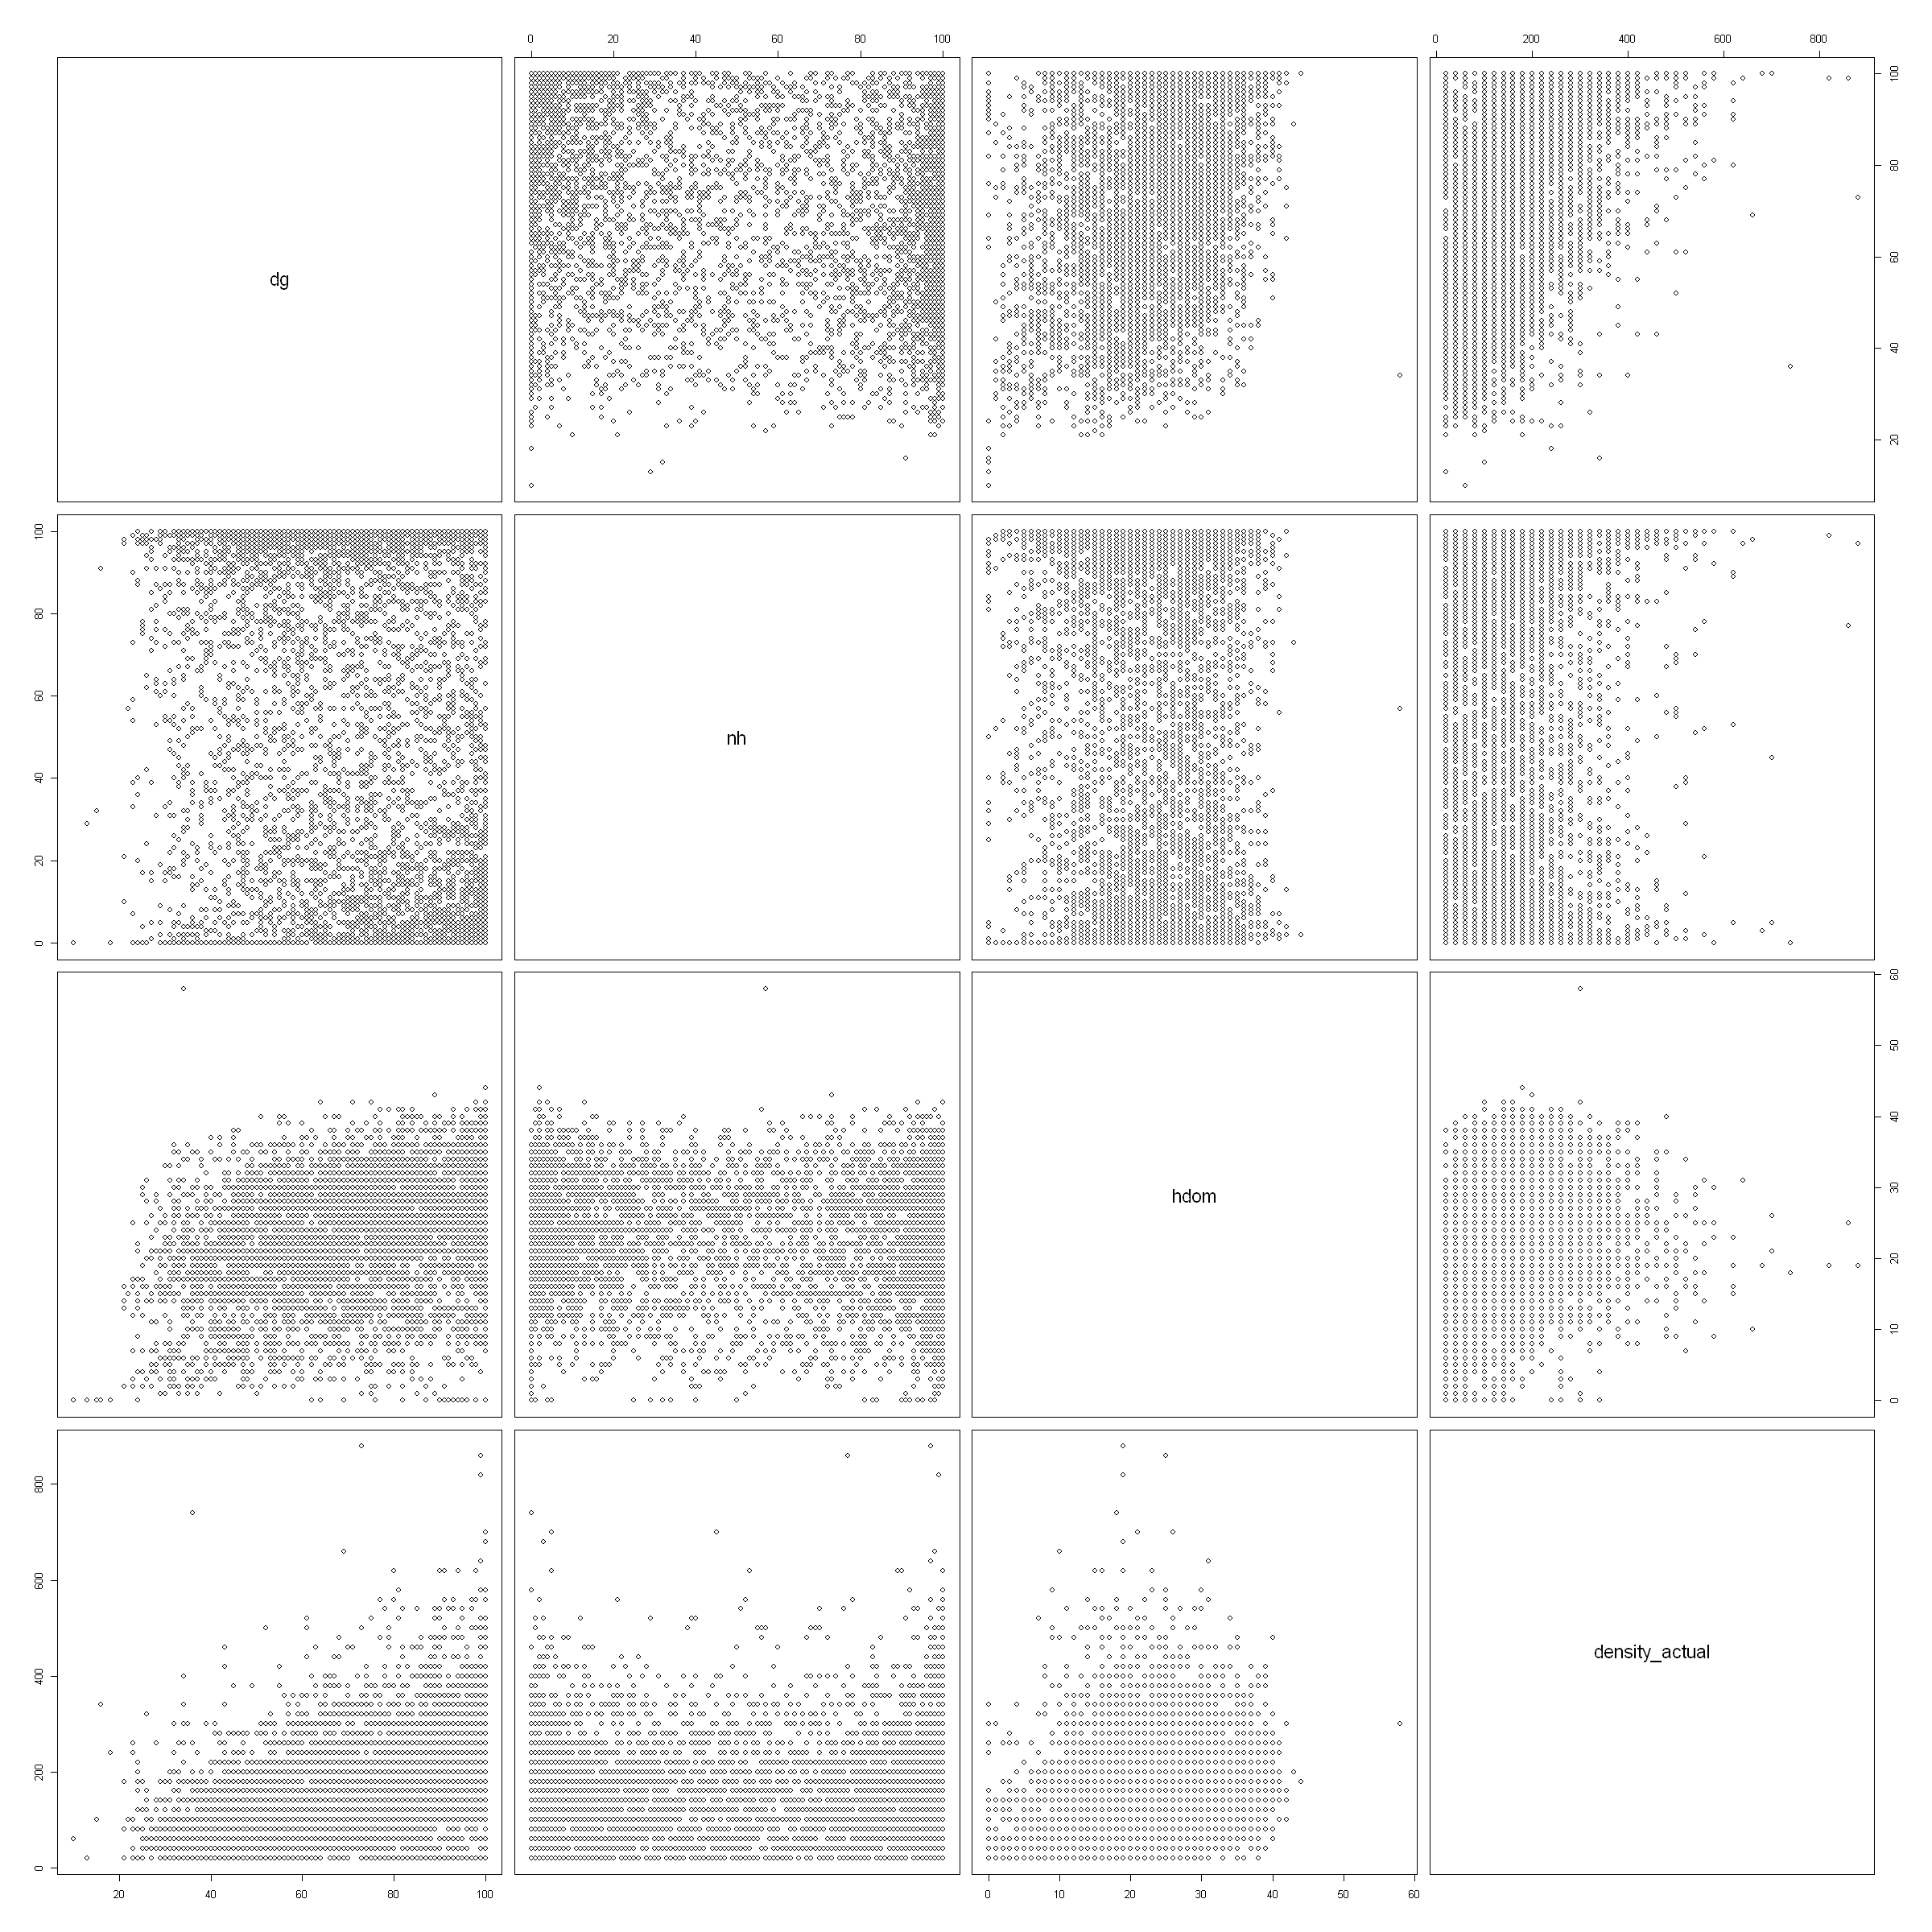

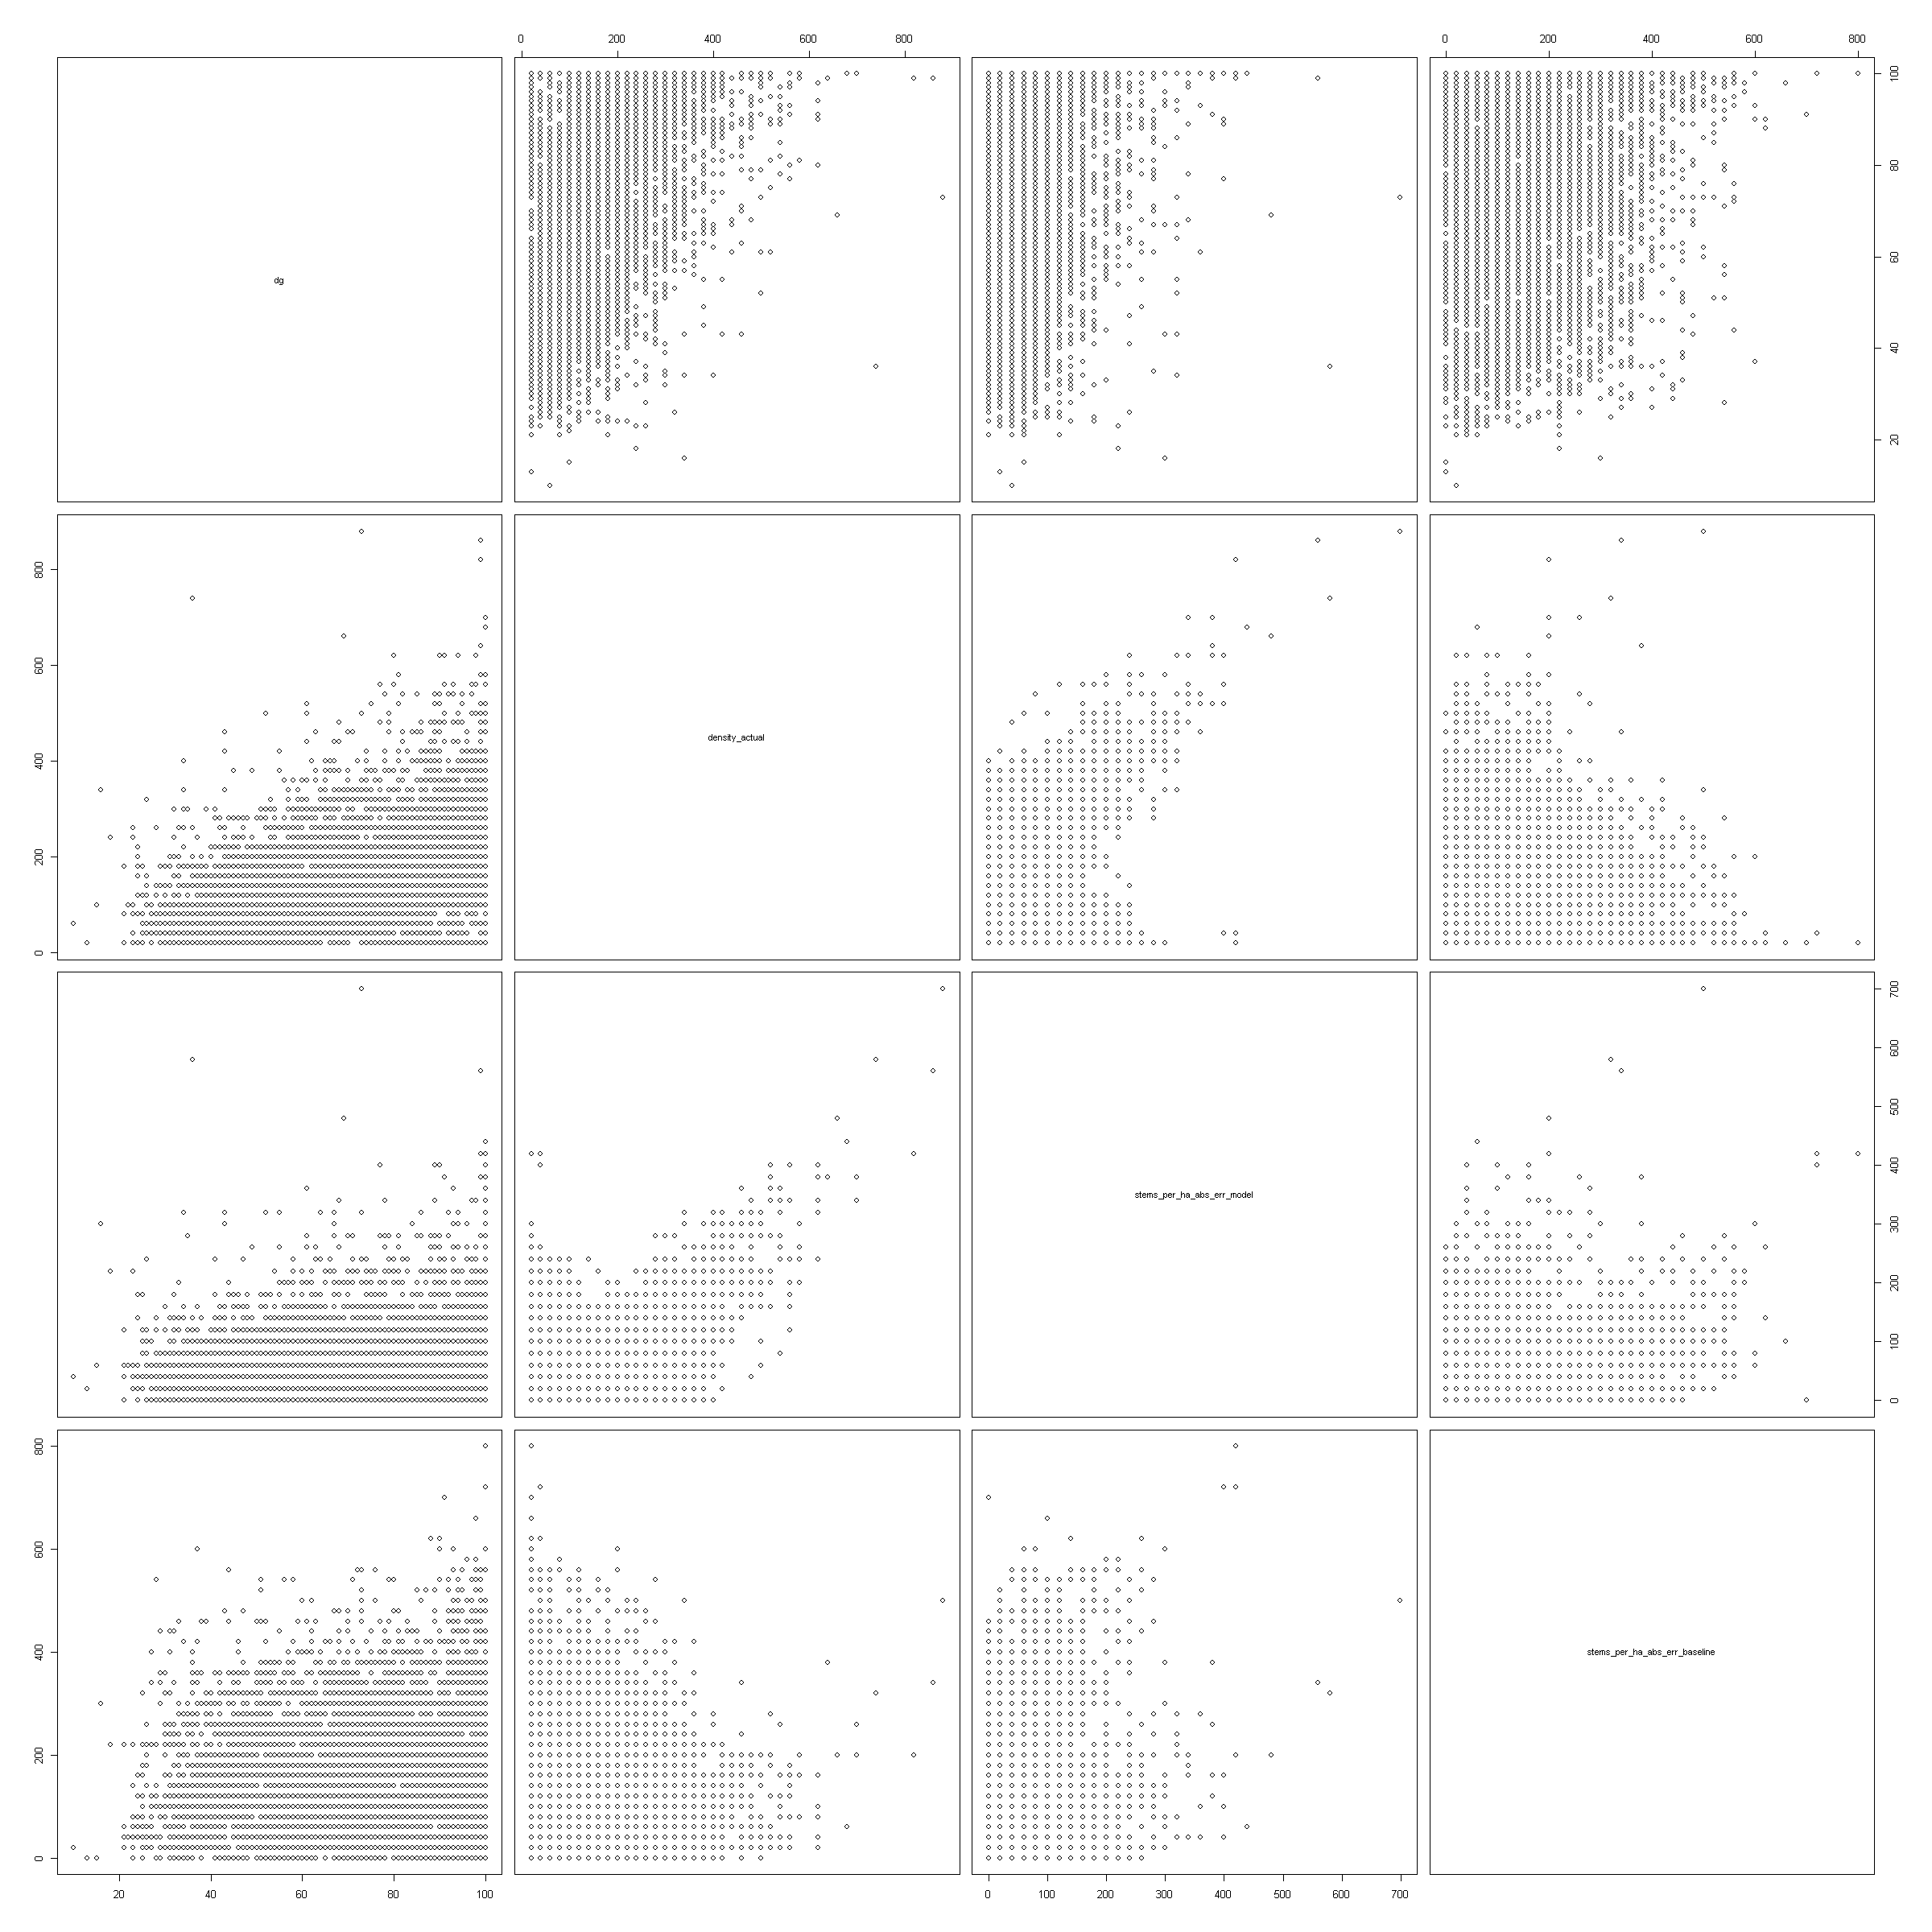

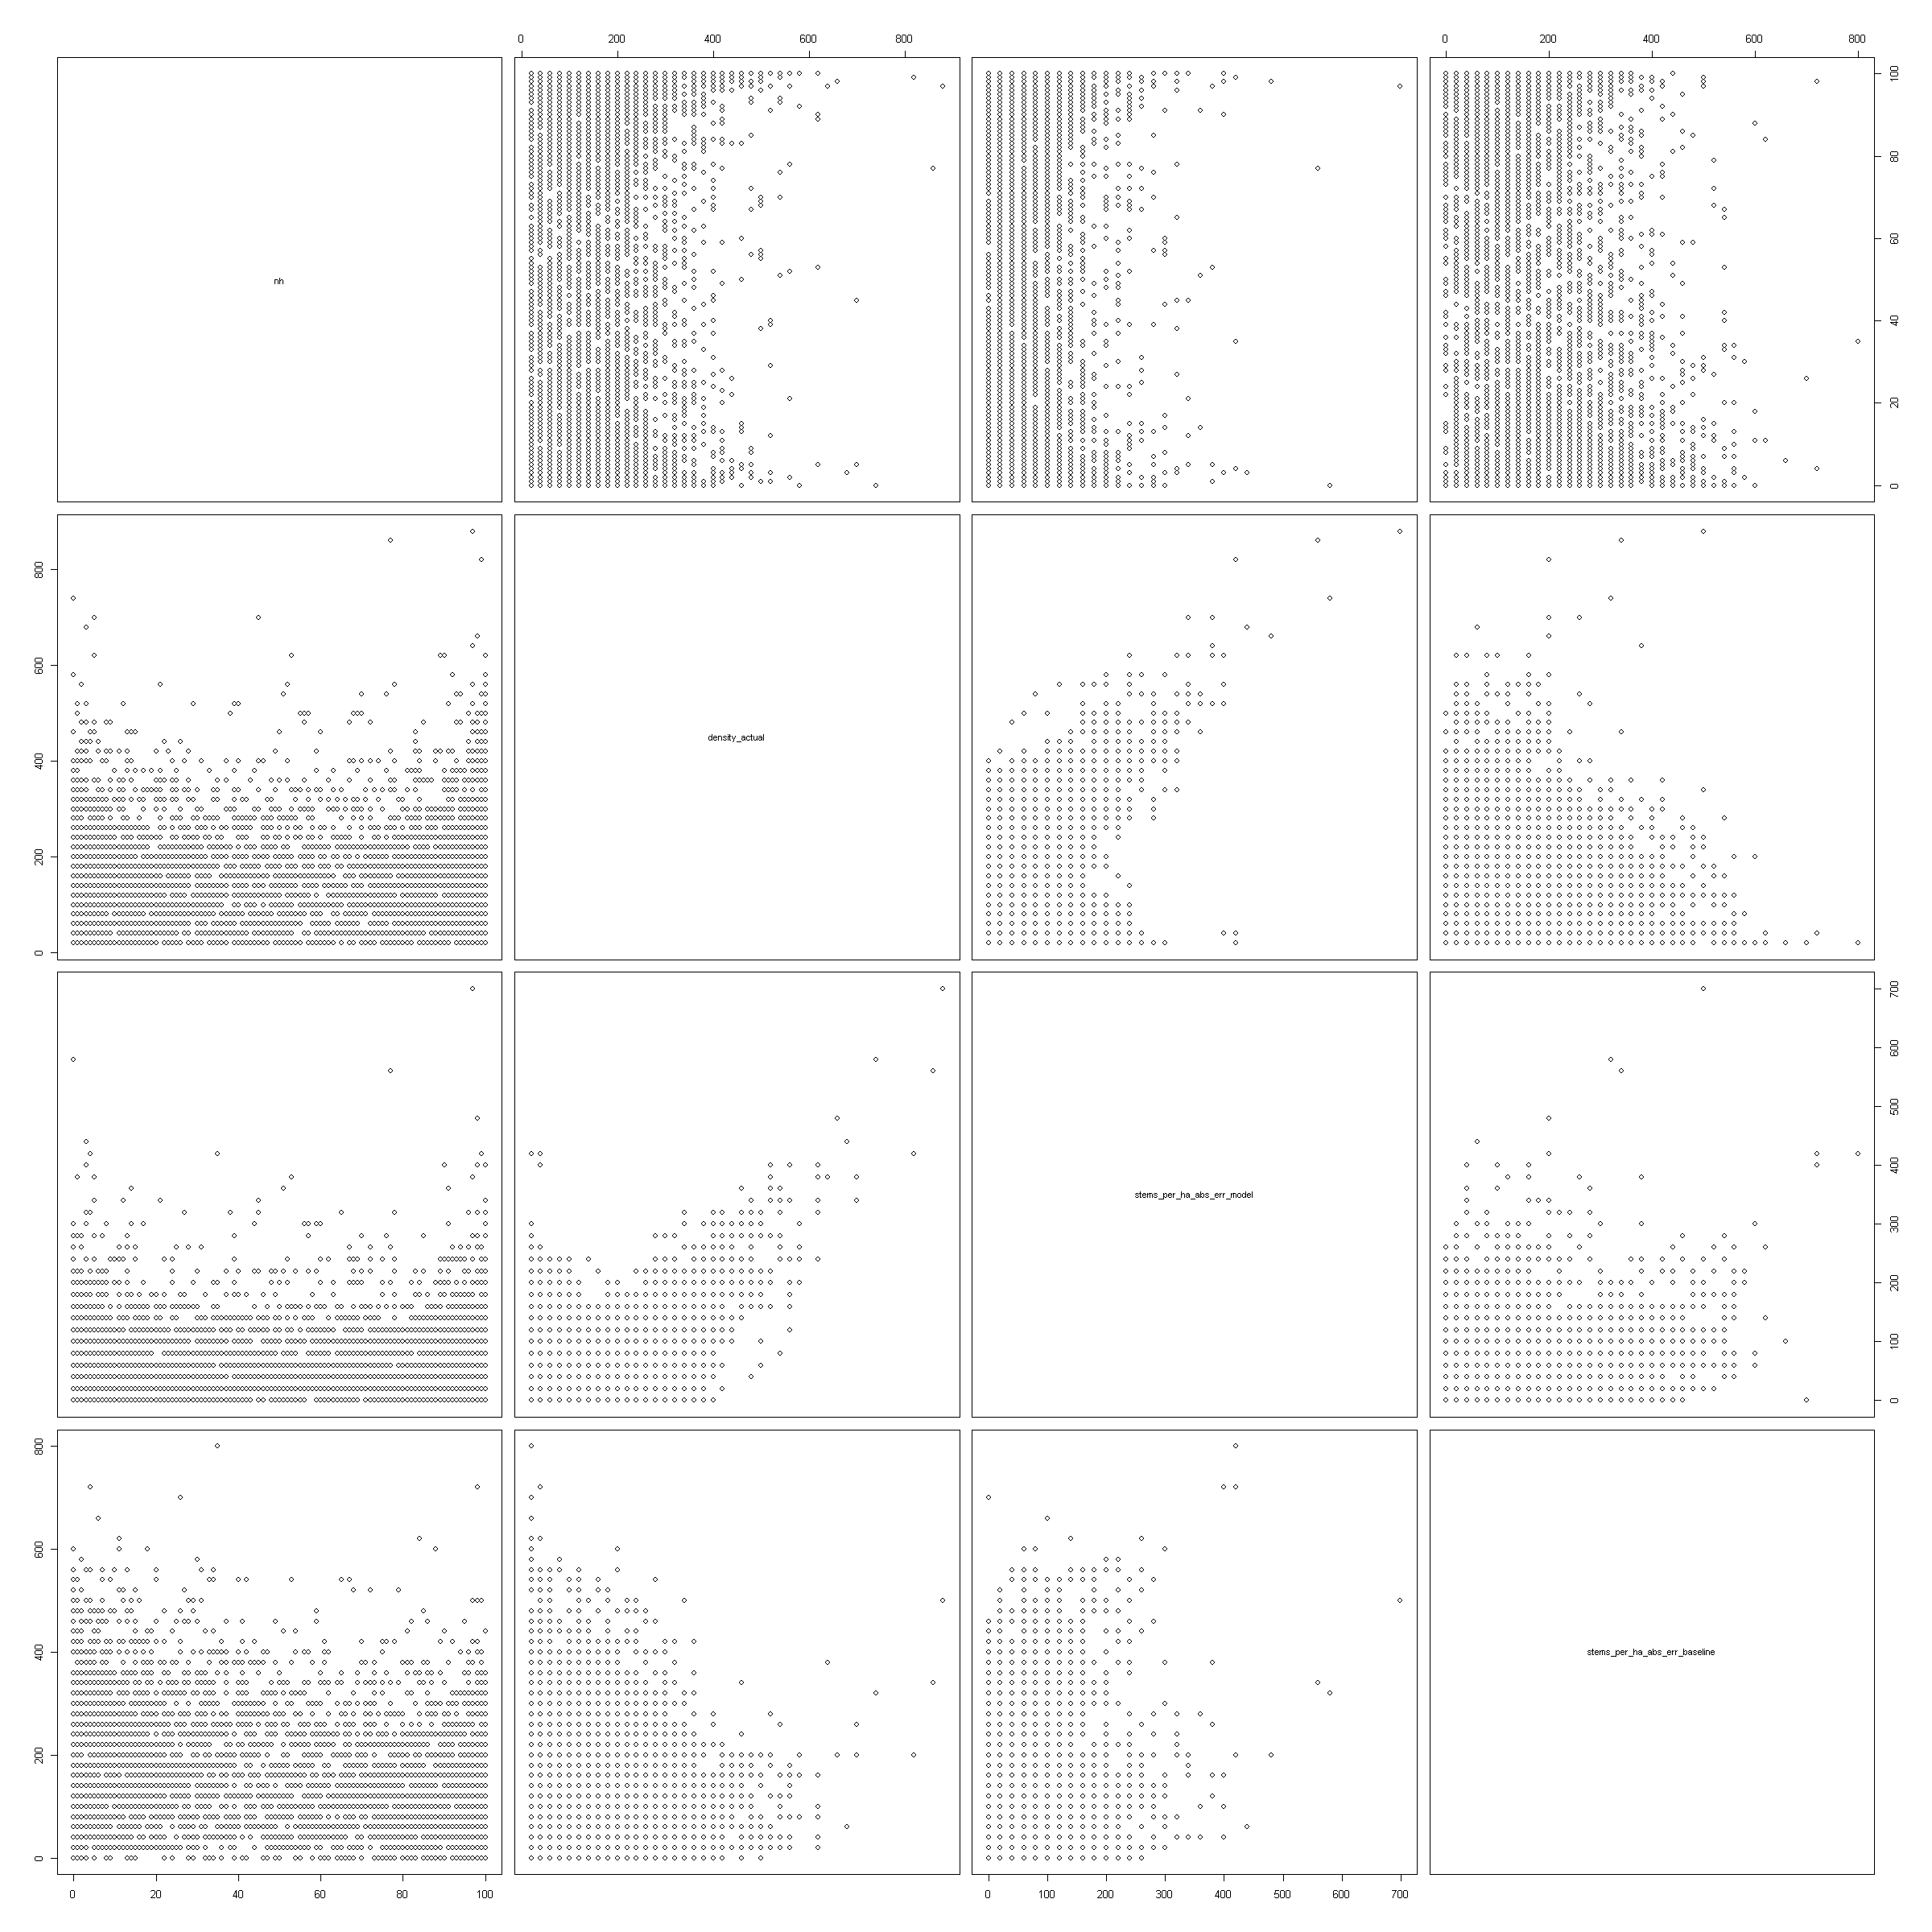

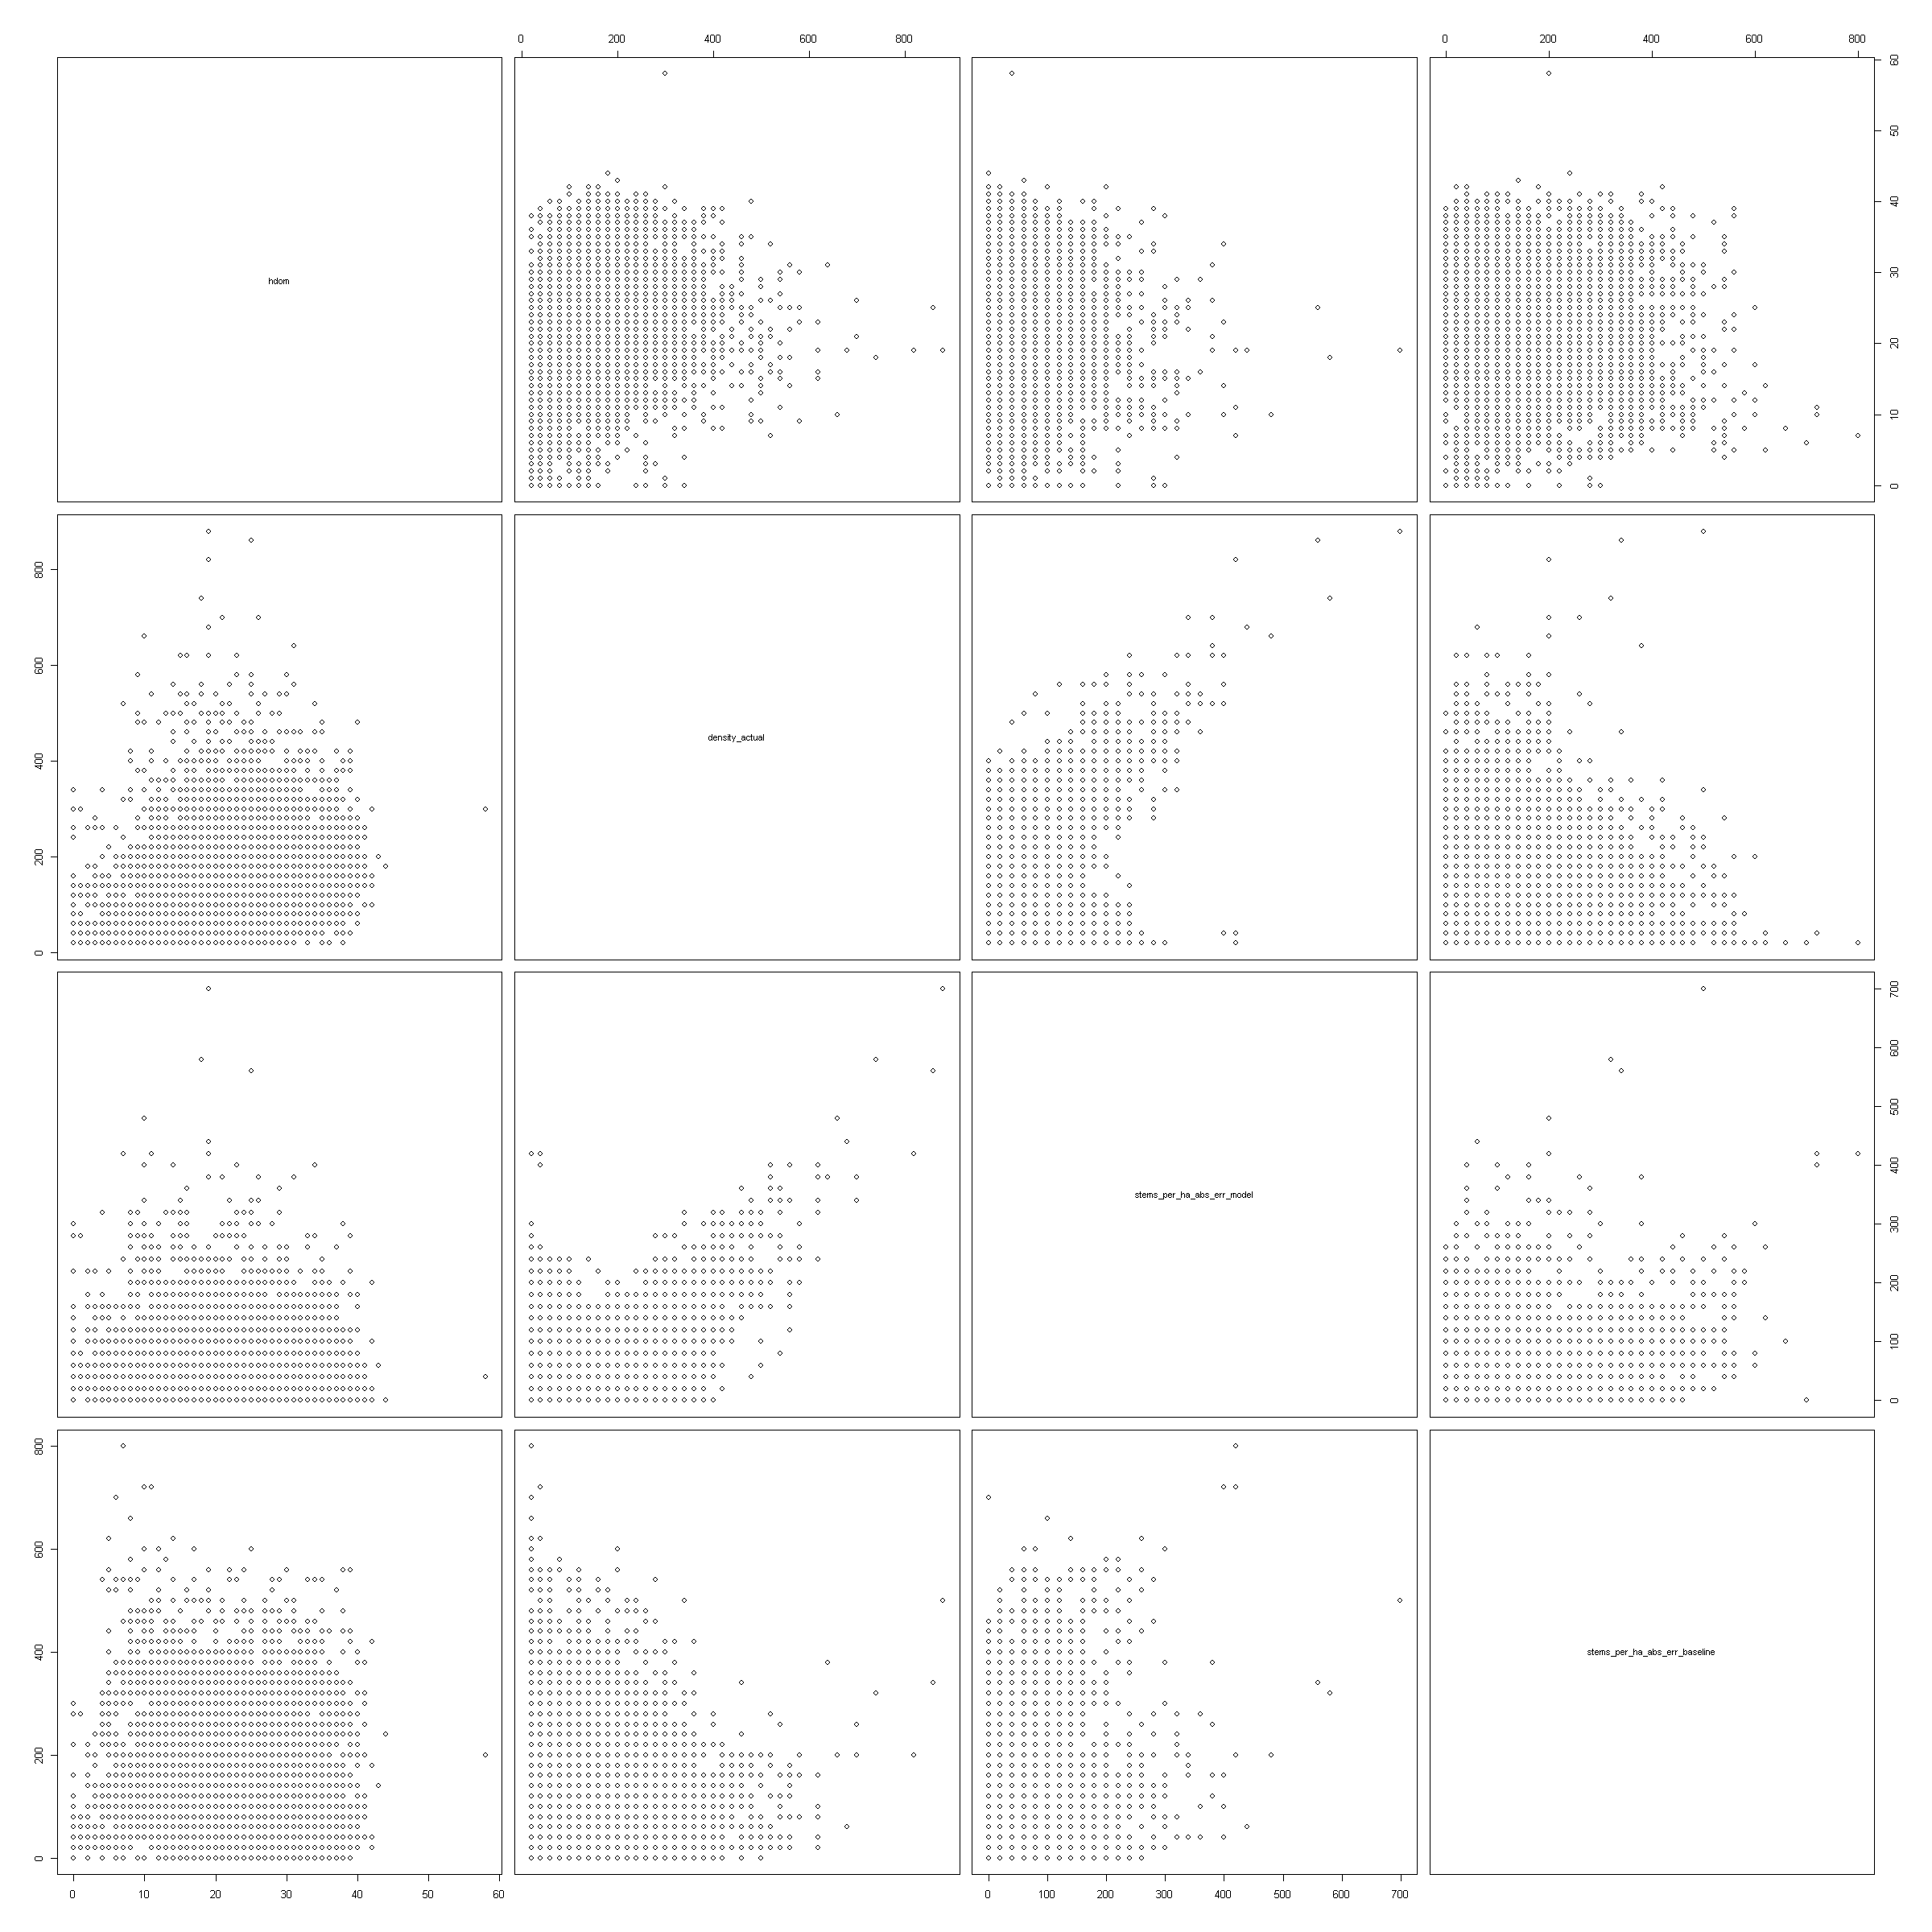

In [66]:
# Some pair plots
options(repr.plot.width=20, repr.plot.height=20)

pairs(data[,c( 'dg', 'nh', 'hdom', 'density_actual')])

pairs(data[,c( 'dg', 'density_actual', 'stems_per_ha_abs_err_model', 'stems_per_ha_abs_err_baseline')])
pairs(data[,c( 'nh', 'density_actual', 'stems_per_ha_abs_err_model', 'stems_per_ha_abs_err_baseline')])
pairs(data[,c( 'hdom', 'density_actual', 'stems_per_ha_abs_err_model', 'stems_per_ha_abs_err_baseline')])

In [67]:
# Build a data frame for box plots
df <- do.call( "rbind",list(
    data.frame(fst_dg=data$fst_dg,fst_nh=data$fst_nh,fst_hdom=data$fst_hdom, variable="density_actual", value=data$density_actual ),
    data.frame(fst_dg=data$fst_dg,fst_nh=data$fst_nh,fst_hdom=data$fst_hdom, variable="stems_per_ha_err_baseline", value=data$stems_per_ha_err_baseline ),
    data.frame(fst_dg=data$fst_dg,fst_nh=data$fst_nh,fst_hdom=data$fst_hdom, variable="stems_per_ha_err_model", value=data$stems_per_ha_err_model ),
    data.frame(fst_dg=data$fst_dg,fst_nh=data$fst_nh,fst_hdom=data$fst_hdom, variable="stems_per_ha_abs_err_baseline", value=data$stems_per_ha_abs_err_baseline ),
    data.frame(fst_dg=data$fst_dg,fst_nh=data$fst_nh,fst_hdom=data$fst_hdom, variable="stems_per_ha_abs_err_model", value=data$stems_per_ha_abs_err_model )
    ))

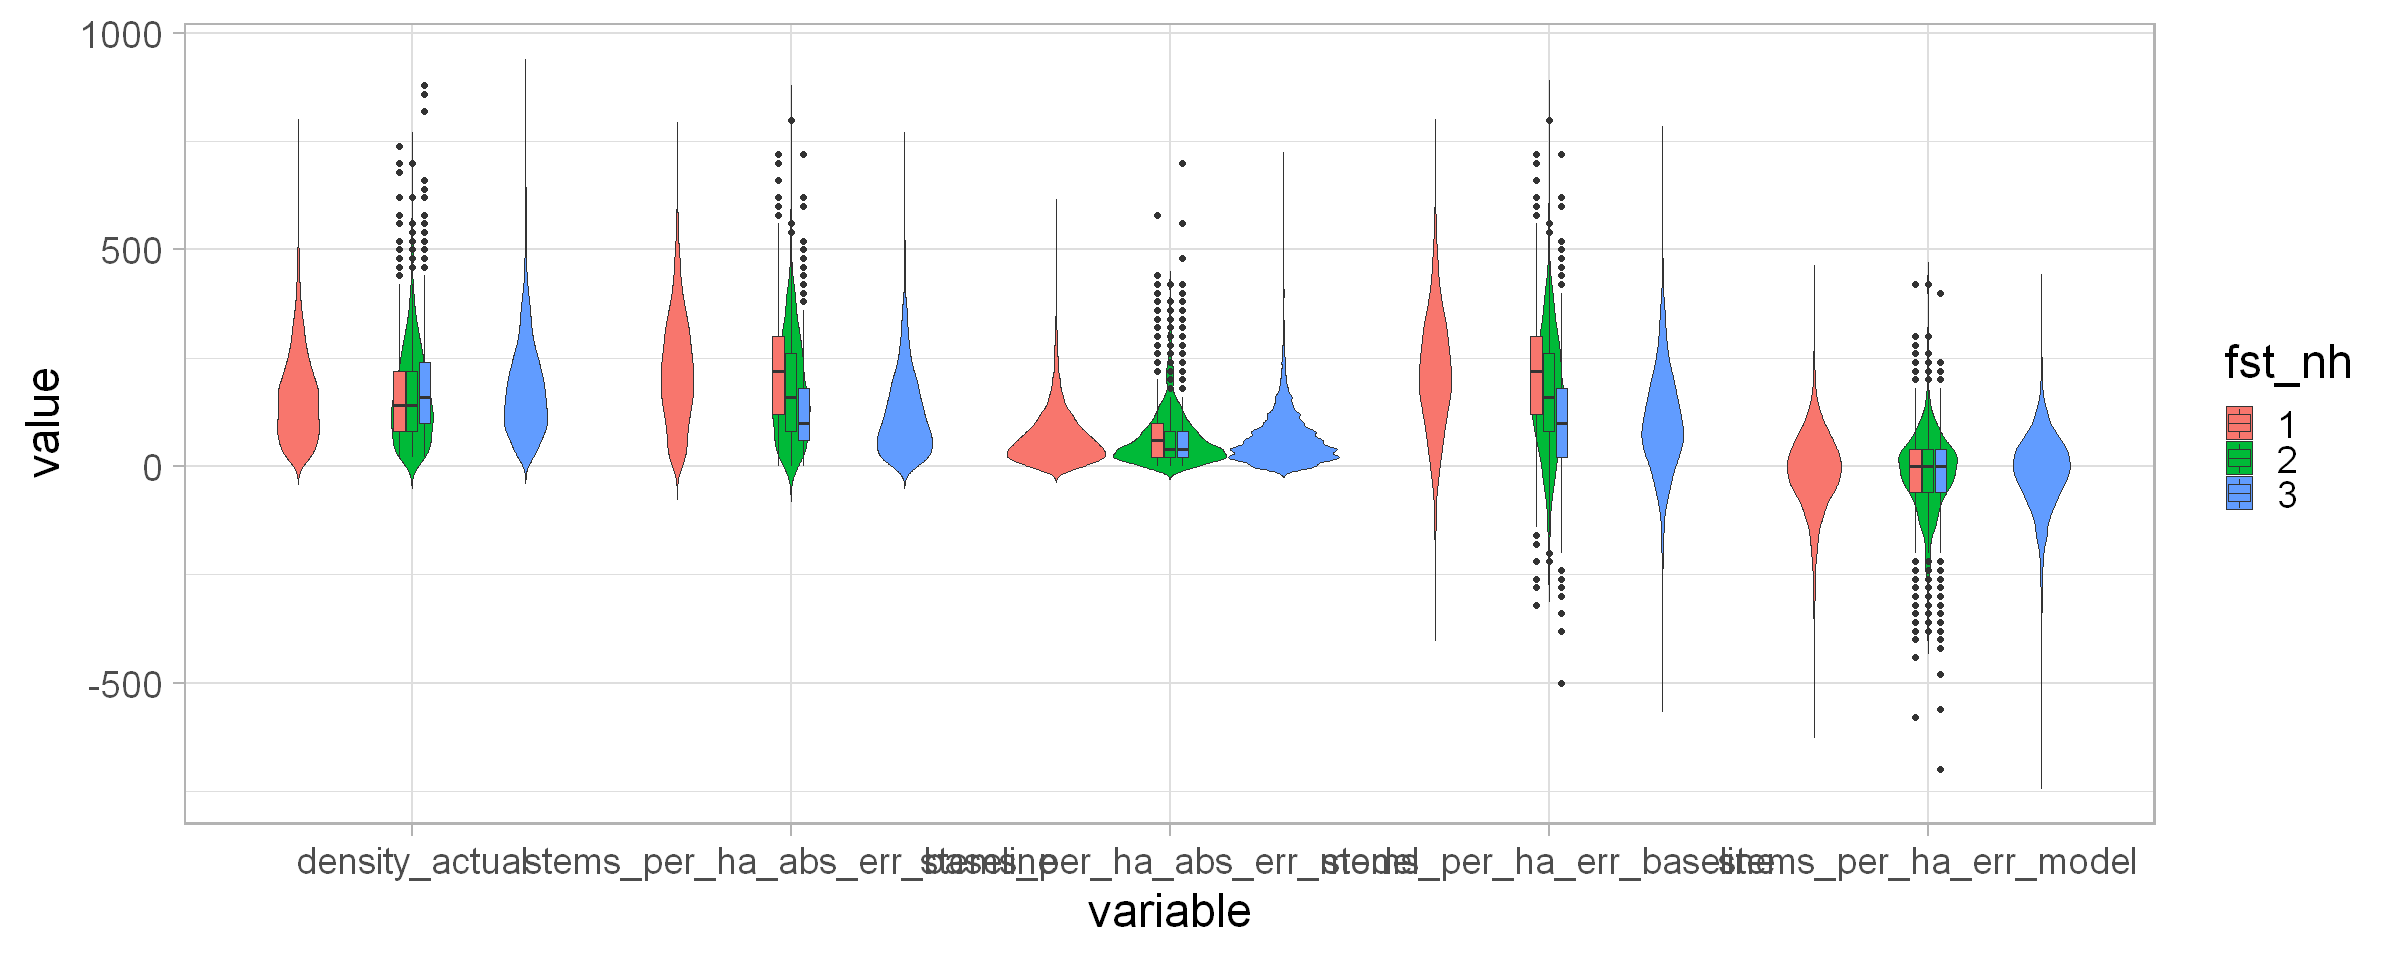

In [68]:
# Differentiated by mixing degree classes 1: nh<=30% ; 2: 30%<nh<=70% ; 3: nh>70%
options(repr.plot.width=20, repr.plot.height=8)

ggplot(df, aes(x=variable, y=value, fill=fst_nh)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  theme_light(base_size = font_base_size) 


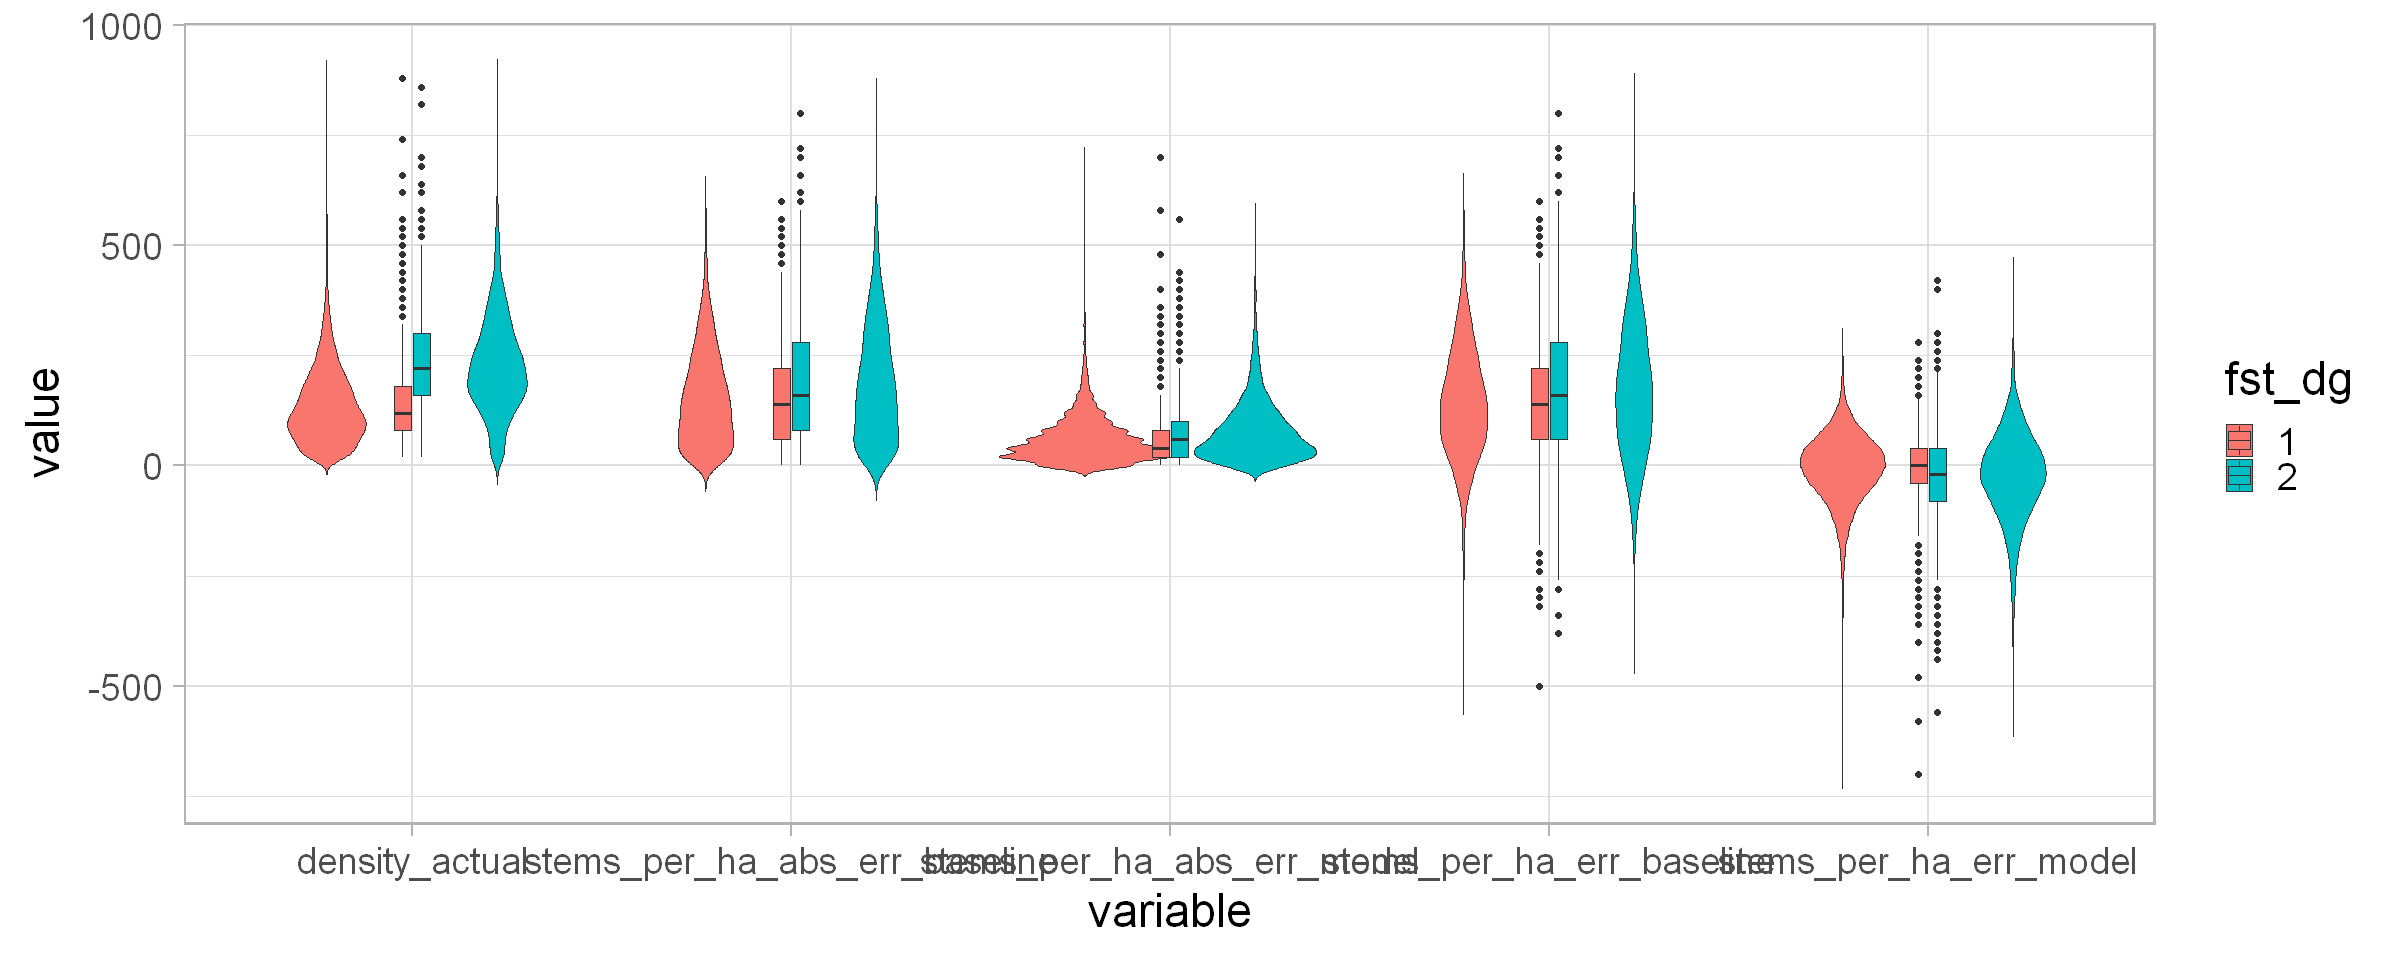

In [69]:
# Differentiated by degree of cover classes 1: dg <= 80% ; dg > 80%
options(repr.plot.width=20, repr.plot.height=8)

ggplot(df, aes(x=variable, y=value, fill=fst_dg)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  theme_light(base_size = font_base_size) 

Warning message:
"Removed 6 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 6 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 113 rows containing missing values (geom_violin)."


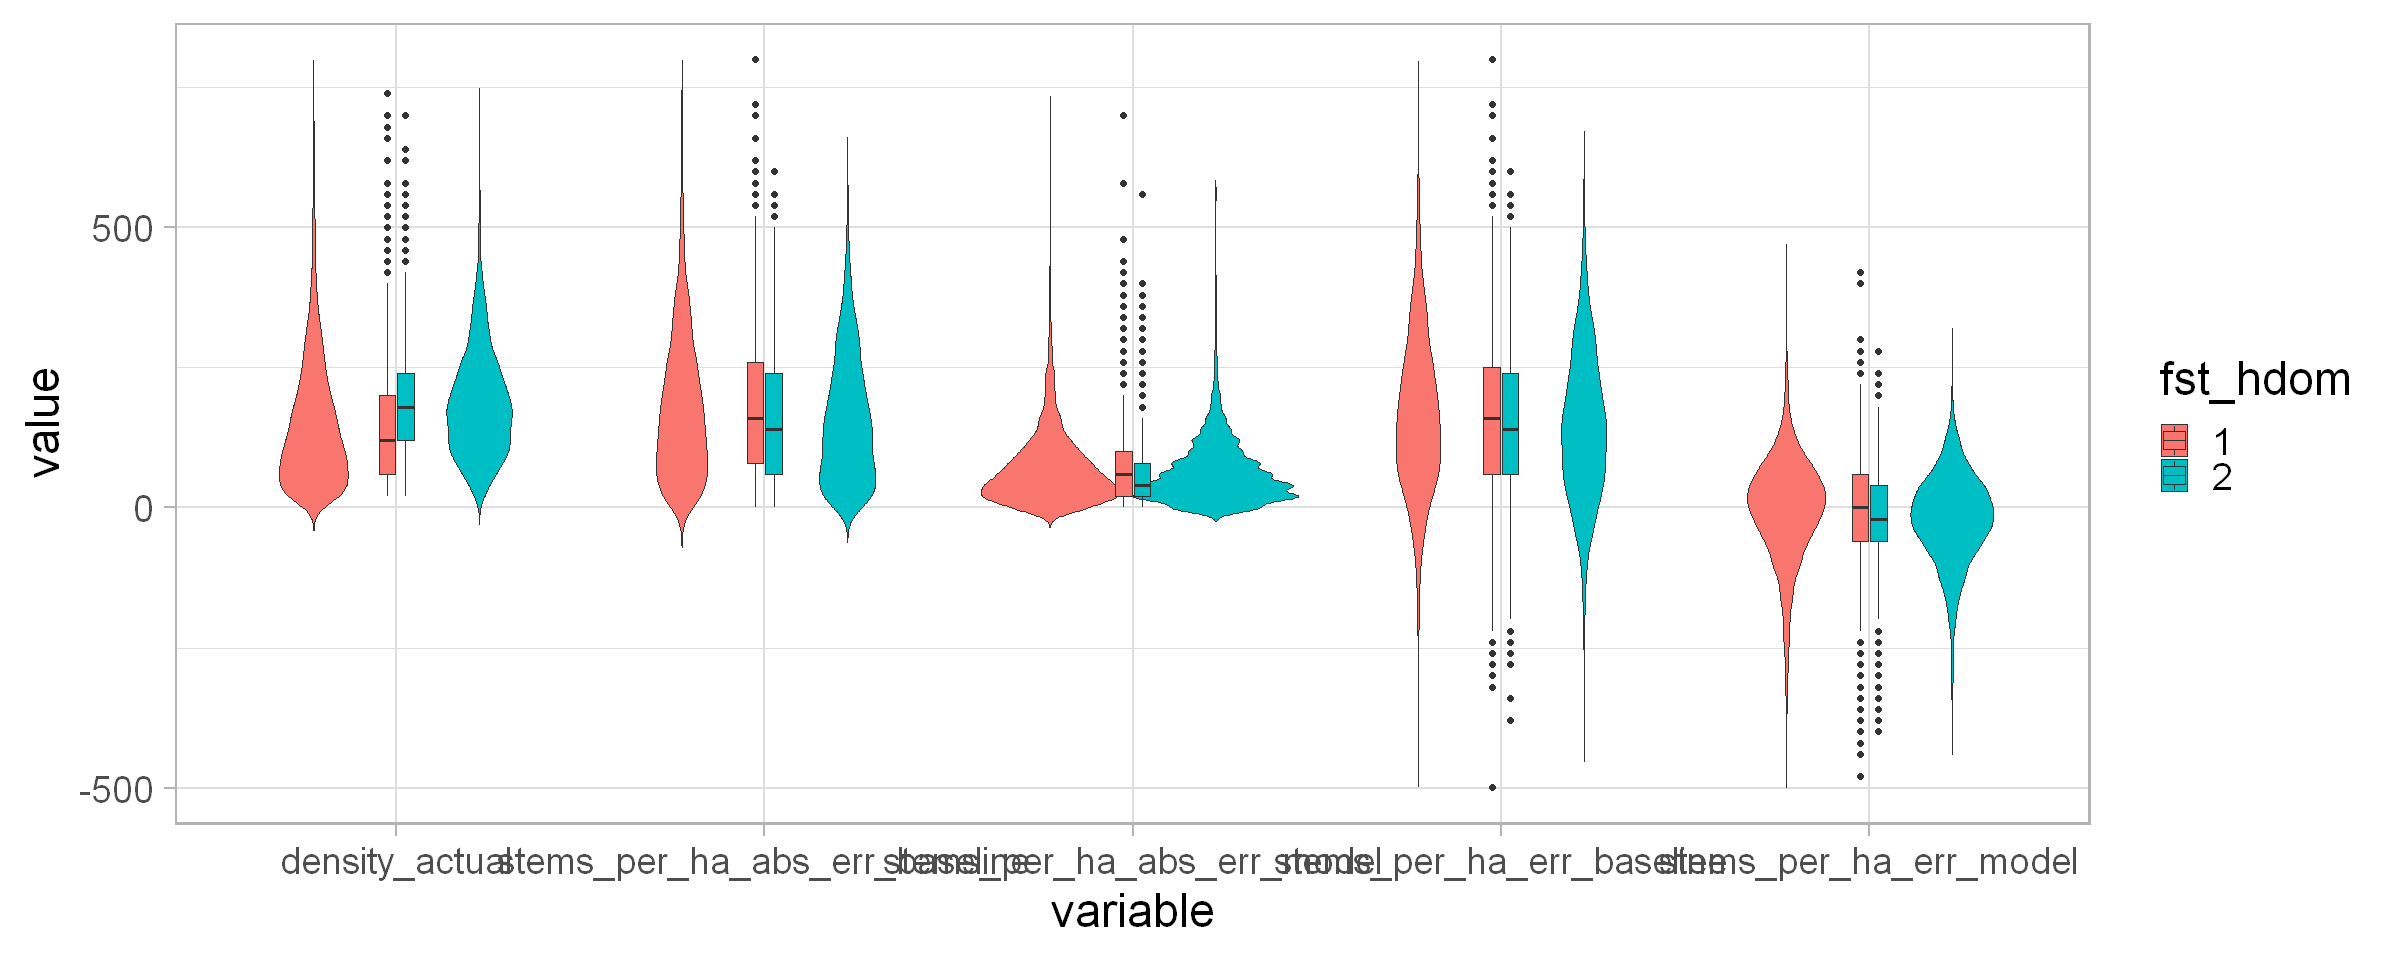

In [70]:
# Differentiated by dominant height classes 1: hdom <= 22 m ; hdom > 22 m
options(repr.plot.width=20, repr.plot.height=8)

ggplot(df, aes(x=variable, y=value, fill=fst_hdom)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  ylim(-500,800) +
  theme_light(base_size = font_base_size) 

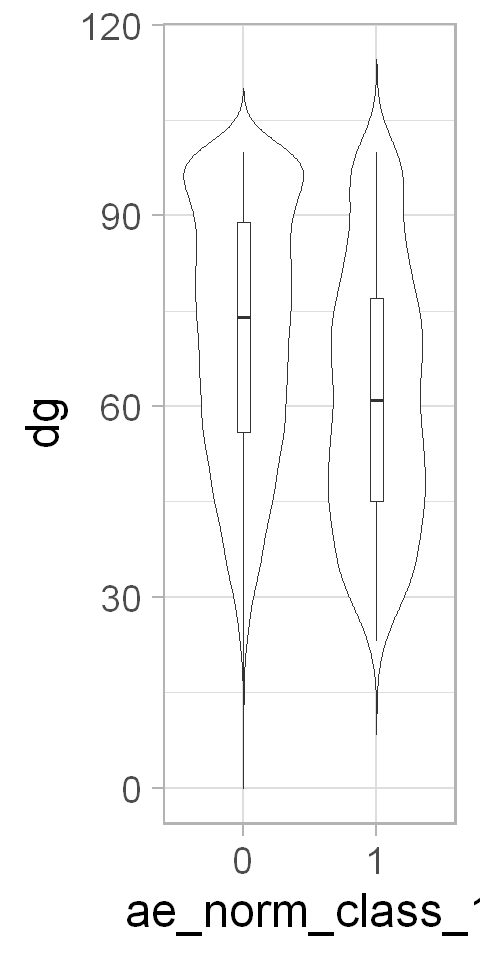

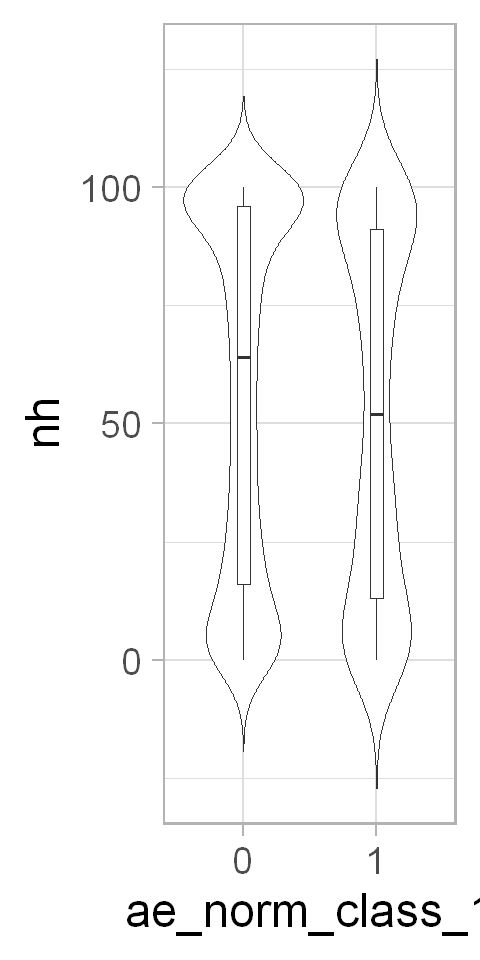

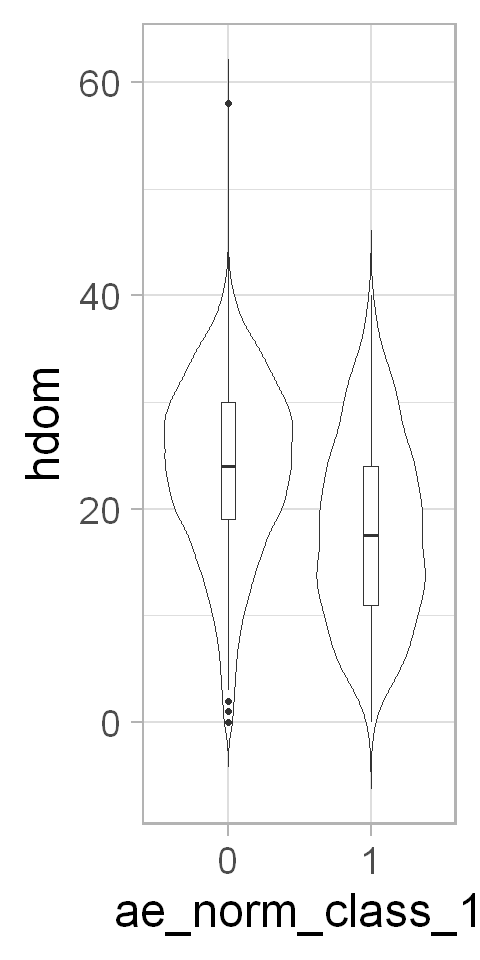

In [71]:
# Normalized absolute error >1 (1 on the right)
options(repr.plot.width=4, repr.plot.height=8)

ggplot(data, aes(x=ae_norm_class_1,y=dg)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  theme_light(base_size = font_base_size) 

ggplot(data, aes(x=ae_norm_class_1,y=nh)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  theme_light(base_size = font_base_size) 

ggplot(data, aes(x=ae_norm_class_1,y=hdom)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  theme_light(base_size = font_base_size) 


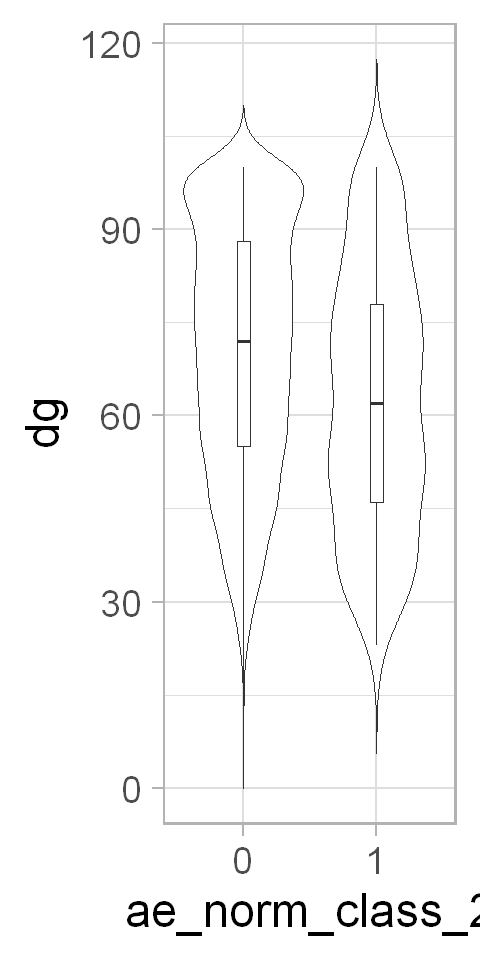

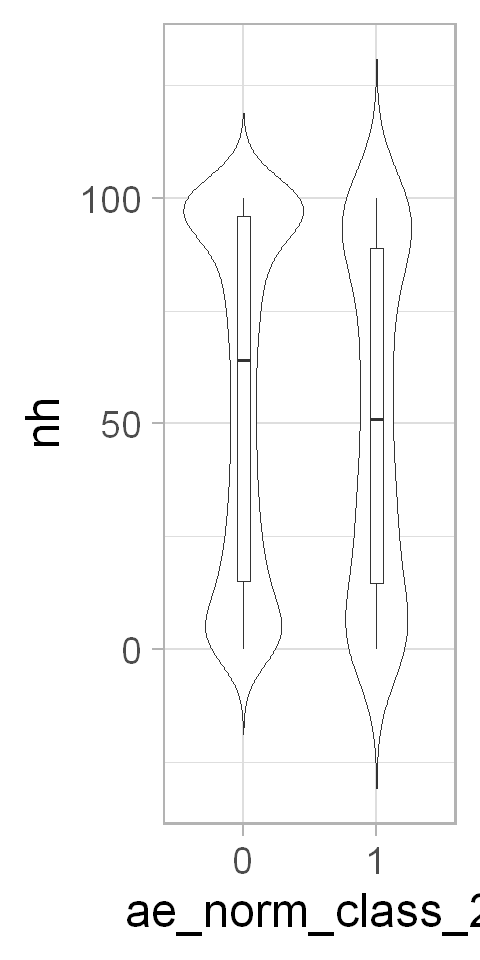

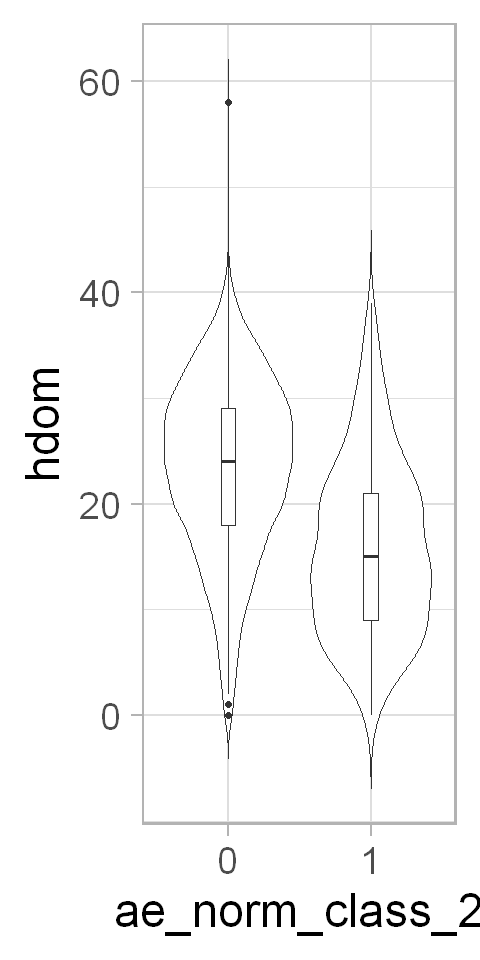

In [72]:
# Normalized absolute error >2 (1 on the right)
options(repr.plot.width=4, repr.plot.height=8)

ggplot(data, aes(x=ae_norm_class_2,y=dg)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  theme_light(base_size = font_base_size) 

ggplot(data, aes(x=ae_norm_class_2,y=nh)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  theme_light(base_size = font_base_size) 

ggplot(data, aes(x=ae_norm_class_2,y=hdom)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  theme_light(base_size = font_base_size) 


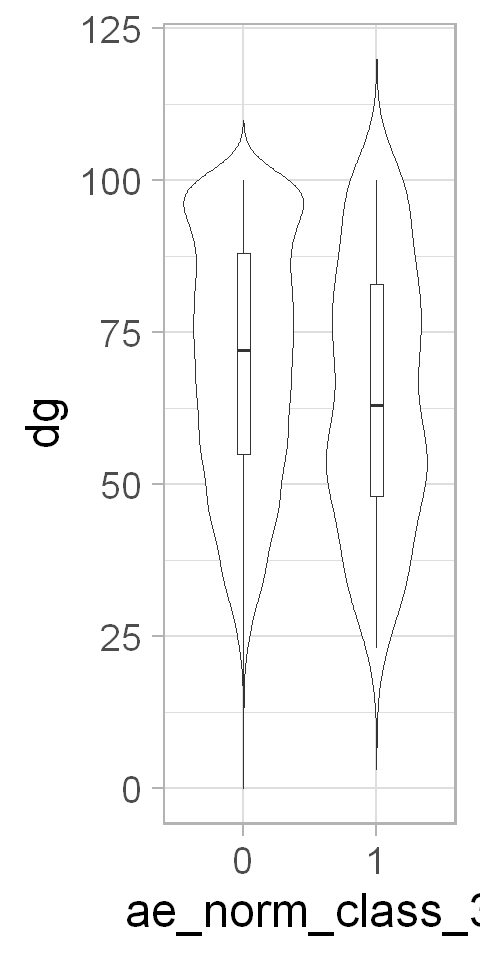

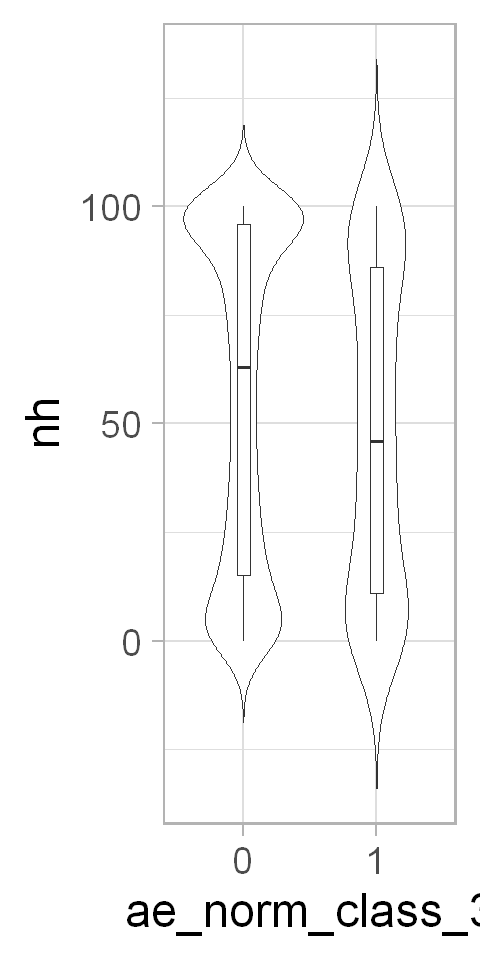

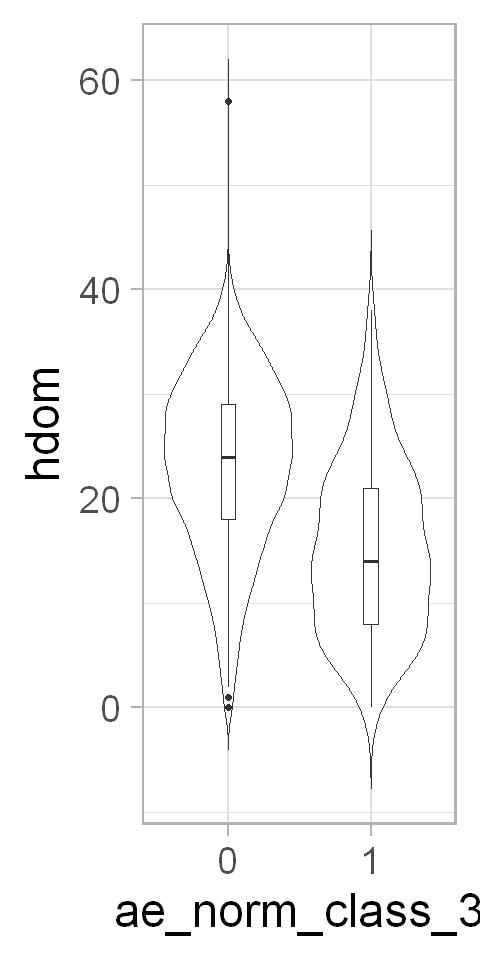

In [73]:
# Normalized absolute error >3 (1 on the right)
options(repr.plot.width=4, repr.plot.height=8)

ggplot(data, aes(x=ae_norm_class_3,y=dg)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  theme_light(base_size = font_base_size) 

ggplot(data, aes(x=ae_norm_class_3,y=nh)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  theme_light(base_size = font_base_size) 

ggplot(data, aes(x=ae_norm_class_3,y=hdom)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  theme_light(base_size = font_base_size) 


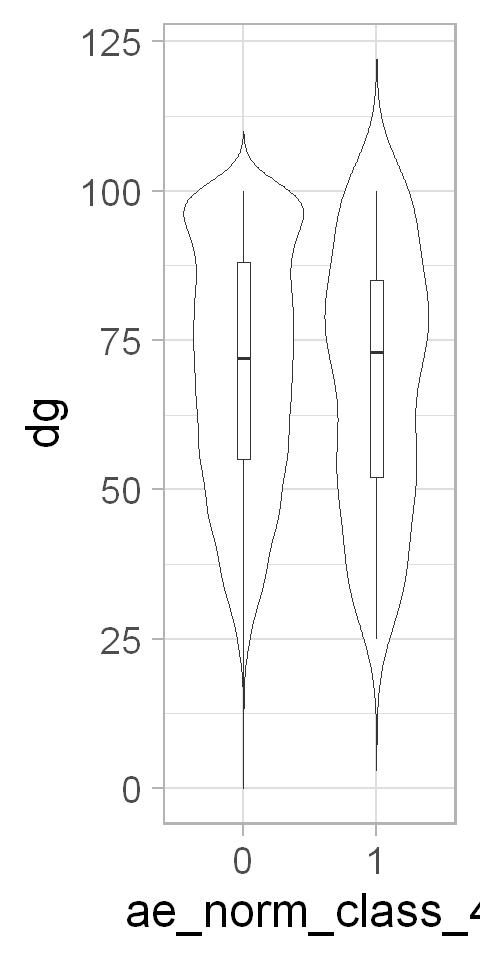

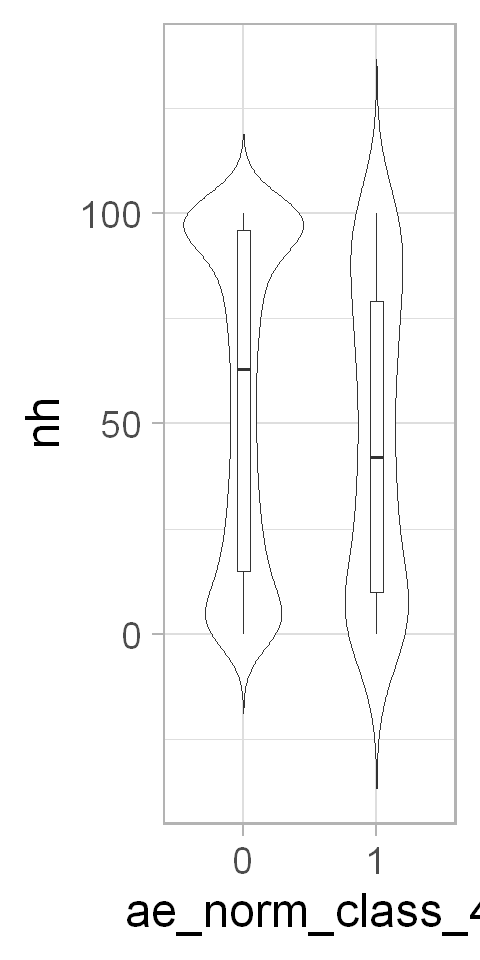

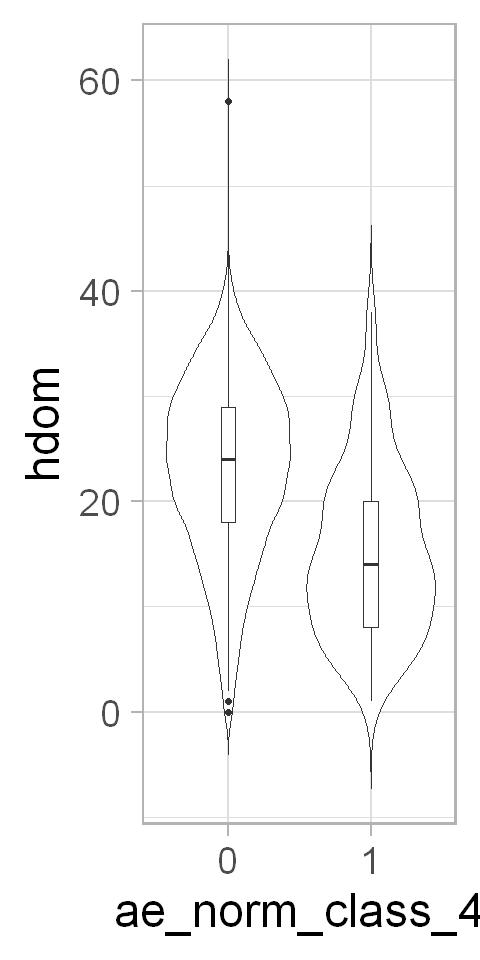

In [74]:
# Normalized absolute error >4 (1 on the right)
options(repr.plot.width=4, repr.plot.height=8)

ggplot(data, aes(x=ae_norm_class_4,y=dg)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  theme_light(base_size = font_base_size) 

ggplot(data, aes(x=ae_norm_class_4,y=nh)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  theme_light(base_size = font_base_size) 

ggplot(data, aes(x=ae_norm_class_4,y=hdom)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  theme_light(base_size = font_base_size) 


In [75]:
# Summary and counts per class
summary(data$stems_per_ha_abs_err_norm_model)
table(data[,c("ae_norm_class_1")])
table(data[,c("ae_norm_class_2")])
table(data[,c("ae_norm_class_3")])
table(data[,c("ae_norm_class_4")])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.1667  0.3333  0.6297  0.6000 21.0000 


   0    1 
4482  772 


   0    1 
4891  363 


   0    1 
5055  199 


   0    1 
5125  129 